# Paths and import

In [1]:
!pip install jieba

In [2]:
from __future__ import division
import sys
import argparse
import configparser
import json
import h5py as h5
import os
from os.path import isfile
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from sklearn import linear_model
import pickle
import jieba
from tqdm import tqdm
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from sklearn.utils import shuffle

In [3]:
config = configparser.ConfigParser()
my_config = '/home/jovyan/Project/Config/default.cfg'
with open('/home/jovyan/Project/Config/default.cfg', 'r') as f:
    config.read_file(f)

dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')
preproc_path = dsgv_home + '/Preproc/PreprocOut/'
feats_path = dsgv_home + '/ExtractFeats/ExtractOut/'
wac_path = dsgv_home + '/WACs/'


# The first 3 features in the image feature Xs encode the corpus ID, image ID, region ID
ID_FEATS = 3

In [5]:
# Define classifier
classifier = linear_model.LogisticRegression
classf_params = {
    'penalty': 'l2',
    'warm_start': True,
    'solver': 'sag',
    'max_iter': 500
}

# Model description:
model = {
    'rcorp': 'flickr30k',        # ref corpus
    'cnn': 'rsn50-flatten_1',        # CNN used for vision feats
    'wrdl':  'min',            # wordlist: minimal n occurrences...
    'wprm':  40,               # ... 40 times
    'clsf':  'logreg-l2',      # logistic regression, l1 regularized
    'params': classf_params,
    'scaled': True,
    'nneg':  'balanced',       # maximum neg instances
    'nsrc':  'randmax',        # ... randomly selected
    'notes': ''
}

# Data

In [6]:
with open(preproc_path + 'flickr30k_split.json', 'r') as f:
    rc_splits = json.load(f)

In [7]:
# image features
with h5.File(feats_path + 'flickr_bbdf_rsn50-max_all.hdf5') as f:
    X = np.array(f["img_feats"])

In [8]:
def filter_X_by_filelist(X, filelist):
    tmp_df = pd.DataFrame(X)
    tmp_df = tmp_df[tmp_df.iloc[:,1].isin(filelist)]
    X_t = tmp_df.to_numpy()
    return X_t

def filter_refdf_by_filelist(refdf, filelist):
    return pd.merge(refdf, pd.DataFrame(filelist, columns=['image_id']))

In [9]:
X_t = filter_X_by_filelist(X, rc_splits['train'])

In [10]:
X_t.shape

(258802, 2058)

## Using EN coefficient

In [11]:
weight_flickr_en = np.load(wac_path + 'ModelsOut/weight_flickr_en.npz')['arr_0']

In [12]:
weight_flickr_en.shape

(1207, 2056)

In [13]:
coef_flickr_en = weight_flickr_en[:,:-1]

In [13]:
new = [np.concatenate((feat, np.matmul(feat[ID_FEATS:], coef_flickr_en.transpose())), axis=None) for feat in tqdm(X_t)]
X_t_new = np.vstack(new)

100%|██████████| 258802/258802 [1:48:40<00:00, 39.69it/s]  


In [14]:
X_t_new.shape

(258802, 3265)

In [14]:
with open(wac_path + 'ModelsOut/X_t_new.pkl', 'wb') as f:
    pickle.dump(X_t_new, f)
with open(wac_path + 'ModelsOut/X_t_new.pkl', 'rb') as f:
    X_t_new = pickle.load(f)

## Referring expressions - CN

In [15]:
with open(preproc_path + 'flickr30k_objdf_cn.json.gz', 'r') as f:
    refdf_cn = json.load(f)
    refdf_cn = pd.DataFrame(refdf_cn)
refdf_train_cn = filter_refdf_by_filelist(refdf_cn, rc_splits['train'])

In [16]:
refdf_train_cn

,i_corpus,image_id,region_id,phrase,cat,phrase_cn
0,8,3187924573,99601,Two seagulls,animals,兩隻海鷗
1,8,3187924573,99604,water,scene,水
2,8,3187924573,99600,foreground bird,animals,前景鳥
3,8,3187924573,99603,object,other,目的
4,8,3187924573,99602,beak,bodyparts,喙
...,...,...,...,...,...,...
524860,8,408748500,154756,A child,people,一個孩子
524861,8,408748500,154757,a coat,clothing,一件外套
524862,8,408748500,154760,someone,people,某人
524863,8,408748500,154756,a boy,people,一個男孩


# Intermediate

Englsih

In [18]:
def create_word2den(refdf, refcol, regcol='region_id'):
    '''Given refdf, returns dict of occurences (id triples) of words from expressions.'''
    word2den = defaultdict(list)
    for _, row in refdf.iterrows():
        exprlist = row[refcol].split()
        
        for word in exprlist:
            word = word.lower()
            word_den_list = word2den[word].append((row['i_corpus'],
                                                   row['image_id'],
                                                   row[regcol]))
    return {k: list(set(v)) for k,v in word2den.items()}

Chinese text segmentation 1 -- accurate mode

In [19]:
def create_word2den_cn(refdf, refcol, regcol='region_id'):
    '''Given refdf, returns dict of occurences (id triples) of words from expressions.'''
    word2den = defaultdict(list)
    for _, row in refdf.iterrows():
        exprlist = jieba.cut(row[refcol])
        exprlist = '/'.join(exprlist)
        exprlist = exprlist.split('/')

        for word in exprlist:
            word_den_list = word2den[word].append((row['i_corpus'],
                                                   row['image_id'],
                                                   row[regcol]))
    return {k: list(set(v)) for k,v in word2den.items()}

Chinese text segmentation 2 -- full mode

In [20]:
def create_word2den_cn2(refdf, refcol, regcol='region_id'):
    '''Given refdf, returns dict of occurences (id triples) of words from expressions.'''
    word2den = defaultdict(list)
    for _, row in refdf.iterrows():
        exprlist = jieba.cut(row[refcol],cut_all=True)
        exprlist = '/'.join(exprlist)
        exprlist = exprlist.split('/')

        for word in exprlist:
            word_den_list = word2den[word].append((row['i_corpus'],
                                                   row['image_id'],
                                                   row[regcol]))
    return {k: list(set(v)) for k,v in word2den.items()}

In [21]:
%%time
word2den_en = create_word2den(refdf_train_cn, refcol='phrase')
word2den_cn = create_word2den_cn(refdf_train_cn, refcol='phrase_cn')
word2den_cn2 = create_word2den_cn2(refdf_train_cn, refcol='phrase_cn')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.640 seconds.
Prefix dict has been built successfully.


CPU times: user 2min 16s, sys: 1.3 s, total: 2min 17s
Wall time: 2min 18s


In [22]:
def make_X_id_index(X, id_feats=ID_FEATS):
    return dict(zip([tuple(e) for e in X[:,:id_feats].astype(int).tolist()], range(len(X))))

In [23]:
%%time
X_idx = make_X_id_index(X_t)
X_idx2 = make_X_id_index(X_t_new)

CPU times: user 2.99 s, sys: 418 ms, total: 3.4 s
Wall time: 3.42 s


In [24]:
def make_mask_matrix(X, X_idx, word2den, wordlist):
    mask_matrix = []
    for this_word in wordlist:
        this_word_vec = np.zeros(len(X))
        if this_word in word2den:
            this_word_vec[[X_idx[i] for i in word2den[this_word] if i in X_idx]] = 1
        mask_matrix.append(this_word_vec)
    mask_matrix = np.array(mask_matrix, dtype=bool)
    return mask_matrix

In [25]:
%%time
mask_matrix_cn = make_mask_matrix(X_t, X_idx, word2den_cn, word2den_cn.keys())
mask_matrix_cn2 = make_mask_matrix(X_t_new, X_idx2, word2den_cn2, word2den_cn2.keys())

CPU times: user 20.1 s, sys: 17.4 s, total: 37.5 s
Wall time: 37.7 s


In [26]:
np.savez(wac_path + 'ModelsOut/flickr_mask_matrix_cn_l1.npz', arr_0=mask_matrix_cn)
np.savez(wac_path + 'ModelsOut/flickr_mask_matrix_cn2_l1.npz', arr_0=mask_matrix_cn2)

In [27]:
mask_matrix_cn = np.load(wac_path + 'ModelsOut/flickr_mask_matrix_cn_l1.npz')['arr_0']
mask_matrix_cn2 = np.load(wac_path + 'ModelsOut/flickr_mask_matrix_cn2_l1.npz')['arr_0']

# Wordlist

In [28]:
min_freq = model['wprm']
counts_cn = mask_matrix_cn.sum(axis=1)
wordlist_cn = np.array(list(word2den_cn.keys()))[counts_cn > min_freq]

In [29]:
min_freq = model['wprm']
counts_cn2 = mask_matrix_cn2.sum(axis=1)
wordlist_cn2 = np.array(list(word2den_cn2.keys()))[counts_cn2 > min_freq]

In [30]:
def get_X_for_word(X, word2den, mask_matrix, word, neg_max):
    if word not in word2den:
        print ("Error!! No mask available for this word! (%s)" % (word))
        return None
    this_mask = mask_matrix[list(word2den.keys()).index(word)]
    X_pos = X[this_mask, ID_FEATS:]
    y_pos = np.ones(len(X_pos), dtype=int)

    if type(neg_max) is int or type(neg_max) is str:
        if neg_max == 0:
            return X_pos, y_pos
        if neg_max == 'balanced':
            neg_max = len(y_pos)
    
        neg_indx = np.arange(mask_matrix.shape[1])[~this_mask]
        np.random.shuffle(neg_indx)
        X_neg = X[neg_indx[:neg_max], ID_FEATS:]
    else:
        X_neg = neg_max
    y_neg = np.zeros(len(X_neg), dtype=int)

    X_out = np.concatenate([X_pos, X_neg], axis=0)
    y_out = np.concatenate([y_pos, y_neg])
    return shuffle(X_out, y_out)

In [31]:
def make_train_for_word(X, word2den, mask_matrix, word, neg_max=20000):
    if word not in word2den:
        #raise ValueError("No mask available for this word! (%s)" % (word))
        print("Error!! No mask available for this word! (%s)" % (word))
        return None
    this_mask = mask_matrix[list(word2den.keys()).index(word)]
    
    X_pos = X[this_mask, ID_FEATS:]
    y_pos = np.ones(len(X_pos), dtype=int)
    
    neg_indx = np.arange(mask_matrix.shape[1])[~this_mask]
    np.random.shuffle(neg_indx)
    # X_neg = X[neg_indx[:neg_max], ID_FEATS:]
    X_neg = X[neg_indx[:len(y_pos)], ID_FEATS:]
    y_neg = np.zeros(len(X_neg), dtype=int)

    X_out = np.concatenate([X_pos, X_neg], axis=0)
    y_out = np.concatenate([y_pos, y_neg])
    return shuffle(X_out, y_out)

# Train

Train the CN wac with extra features from the EN result

In [19]:
wacs_both = []
for this_word in tqdm(wordlist_cn):
    X_this_w, y_this_w = get_X_for_word(X_t_new, word2den_cn, mask_matrix_cn, this_word,neg_max='balanced')
    print(this_word, X_this_w.shape[0])
    classifier = linear_model.LogisticRegression(penalty='l2', warm_start=True, solver='sag')
    this_wac = classifier.fit(X_this_w, y_this_w)
    wacs_both.append((this_word, y_this_w.sum(), len(X_this_w), this_wac))

  0%|          | 0/1378 [00:00<?, ?it/s]

兩 1076


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 1/1378 [00:03<1:26:40,  3.78s/it]

隻 6258


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 2/1378 [00:23<5:00:33, 13.11s/it]

水 3436


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 3/1378 [00:31<4:08:38, 10.85s/it]

鳥 304


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 4/1378 [00:32<2:36:42,  6.84s/it]

一 7396


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 5/1378 [00:50<4:07:13, 10.80s/it]

某物 1204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 6/1378 [00:52<3:05:02,  8.09s/it]

它 1222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 7/1378 [00:57<2:36:40,  6.86s/it]

的 88578


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 8/1378 [04:30<27:33:59, 72.44s/it]

大白 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 9/1378 [04:30<18:58:17, 49.89s/it]

一個 76822


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 10/1378 [07:35<34:49:15, 91.63s/it]

蹣跚 846


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 11/1378 [07:37<24:22:48, 64.21s/it]

學步 882


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 12/1378 [07:39<17:11:22, 45.30s/it]

男孩 6480


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 13/1378 [07:55<13:45:03, 36.27s/it]

一頂 3866


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 14/1378 [08:05<10:48:34, 28.53s/it]

藍色 11218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 15/1378 [08:33<10:42:58, 28.30s/it]

棒球帽 544


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 16/1378 [08:34<7:37:49, 20.17s/it] 

年幼 1662


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 17/1378 [08:38<5:46:48, 15.29s/it]

孩子 9406


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|▏         | 18/1378 [09:00<6:32:16, 17.31s/it]

手 4876


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|▏         | 19/1378 [09:11<5:50:47, 15.49s/it]

成年人 794


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|▏         | 20/1378 [09:13<4:18:00, 11.40s/it]

某人 1176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 21/1378 [09:16<3:18:58,  8.80s/it]

梯子 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 22/1378 [09:17<2:23:08,  6.33s/it]

小男孩 4686


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 23/1378 [09:28<2:55:01,  7.75s/it]

帽子 4112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 24/1378 [09:40<3:23:08,  9.00s/it]

兒童 448


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 25/1378 [09:41<2:29:12,  6.62s/it]

公園 942


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 26/1378 [09:44<2:06:31,  5.61s/it]

三個 3834


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 27/1378 [09:55<2:44:10,  7.29s/it]

朋友 776


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 28/1378 [09:57<2:07:31,  5.67s/it]

一條 10108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 37/1378 [11:46<8:23:41, 22.54s/it]

另外 486


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 38/1378 [11:47<6:00:00, 16.12s/it]

兩個 9320


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 39/1378 [12:09<6:38:42, 17.87s/it]

人 24880


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 40/1378 [13:09<11:14:33, 30.25s/it]

五顏六色 1018


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 41/1378 [13:11<8:08:01, 21.90s/it] 

塑料 380


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 42/1378 [13:12<5:50:13, 15.73s/it]

建築 3682


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 43/1378 [13:25<5:32:24, 14.94s/it]

玩具 1408


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 44/1378 [13:29<4:19:28, 11.67s/it]

可愛的 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 45/1378 [13:30<3:03:57,  8.28s/it]

他 13170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 46/1378 [14:01<5:35:43, 15.12s/it]

木 554


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 47/1378 [14:03<4:07:42, 11.17s/it]

寶寶 886


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 48/1378 [14:06<3:14:21,  8.77s/it]

圍欄 730


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▎         | 49/1378 [14:09<2:32:39,  6.89s/it]

套裝 270


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▎         | 50/1378 [14:10<1:53:14,  5.12s/it]

皮膚 230


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▎         | 51/1378 [14:10<1:24:52,  3.84s/it]

黝黑 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 52/1378 [14:11<1:03:08,  2.86s/it]

年 13682


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 53/1378 [14:50<5:01:55, 13.67s/it]

輕 7514


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 54/1378 [15:08<5:29:47, 14.95s/it]

女孩 8492


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 55/1378 [15:31<6:22:02, 17.33s/it]

她 7720


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 56/1378 [15:58<7:25:39, 20.23s/it]

運動鞋 210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 57/1378 [15:58<5:16:40, 14.38s/it]

印度 336


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 58/1378 [16:00<3:49:23, 10.43s/it]

觀眾 1102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 59/1378 [16:03<3:04:50,  8.41s/it]

路邊 402


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 60/1378 [16:04<2:15:26,  6.17s/it]

攤 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 61/1378 [16:05<1:37:31,  4.44s/it]

一群 9798


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 62/1378 [16:28<3:39:57, 10.03s/it]

小女孩 2556


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 63/1378 [16:34<3:13:02,  8.81s/it]

鞋 338


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 64/1378 [16:34<2:20:11,  6.40s/it]

一把 2368


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 65/1378 [16:40<2:14:54,  6.16s/it]

黑皮 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 66/1378 [16:40<1:36:09,  4.40s/it]

膚 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 67/1378 [16:41<1:09:00,  3.16s/it]

鞋子 328


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 68/1378 [16:41<53:57,  2.47s/it]  

幾個 3514


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 69/1378 [16:50<1:31:50,  4.21s/it]

女性 2996


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 70/1378 [16:57<1:50:20,  5.06s/it]

黃 5080


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 71/1378 [17:09<2:35:05,  7.12s/it]

色 4262


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 72/1378 [17:19<2:56:24,  8.10s/it]

桌子 2372


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 73/1378 [17:25<2:41:23,  7.42s/it]

那 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 74/1378 [17:25<1:54:55,  5.29s/it]

一行 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 75/1378 [17:26<1:23:18,  3.84s/it]

女人 15942


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 76/1378 [18:05<5:11:39, 14.36s/it]

一位 5146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 77/1378 [18:17<4:57:04, 13.70s/it]

女士 5728


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 78/1378 [18:30<4:55:12, 13.63s/it]

東西 380


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 79/1378 [18:31<3:32:15,  9.80s/it]

目標 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 80/1378 [18:31<2:30:56,  6.98s/it]

一杯 764


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 81/1378 [18:33<1:57:20,  5.43s/it]

遊戲 432


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 82/1378 [18:35<1:31:59,  4.26s/it]

毛絨 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 83/1378 [18:36<1:08:53,  3.19s/it]

毯子 392


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 84/1378 [18:37<57:15,  2.65s/it]  

全部 410


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 85/1378 [18:38<49:26,  2.29s/it]

草地 1894


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 86/1378 [18:45<1:18:40,  3.65s/it]

男嬰 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▋         | 87/1378 [18:46<57:26,  2.67s/it]  

黑色 10150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▋         | 88/1378 [19:22<4:36:09, 12.84s/it]

和 6550


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▋         | 89/1378 [19:38<4:56:49, 13.82s/it]

紅色 6622


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 90/1378 [19:56<5:20:09, 14.91s/it]

條紋 1696


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 91/1378 [20:00<4:10:32, 11.68s/it]

襯衫 14872


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 92/1378 [20:35<6:40:08, 18.67s/it]

一張 3912


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 93/1378 [20:46<5:52:07, 16.44s/it]

照片 986


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 94/1378 [20:48<4:21:01, 12.20s/it]

雕像 384


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 95/1378 [20:49<3:08:17,  8.81s/it]

雕塑 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 96/1378 [20:50<2:14:47,  6.31s/it]

紋 282


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 97/1378 [20:51<1:40:34,  4.71s/it]

巨大 580


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 98/1378 [20:53<1:23:20,  3.91s/it]

一顆 840


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 99/1378 [20:56<1:17:09,  3.62s/it]

樹 1258


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 100/1378 [21:00<1:21:35,  3.83s/it]

其中 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 101/1378 [21:00<59:33,  2.80s/it]  

之一 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 102/1378 [21:01<43:30,  2.05s/it]

狗 4682


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 103/1378 [21:12<1:41:02,  4.75s/it]

一根 1722


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 104/1378 [21:16<1:36:20,  4.54s/it]

樹枝 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 105/1378 [21:16<1:09:59,  3.30s/it]

他們 4730


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 106/1378 [21:27<2:00:28,  5.68s/it]

那個 636


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 107/1378 [21:29<1:33:35,  4.42s/it]

長 5994


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 108/1378 [21:43<2:34:45,  7.31s/it]

眼鏡 2022


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 109/1378 [21:48<2:18:28,  6.55s/it]

一本 574


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 110/1378 [21:49<1:45:17,  4.98s/it]

書 604


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 111/1378 [21:50<1:22:26,  3.90s/it]

一家 824


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 112/1378 [21:52<1:09:53,  3.31s/it]

店 268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 113/1378 [21:53<52:46,  2.50s/it]  

牆壁 316


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 114/1378 [21:54<41:32,  1.97s/it]

年長 600


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 115/1378 [21:55<37:50,  1.80s/it]

一頓 284


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 116/1378 [21:56<30:40,  1.46s/it]

飯 304


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 117/1378 [21:57<25:56,  1.23s/it]

老年 406


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▊         | 118/1378 [21:57<23:57,  1.14s/it]

婦女 1122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▊         | 119/1378 [22:00<33:02,  1.57s/it]

一件 16926


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▊         | 120/1378 [22:40<4:36:18, 13.18s/it]

夾克 4504


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 121/1378 [22:51<4:19:41, 12.40s/it]

單板 282


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 122/1378 [22:52<3:05:43,  8.87s/it]

滑雪者 580


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 123/1378 [22:53<2:18:09,  6.61s/it]

董事 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 124/1378 [22:53<1:38:45,  4.73s/it]

會 196


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 125/1378 [22:54<1:12:07,  3.45s/it]

雪 1202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 126/1378 [22:57<1:08:37,  3.29s/it]

山 686


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 127/1378 [22:58<57:47,  2.77s/it]  

或 606


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 128/1378 [23:00<48:59,  2.35s/it]

滑雪板 390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 129/1378 [23:00<39:55,  1.92s/it]

一座 2494


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 130/1378 [23:06<1:04:20,  3.09s/it]

黑白 852


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 131/1378 [23:08<57:14,  2.75s/it]  

項 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 132/1378 [23:09<42:31,  2.05s/it]

鍊 336


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 133/1378 [23:09<34:43,  1.67s/it]

另 3606


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 134/1378 [23:18<1:16:39,  3.70s/it]

模型 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 135/1378 [23:18<56:20,  2.72s/it]  

商店 830


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 136/1378 [23:20<51:32,  2.49s/it]

櫥窗 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 137/1378 [23:20<37:46,  1.83s/it]

其他 2114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 138/1378 [23:26<57:45,  2.80s/it]

市場 286


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 139/1378 [23:26<44:31,  2.16s/it]

攤位 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 140/1378 [23:27<36:04,  1.75s/it]

灰色 2700


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 141/1378 [23:35<1:16:20,  3.70s/it]

迷彩 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 142/1378 [23:36<57:09,  2.77s/it]  

褲子 2444


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 143/1378 [23:44<1:31:05,  4.43s/it]

藍 1138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 144/1378 [23:47<1:20:25,  3.91s/it]

色卡 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 145/1378 [23:47<57:59,  2.82s/it]  

車的 1288


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 146/1378 [23:50<58:58,  2.87s/it]

引擎 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 147/1378 [23:51<45:08,  2.20s/it]

蓋 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 148/1378 [23:51<34:35,  1.69s/it]

自動 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 149/1378 [23:52<27:20,  1.33s/it]

卡車 546


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 150/1378 [23:54<30:43,  1.50s/it]

陰影 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 151/1378 [23:54<24:51,  1.22s/it]

兩名 4672


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 152/1378 [24:06<1:32:29,  4.53s/it]

職業 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 153/1378 [24:07<1:06:37,  3.26s/it]

足球 2380


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 154/1378 [24:12<1:20:46,  3.96s/it]

運動員 2960


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 155/1378 [24:21<1:48:13,  5.31s/it]

體育場 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█▏        | 156/1378 [24:21<1:17:06,  3.79s/it]

一場 412


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█▏        | 157/1378 [24:22<59:38,  2.93s/it]  

比賽 342


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█▏        | 158/1378 [24:23<46:27,  2.28s/it]

一名 2890


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 159/1378 [24:32<1:29:36,  4.41s/it]

球員 354


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 160/1378 [24:33<1:08:18,  3.36s/it]

球 2134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 161/1378 [24:38<1:17:56,  3.84s/it]

紫色 1536


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 162/1378 [24:42<1:16:35,  3.78s/it]

領域 1012


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 163/1378 [24:44<1:08:11,  3.37s/it]

兩位 734


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 164/1378 [24:46<58:09,  2.87s/it]  

場 672


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 165/1378 [24:47<50:11,  2.48s/it]

行人 372


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 166/1378 [24:48<40:17,  1.99s/it]

自行 4264


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 167/1378 [24:58<1:28:42,  4.39s/it]

車 4738


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 168/1378 [25:10<2:10:47,  6.49s/it]

一輛 3994


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 169/1378 [25:19<2:28:26,  7.37s/it]

街 1376


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 170/1378 [25:22<2:03:35,  6.14s/it]

棕色 5542


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 171/1378 [25:36<2:46:40,  8.29s/it]

海洋 946


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 172/1378 [25:38<2:10:05,  6.47s/it]

波浪 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 173/1378 [25:38<1:33:30,  4.66s/it]

沙灘 1206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 174/1378 [25:41<1:22:34,  4.12s/it]

海浪 290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 175/1378 [25:42<1:01:52,  3.09s/it]

腳 740


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 176/1378 [25:44<53:49,  2.69s/it]  

多 342


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 177/1378 [25:44<42:35,  2.13s/it]

海 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 178/1378 [25:45<32:17,  1.61s/it]

淺藍色 270


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 179/1378 [25:45<26:29,  1.33s/it]

T 2190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 180/1378 [25:51<49:44,  2.49s/it]

卹 2362


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 181/1378 [25:56<1:08:00,  3.41s/it]

粉色 1454


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 182/1378 [26:00<1:07:55,  3.41s/it]

背包 872


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 183/1378 [26:02<59:40,  3.00s/it]  

金發 2654


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 184/1378 [26:08<1:19:27,  3.99s/it]

樹木 848


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 185/1378 [26:10<1:07:44,  3.41s/it]

灌木 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 186/1378 [26:11<50:45,  2.55s/it]  

叢 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▎        | 187/1378 [26:11<37:27,  1.89s/it]

的頭 1946


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▎        | 188/1378 [26:16<53:54,  2.72s/it]

髮 4760


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▎        | 189/1378 [26:27<1:45:22,  5.32s/it]

小山 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 190/1378 [26:27<1:15:55,  3.83s/it]

輕人 4470


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 191/1378 [26:38<1:56:11,  5.87s/it]

一片 1352


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 192/1378 [26:41<1:40:19,  5.08s/it]

泥土 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 193/1378 [26:41<1:12:11,  3.66s/it]

棍子 672


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 194/1378 [26:43<1:00:03,  3.04s/it]

光著 506


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 195/1378 [26:44<49:15,  2.50s/it]  

膀子 496


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 196/1378 [26:45<41:29,  2.11s/it]

大 2892


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 197/1378 [26:52<1:09:10,  3.51s/it]

相機 676


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 198/1378 [26:54<57:50,  2.94s/it]  

這個 828


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 199/1378 [26:56<52:12,  2.66s/it]

白色 10768


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 200/1378 [27:22<3:08:41,  9.61s/it]

一波 266


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 201/1378 [27:22<2:15:44,  6.92s/it]

衝浪 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 202/1378 [27:23<1:36:56,  4.95s/it]

牆 1724


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 203/1378 [27:27<1:32:19,  4.71s/it]

一堵 1398


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 204/1378 [27:32<1:33:47,  4.79s/it]

外套 1624


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 205/1378 [27:37<1:36:39,  4.94s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 206/1378 [27:37<1:08:45,  3.52s/it]

三腳架 82
滑板 1408


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 207/1378 [27:41<1:07:54,  3.48s/it]

一組 982


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 208/1378 [27:43<1:01:31,  3.15s/it]

鐵軌 326


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 209/1378 [27:44<47:37,  2.44s/it]  

一些 3692


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 210/1378 [27:53<1:25:06,  4.37s/it]

火車 602


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 211/1378 [27:54<1:08:24,  3.52s/it]

軌道 512


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 212/1378 [27:56<55:15,  2.84s/it]  

道 284


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 213/1378 [27:56<42:43,  2.20s/it]

墊子 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 214/1378 [27:57<32:40,  1.68s/it]

停車場 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 215/1378 [27:57<25:22,  1.31s/it]

  3522


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 216/1378 [28:06<1:07:12,  3.47s/it]

一扇 416


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 217/1378 [28:07<52:50,  2.73s/it]  

的門 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 218/1378 [28:07<39:51,  2.06s/it]

在 468


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 219/1378 [28:09<37:32,  1.94s/it]

繁忙 510


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 220/1378 [28:11<36:52,  1.91s/it]

街道 3834


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 221/1378 [28:23<1:36:16,  4.99s/it]

中間 362


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 222/1378 [28:24<1:12:21,  3.76s/it]

交通 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 223/1378 [28:24<52:53,  2.75s/it]  

短褲 2790


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▋        | 224/1378 [28:31<1:15:27,  3.92s/it]

牌子 612


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▋        | 225/1378 [28:32<1:01:10,  3.18s/it]

盒子 322


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▋        | 226/1378 [28:33<47:13,  2.46s/it]  

標誌 996


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▋        | 227/1378 [28:36<47:02,  2.45s/it]

海報 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 228/1378 [28:36<35:31,  1.85s/it]

工人 1566


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 229/1378 [28:42<56:45,  2.96s/it]

手機 834


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 230/1378 [28:45<57:52,  3.02s/it]

電話 610


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 231/1378 [28:47<53:31,  2.80s/it]

綠 1454


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 232/1378 [28:51<59:21,  3.11s/it]

軟管 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 233/1378 [28:51<43:33,  2.28s/it]

管道 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 234/1378 [28:51<32:04,  1.68s/it]

新 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 235/1378 [28:52<24:11,  1.27s/it]

背心 2030


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 236/1378 [28:57<46:29,  2.44s/it]

一頭 388


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 237/1378 [28:58<40:43,  2.14s/it]

領帶 308


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 238/1378 [28:59<35:01,  1.84s/it]

綠色 4030


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 239/1378 [29:13<1:40:00,  5.27s/it]

黑 3244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 240/1378 [29:21<1:54:20,  6.03s/it]

白牆 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 241/1378 [29:21<1:21:22,  4.29s/it]

栗色 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 242/1378 [29:21<59:45,  3.16s/it]  

深色 1000


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 243/1378 [29:24<55:32,  2.94s/it]

桿子 352


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 244/1378 [29:25<43:41,  2.31s/it]

大人 272


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 245/1378 [29:25<34:19,  1.82s/it]

彼此 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 246/1378 [29:25<25:16,  1.34s/it]

骯 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 247/1378 [29:26<20:39,  1.10s/it]

髒 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 248/1378 [29:27<17:57,  1.05it/s]

小巷 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 249/1378 [29:27<14:38,  1.29it/s]

人行道 2888


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 250/1378 [29:37<1:09:17,  3.69s/it]

一堆 594


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 251/1378 [29:40<59:57,  3.19s/it]  

木頭 348


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 252/1378 [29:40<46:43,  2.49s/it]

水體 654


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 253/1378 [29:42<41:34,  2.22s/it]

黑狗 950


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 254/1378 [29:44<42:26,  2.27s/it]

棕 1350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▊        | 255/1378 [29:48<48:03,  2.57s/it]

褐色 1312


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▊        | 256/1378 [29:51<51:28,  2.75s/it]

卵石 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▊        | 257/1378 [29:51<38:49,  2.08s/it]

海灘 278


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▊        | 258/1378 [29:52<30:46,  1.65s/it]

沙子 594


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 259/1378 [29:53<29:36,  1.59s/it]

們 2604


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 260/1378 [30:00<56:01,  3.01s/it]

父母 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 261/1378 [30:00<40:58,  2.20s/it]

很多 1672


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 262/1378 [30:04<50:47,  2.73s/it]

人民 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 263/1378 [30:04<38:18,  2.06s/it]

人們 5922


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 264/1378 [30:19<1:45:58,  5.71s/it]

牛仔 3802


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 265/1378 [30:28<2:04:50,  6.73s/it]

褲 3252


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 266/1378 [30:36<2:11:35,  7.10s/it]

一套 848


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 267/1378 [30:38<1:43:24,  5.58s/it]

西裝 1356


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 268/1378 [30:41<1:31:01,  4.92s/it]

男士 1528


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 269/1378 [30:45<1:24:19,  4.56s/it]

軍裝 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 270/1378 [30:45<1:01:18,  3.32s/it]

軍人 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 271/1378 [30:46<45:10,  2.45s/it]  

圍觀者 456


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 272/1378 [30:47<37:43,  2.05s/it]

兩支 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 273/1378 [30:47<28:10,  1.53s/it]

排球 312


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 274/1378 [30:48<23:43,  1.29s/it]

隊 698


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 275/1378 [30:50<25:42,  1.40s/it]

地上 690


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 276/1378 [30:51<27:17,  1.49s/it]

玩家 450


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 277/1378 [30:52<24:54,  1.36s/it]

女子 588


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 278/1378 [30:54<25:12,  1.37s/it]

室 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 279/1378 [30:54<19:32,  1.07s/it]

內 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 280/1378 [30:55<16:11,  1.13it/s]

小白狗 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 281/1378 [30:55<13:39,  1.34it/s]

兩條 462


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 282/1378 [30:57<18:23,  1.01s/it]

白狗 664


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 283/1378 [30:59<25:47,  1.41s/it]

綠草 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 284/1378 [31:00<22:01,  1.21s/it]

登山者 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 285/1378 [31:00<19:06,  1.05s/it]

剪影 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 286/1378 [31:01<15:28,  1.18it/s]

太陽 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 287/1378 [31:01<13:46,  1.32it/s]

山頂 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 288/1378 [31:02<11:44,  1.55it/s]

壁架 284


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 289/1378 [31:03<13:46,  1.32it/s]

雪山 238


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 290/1378 [31:04<14:13,  1.28it/s]

山丘 320


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 291/1378 [31:05<16:02,  1.13it/s]

雲 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 292/1378 [31:05<15:23,  1.18it/s]

徒步旅行 326


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██▏       | 293/1378 [31:07<17:02,  1.06it/s]

者 1306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██▏       | 294/1378 [31:10<32:12,  1.78s/it]

風格 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██▏       | 295/1378 [31:11<24:02,  1.33s/it]

報紙 330


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██▏       | 296/1378 [31:11<21:12,  1.18s/it]

亞洲 2494


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 297/1378 [31:17<47:14,  2.62s/it]

部分 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 298/1378 [31:18<36:27,  2.03s/it]

房間 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 299/1378 [31:19<32:45,  1.82s/it]

前面 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 300/1378 [31:20<24:54,  1.39s/it]

椅子 1342


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 301/1378 [31:25<43:22,  2.42s/it]

運動衫 1062


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 302/1378 [31:27<45:57,  2.56s/it]

腿 920


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 303/1378 [31:30<43:43,  2.44s/it]

平台 306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 304/1378 [31:30<34:30,  1.93s/it]

筆記本 314


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 305/1378 [31:31<28:02,  1.57s/it]

電腦 598


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 306/1378 [31:33<27:13,  1.52s/it]

超重 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 307/1378 [31:33<20:22,  1.14s/it]

連帽 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 308/1378 [31:33<17:26,  1.02it/s]

戶外 732


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 309/1378 [31:35<21:35,  1.21s/it]

椅 744


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 310/1378 [31:37<24:40,  1.39s/it]

外面 714


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 311/1378 [31:39<30:57,  1.74s/it]

睡衣 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 312/1378 [31:40<24:10,  1.36s/it]

我 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 313/1378 [31:40<18:50,  1.06s/it]

霓虹 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 314/1378 [31:41<17:19,  1.02it/s]

顯微鏡 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 315/1378 [31:42<14:33,  1.22it/s]

學生 444


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 316/1378 [31:43<18:32,  1.05s/it]

一間 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 317/1378 [31:44<15:15,  1.16it/s]

一束 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 318/1378 [31:44<13:55,  1.27it/s]

鮮花 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 319/1378 [31:44<11:24,  1.55it/s]

籃子 320


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 320/1378 [31:46<14:00,  1.26it/s]

後 640


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 321/1378 [31:48<21:43,  1.23s/it]

花卉 470


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 322/1378 [31:50<23:58,  1.36s/it]

鮮 434


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 323/1378 [31:51<24:53,  1.42s/it]

豔 476


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▎       | 324/1378 [31:53<26:17,  1.50s/it]

花朵 244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▎       | 325/1378 [31:54<22:53,  1.30s/it]

雙手 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▎       | 326/1378 [31:54<18:16,  1.04s/it]

磚牆 300


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▎       | 327/1378 [31:55<18:21,  1.05s/it]

薩 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 328/1378 [31:56<15:38,  1.12it/s]

克斯 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 329/1378 [31:56<13:36,  1.28it/s]

管 196


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 330/1378 [31:57<13:07,  1.33it/s]

黑人 1082


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 331/1378 [32:00<26:03,  1.49s/it]

非裔 500


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 332/1378 [32:01<24:28,  1.40s/it]

美國人 274


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 333/1378 [32:02<20:28,  1.18s/it]

老人 1720


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 334/1378 [32:06<35:21,  2.03s/it]

窗戶 602


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 335/1378 [32:07<32:11,  1.85s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 336/1378 [32:08<23:33,  1.36s/it]

電梯 84
玻璃 346


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 337/1378 [32:08<20:41,  1.19s/it]

一側 480


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 338/1378 [32:10<20:24,  1.18s/it]

地毯 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 339/1378 [32:10<17:23,  1.00s/it]

相同 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 340/1378 [32:10<13:35,  1.27it/s]

一塊 2046


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 341/1378 [32:15<35:12,  2.04s/it]

成年 264


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 342/1378 [32:16<27:56,  1.62s/it]

田野 300


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 343/1378 [32:17<23:09,  1.34s/it]

灰狗 220


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 344/1378 [32:17<18:52,  1.10s/it]

背 468


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 345/1378 [32:18<18:50,  1.09s/it]

一大群 1934


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 346/1378 [32:23<37:18,  2.17s/it]

四個 1786


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 347/1378 [32:27<48:24,  2.82s/it]

路徑 410


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 348/1378 [32:28<38:53,  2.27s/it]

沙漠 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 349/1378 [32:29<28:42,  1.67s/it]

學校 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 350/1378 [32:29<21:12,  1.24s/it]

毛衣 1280


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 351/1378 [32:32<30:25,  1.78s/it]

白 1290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 352/1378 [32:35<37:05,  2.17s/it]

袖 412


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 353/1378 [32:36<31:09,  1.82s/it]

對方 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 354/1378 [32:36<22:56,  1.34s/it]

耳朵 268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 355/1378 [32:37<19:18,  1.13s/it]

臉頰 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 356/1378 [32:37<15:01,  1.13it/s]

破舊 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 357/1378 [32:37<11:37,  1.46it/s]

特技 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 358/1378 [32:38<09:53,  1.72it/s]

服 718


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 359/1378 [32:39<15:45,  1.08it/s]

3 478


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 360/1378 [32:41<16:53,  1.00it/s]

號 194


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 361/1378 [32:41<14:14,  1.19it/s]

球衣 576


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▋       | 362/1378 [32:42<17:07,  1.01s/it]

色球 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▋       | 363/1378 [32:43<14:31,  1.16it/s]

建造 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▋       | 364/1378 [32:44<13:17,  1.27it/s]

幾名 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▋       | 365/1378 [32:44<10:51,  1.55it/s]

工作 818


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 366/1378 [32:47<22:14,  1.32s/it]

吉他 1240


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 367/1378 [32:51<37:53,  2.25s/it]

包 1380


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 368/1378 [32:56<51:23,  3.05s/it]

公共 402


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 369/1378 [32:58<43:08,  2.57s/it]

地鐵 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 370/1378 [32:58<33:14,  1.98s/it]

城市 1340


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 371/1378 [33:02<43:47,  2.61s/it]

擁擠 286


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 372/1378 [33:03<34:01,  2.03s/it]

肩膀 532


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 373/1378 [33:04<30:22,  1.81s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 374/1378 [33:04<22:15,  1.33s/it]

工地 86
騎 1278


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 375/1378 [33:08<30:57,  1.85s/it]

馬 2148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 376/1378 [33:13<47:29,  2.84s/it]

路 1282


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 377/1378 [33:16<48:39,  2.92s/it]

頭盔 1248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 378/1378 [33:19<48:43,  2.92s/it]

橙色 3118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 379/1378 [33:26<1:11:59,  4.32s/it]

一盞 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 380/1378 [33:27<51:49,  3.12s/it]  

表 260


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 381/1378 [33:27<39:22,  2.37s/it]

鵝 238


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 382/1378 [33:28<30:14,  1.82s/it]

鋪 220


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 383/1378 [33:28<23:44,  1.43s/it]

遊客 282


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 384/1378 [33:29<19:52,  1.20s/it]

餐廳 354


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 385/1378 [33:30<18:00,  1.09s/it]

咖啡 420


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 386/1378 [33:31<17:37,  1.07s/it]

館 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 387/1378 [33:31<14:12,  1.16it/s]

毛巾 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 388/1378 [33:32<11:50,  1.39it/s]

面罩 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 389/1378 [33:32<09:21,  1.76it/s]

湖 712


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 390/1378 [33:33<14:56,  1.10it/s]

岸邊 282


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 391/1378 [33:34<13:54,  1.18it/s]

脖子 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 392/1378 [33:35<12:37,  1.30it/s]

男生 792


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▊       | 393/1378 [33:37<18:15,  1.11s/it]

白帽 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▊       | 394/1378 [33:37<14:18,  1.15it/s]

風鏡 230


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▊       | 395/1378 [33:37<12:35,  1.30it/s]

河流 232


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▊       | 396/1378 [33:38<11:26,  1.43it/s]

樹葉 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 397/1378 [33:39<10:29,  1.56it/s]

格子 854


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 398/1378 [33:41<17:25,  1.07s/it]

凳 1114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 399/1378 [33:43<25:16,  1.55s/it]

白襯 814


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 400/1378 [33:45<27:17,  1.67s/it]

衫 2842


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 401/1378 [33:52<52:27,  3.22s/it]

鈕扣 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 402/1378 [33:52<38:24,  2.36s/it]

葉子 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 403/1378 [33:53<29:50,  1.84s/it]

繩子 396


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 404/1378 [33:54<27:38,  1.70s/it]

紅磚 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 405/1378 [33:55<21:03,  1.30s/it]

窗口 464


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 406/1378 [33:56<22:37,  1.40s/it]

花 270


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 407/1378 [33:57<20:33,  1.27s/it]

捲 410


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 408/1378 [33:59<21:31,  1.33s/it]

手套 650


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 409/1378 [34:01<26:15,  1.63s/it]

空手道 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 410/1378 [34:02<21:03,  1.31s/it]

帖子 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 411/1378 [34:02<16:27,  1.02s/it]

傢 1014


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 412/1378 [34:06<29:31,  1.83s/it]

伙 1010


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 413/1378 [34:09<37:22,  2.32s/it]

太陽鏡 1416


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 414/1378 [34:13<42:44,  2.66s/it]

他的頭 858


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 415/1378 [34:15<39:59,  2.49s/it]

嘴 1412


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 416/1378 [34:18<44:17,  2.76s/it]

眼睛 650


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 417/1378 [34:20<38:33,  2.41s/it]

沒有 398


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 418/1378 [34:21<31:32,  1.97s/it]

手勢 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 419/1378 [34:21<23:27,  1.47s/it]

面孔 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 420/1378 [34:21<17:48,  1.12s/it]

啤酒 390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 421/1378 [34:22<16:54,  1.06s/it]

2 682


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 422/1378 [34:24<19:48,  1.24s/it]

個 1110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 423/1378 [34:27<26:41,  1.68s/it]

游泳衣 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 424/1378 [34:27<20:24,  1.28s/it]

泳裝 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 425/1378 [34:27<16:27,  1.04s/it]

沙 260


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 426/1378 [34:28<14:21,  1.11it/s]

床 338


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 427/1378 [34:29<15:41,  1.01it/s]

游泳 306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 428/1378 [34:30<16:07,  1.02s/it]

鏡 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 429/1378 [34:31<12:50,  1.23it/s]

嬰兒 640


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 430/1378 [34:33<19:34,  1.24s/it]

摩托 1372


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███▏      | 431/1378 [34:38<36:51,  2.33s/it]

白雪 402


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███▏      | 432/1378 [34:39<32:32,  2.06s/it]

皚皚 216


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███▏      | 433/1378 [34:40<26:24,  1.68s/it]

櫃 246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███▏      | 434/1378 [34:41<21:24,  1.36s/it]

檯 470


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 435/1378 [34:42<20:08,  1.28s/it]

一面 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 436/1378 [34:42<16:52,  1.07s/it]

鏡子 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 437/1378 [34:43<13:40,  1.15it/s]

水槽 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 438/1378 [34:43<10:33,  1.48it/s]

一個櫃 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 439/1378 [34:43<09:44,  1.61it/s]

化妝品 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 440/1378 [34:44<08:41,  1.80it/s]

面 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 441/1378 [34:44<07:42,  2.03it/s]

” 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 442/1378 [34:45<10:44,  1.45it/s]

“ 398


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 443/1378 [34:47<14:03,  1.11it/s]

雨傘 562


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 444/1378 [34:49<19:02,  1.22s/it]

符號 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 445/1378 [34:49<15:51,  1.02s/it]

小孩 1046


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 446/1378 [34:53<28:20,  1.82s/it]

， 282


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 447/1378 [34:54<24:28,  1.58s/it]

掃帚 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 448/1378 [34:54<19:14,  1.24s/it]

廚房 256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 449/1378 [34:55<17:38,  1.14s/it]

地板 328


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 450/1378 [34:56<17:50,  1.15s/it]

白種 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 451/1378 [34:57<14:53,  1.04it/s]

男性 1518


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 452/1378 [35:02<33:02,  2.14s/it]

瓷磚 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 453/1378 [35:02<24:51,  1.61s/it]

小孩子 988


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 454/1378 [35:05<28:17,  1.84s/it]

碧眼 762


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 455/1378 [35:06<28:11,  1.83s/it]

一條紅 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 456/1378 [35:07<20:49,  1.35s/it]

裙子 946


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 457/1378 [35:09<24:59,  1.63s/it]

一部 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 458/1378 [35:09<19:33,  1.28s/it]

上衣 1254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 459/1378 [35:12<27:29,  1.79s/it]

短裙 304


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 460/1378 [35:13<22:32,  1.47s/it]

高跟鞋 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 461/1378 [35:14<17:41,  1.16s/it]

青少年 350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▎      | 462/1378 [35:14<16:16,  1.07s/it]

滿 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▎      | 463/1378 [35:15<13:02,  1.17it/s]

是 300


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▎      | 464/1378 [35:16<13:59,  1.09it/s]

東方人 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▎      | 465/1378 [35:16<11:27,  1.33it/s]

坐著 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 466/1378 [35:17<10:32,  1.44it/s]

老師 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 467/1378 [35:17<09:56,  1.53it/s]

塗鴉 486


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 468/1378 [35:19<14:53,  1.02it/s]

邊緣 478


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 469/1378 [35:21<18:00,  1.19s/it]

水泥 410


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 470/1378 [35:22<19:11,  1.27s/it]

連 1072


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 471/1378 [35:26<30:41,  2.03s/it]

衣裙 1812


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 472/1378 [35:31<43:48,  2.90s/it]

一對 1232


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 473/1378 [35:34<44:03,  2.92s/it]

輕夫婦 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 474/1378 [35:34<32:24,  2.15s/it]

夫婦 1048


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 475/1378 [35:37<34:07,  2.27s/it]

電視 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 476/1378 [35:37<25:32,  1.70s/it]

、 596


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 477/1378 [35:39<24:11,  1.61s/it]

衣服 2854


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 478/1378 [35:45<48:04,  3.21s/it]

服裝 1866


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 479/1378 [35:50<53:43,  3.59s/it]

表演者 278


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 480/1378 [35:51<40:32,  2.71s/it]

一匹 582


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 481/1378 [35:52<34:25,  2.30s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 482/1378 [35:52<24:58,  1.67s/it]

小牛 82
看 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 483/1378 [35:53<20:39,  1.38s/it]

起來 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 484/1378 [35:54<17:14,  1.16s/it]

像 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 485/1378 [35:54<13:58,  1.07it/s]

幻燈片 196


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 486/1378 [35:55<12:51,  1.16it/s]

粉紅色 2132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 487/1378 [36:02<42:19,  2.85s/it]

閃亮 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 488/1378 [36:02<31:07,  2.10s/it]

短袖 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 489/1378 [36:03<24:34,  1.66s/it]

植物 360


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 490/1378 [36:04<22:55,  1.55s/it]

頭 1118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 491/1378 [36:08<33:44,  2.28s/it]

錢 390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 492/1378 [36:10<29:44,  2.01s/it]

背影 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 493/1378 [36:11<24:29,  1.66s/it]

風景 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 494/1378 [36:11<19:01,  1.29s/it]

石頭 938


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 495/1378 [36:14<28:19,  1.92s/it]

藝術 340


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 496/1378 [36:16<25:07,  1.71s/it]

專業 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 497/1378 [36:16<19:45,  1.35s/it]

車手 652


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 498/1378 [36:18<23:56,  1.63s/it]

污垢 436


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 499/1378 [36:20<23:24,  1.60s/it]

越野 662


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▋      | 500/1378 [36:22<26:36,  1.82s/it]

土路 304


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▋      | 501/1378 [36:23<23:18,  1.60s/it]

車騎手 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▋      | 502/1378 [36:24<17:44,  1.22s/it]

房子 544


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 503/1378 [36:26<20:55,  1.43s/it]

金屬 774


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 504/1378 [36:28<24:27,  1.68s/it]

家 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 505/1378 [36:28<18:20,  1.26s/it]

淺 426


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 506/1378 [36:29<17:14,  1.19s/it]

各種 648


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 507/1378 [36:31<18:48,  1.30s/it]

地區 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 508/1378 [36:31<14:12,  1.02it/s]

森林 404


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 509/1378 [36:32<14:01,  1.03it/s]

制服 1990


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 510/1378 [36:37<30:30,  2.11s/it]

士兵 306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 511/1378 [36:37<24:29,  1.70s/it]

橫幅 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 512/1378 [36:38<19:19,  1.34s/it]

舊 224


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 513/1378 [36:38<15:51,  1.10s/it]

古老 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 514/1378 [36:39<12:00,  1.20it/s]

機 746


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 515/1378 [36:40<16:07,  1.12s/it]

一種 810


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 516/1378 [36:42<19:41,  1.37s/it]

液體 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 517/1378 [36:43<15:46,  1.10s/it]

一部分 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 518/1378 [36:43<12:45,  1.12it/s]

設備 828


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 519/1378 [36:46<21:43,  1.52s/it]

站立 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 520/1378 [36:47<16:33,  1.16s/it]

光 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 521/1378 [36:47<12:51,  1.11it/s]

的連 394


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 522/1378 [36:48<14:57,  1.05s/it]

灰 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 523/1378 [36:49<12:05,  1.18it/s]

有些 506


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 524/1378 [36:50<16:02,  1.13s/it]

木板 262


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 525/1378 [36:51<15:09,  1.07s/it]

中心 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 526/1378 [36:52<12:22,  1.15it/s]

傘 246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 527/1378 [36:53<12:21,  1.15it/s]

一艘 342


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 528/1378 [36:54<13:45,  1.03it/s]

芭蕾舞 168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 529/1378 [36:55<12:14,  1.16it/s]

碼頭 456


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 530/1378 [36:56<15:21,  1.09s/it]

乘客 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▊      | 531/1378 [36:57<14:04,  1.00it/s]

姿勢 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▊      | 532/1378 [36:57<11:37,  1.21it/s]

背景 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▊      | 533/1378 [36:58<10:50,  1.30it/s]

紅襯 1782


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 534/1378 [37:04<34:20,  2.44s/it]

草 686


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 535/1378 [37:07<34:23,  2.45s/it]

蓋伊 230


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 536/1378 [37:08<27:32,  1.96s/it]

草坪 444


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 537/1378 [37:09<25:52,  1.85s/it]

拖拉 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 538/1378 [37:10<20:09,  1.44s/it]

盤子 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 539/1378 [37:10<16:27,  1.18s/it]

噴泉 372


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 540/1378 [37:12<17:03,  1.22s/it]

槍 216


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 541/1378 [37:12<15:06,  1.08s/it]

武器 250


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 542/1378 [37:13<14:14,  1.02s/it]

橙 310


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 543/1378 [37:14<14:32,  1.04s/it]

彩色 424


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 544/1378 [37:16<16:22,  1.18s/it]

第三 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 545/1378 [37:16<13:33,  1.02it/s]

門 428


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 546/1378 [37:17<13:59,  1.01s/it]

三 368


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 547/1378 [37:18<13:21,  1.04it/s]

涼鞋 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 548/1378 [37:19<12:59,  1.06it/s]

4 244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 549/1378 [37:20<11:29,  1.20it/s]

宗教 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 550/1378 [37:20<09:05,  1.52it/s]

庭院 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 551/1378 [37:20<08:17,  1.66it/s]

全黑 262


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 552/1378 [37:21<08:22,  1.65it/s]

袍 274


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 553/1378 [37:22<08:30,  1.62it/s]

廣告 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 554/1378 [37:22<08:26,  1.63it/s]

嬰兒車 226


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 555/1378 [37:23<09:10,  1.50it/s]

大狗 316


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 556/1378 [37:24<11:01,  1.24it/s]

頭巾 290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 557/1378 [37:25<11:51,  1.15it/s]

6 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 558/1378 [37:26<09:32,  1.43it/s]

工作服 294


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 559/1378 [37:27<10:58,  1.24it/s]

亮綠色 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 560/1378 [37:27<09:13,  1.48it/s]

安全 624


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 561/1378 [37:29<15:31,  1.14s/it]

冬天 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 562/1378 [37:29<12:03,  1.13it/s]

消防 324


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 563/1378 [37:31<13:12,  1.03it/s]

員 536


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 564/1378 [37:32<15:38,  1.15s/it]

紅 678


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 565/1378 [37:34<17:35,  1.30s/it]

鼻子 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 566/1378 [37:34<14:13,  1.05s/it]

氣球 326


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 567/1378 [37:35<13:05,  1.03it/s]

假 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 568/1378 [37:35<10:39,  1.27it/s]

游泳池 480


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████▏     | 569/1378 [37:37<12:09,  1.11it/s]

年輕 1232


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████▏     | 570/1378 [37:41<25:43,  1.91s/it]

車道 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████▏     | 571/1378 [37:41<19:49,  1.47s/it]

水池 504


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 572/1378 [37:43<18:38,  1.39s/it]

賽車 408


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 573/1378 [37:44<16:57,  1.26s/it]

一段 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 574/1378 [37:44<12:48,  1.05it/s]

裝備 584


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 575/1378 [37:45<14:33,  1.09s/it]

帶 582


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 576/1378 [37:47<15:53,  1.19s/it]

角落 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 577/1378 [37:47<12:12,  1.09it/s]

繩索 256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 578/1378 [37:47<10:54,  1.22it/s]

帆船 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 579/1378 [37:48<08:29,  1.57it/s]

白人 808


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 580/1378 [37:50<13:30,  1.02s/it]

金色 412


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 581/1378 [37:51<13:16,  1.00it/s]

板 484


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 582/1378 [37:52<13:53,  1.05s/it]

衝 532


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 583/1378 [37:53<14:42,  1.11s/it]

浪者 380


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 584/1378 [37:54<13:53,  1.05s/it]

間 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 585/1378 [37:54<11:21,  1.16it/s]

攝影師 308


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 586/1378 [37:55<10:50,  1.22it/s]

刷子 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 587/1378 [37:55<08:32,  1.54it/s]

廚師 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 588/1378 [37:56<08:03,  1.63it/s]

菜 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 589/1378 [37:56<06:37,  1.98it/s]

裝飾 258


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 590/1378 [37:57<08:16,  1.59it/s]

許多 798


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 591/1378 [38:00<16:45,  1.28s/it]

客戶 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 592/1378 [38:00<13:26,  1.03s/it]

食物 1552


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 593/1378 [38:06<30:49,  2.36s/it]

顧客 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 594/1378 [38:06<24:14,  1.86s/it]

中國 224


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 595/1378 [38:07<20:04,  1.54s/it]

奇怪 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 596/1378 [38:08<17:32,  1.35s/it]

一棵 474


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 597/1378 [38:10<18:53,  1.45s/it]

大樹 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 598/1378 [38:10<14:52,  1.14s/it]

五個 798


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 599/1378 [38:13<21:24,  1.65s/it]

河 484


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▎     | 600/1378 [38:15<21:41,  1.67s/it]

被 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▎     | 601/1378 [38:15<18:02,  1.39s/it]

獨 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▎     | 602/1378 [38:16<15:33,  1.20s/it]

木舟 246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 603/1378 [38:17<14:17,  1.11s/it]

綠樹 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 604/1378 [38:17<11:35,  1.11it/s]

皮划艇 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 605/1378 [38:18<11:29,  1.12it/s]

小船 210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 606/1378 [38:19<10:53,  1.18it/s]

顏色 264


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 607/1378 [38:20<11:13,  1.14it/s]

麥克風 1084


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 608/1378 [38:24<22:31,  1.75s/it]

樂隊 984


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 609/1378 [38:27<29:19,  2.29s/it]

吉他手 272


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 610/1378 [38:28<24:12,  1.89s/it]

音樂 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 611/1378 [38:29<19:13,  1.50s/it]

舞台 458


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 612/1378 [38:31<19:39,  1.54s/it]

階段 376


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 613/1378 [38:32<18:46,  1.47s/it]

一台 450


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 614/1378 [38:33<19:12,  1.51s/it]

上 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 615/1378 [38:34<15:12,  1.20s/it]

辦公桌 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 616/1378 [38:34<12:02,  1.06it/s]

新娘 268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 617/1378 [38:35<12:01,  1.05it/s]

禮服 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 618/1378 [38:37<13:32,  1.07s/it]

街邊 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 619/1378 [38:37<11:28,  1.10it/s]

線 382


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 620/1378 [38:38<13:06,  1.04s/it]

屏幕 322


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 621/1378 [38:40<13:28,  1.07s/it]

圖 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 622/1378 [38:40<11:13,  1.12it/s]

短 428


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 623/1378 [38:42<13:35,  1.08s/it]

電子 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 624/1378 [38:42<12:25,  1.01it/s]

臉 1688


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 625/1378 [38:47<26:27,  2.11s/it]

紅發 560


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 626/1378 [38:49<25:57,  2.07s/it]

小徑 302


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 627/1378 [38:50<22:10,  1.77s/it]

小 1374


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 628/1378 [38:55<33:54,  2.71s/it]

有趣 192


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 629/1378 [38:56<26:16,  2.10s/it]

家庭 698


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 630/1378 [38:58<27:39,  2.22s/it]

線束 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 631/1378 [38:59<21:04,  1.69s/it]

電線 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 632/1378 [38:59<16:17,  1.31s/it]

緊身 382


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 633/1378 [39:01<16:30,  1.33s/it]

衣 394


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 634/1378 [39:02<16:48,  1.36s/it]

不同 488


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 635/1378 [39:04<18:13,  1.47s/it]

人群 890


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 636/1378 [39:07<24:42,  2.00s/it]

冬季 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 637/1378 [39:08<20:08,  1.63s/it]

全白 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▋     | 638/1378 [39:08<15:33,  1.26s/it]

動物 398


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▋     | 639/1378 [39:10<16:09,  1.31s/it]

偽裝 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▋     | 640/1378 [39:10<12:26,  1.01s/it]

有 1140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 641/1378 [39:14<23:56,  1.95s/it]

母親 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 642/1378 [39:15<19:18,  1.57s/it]

兒子 320


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 643/1378 [39:16<17:45,  1.45s/it]

手臂 1310


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 644/1378 [39:20<29:36,  2.42s/it]

高高的 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 645/1378 [39:21<21:52,  1.79s/it]

懸崖 226


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 646/1378 [39:22<18:15,  1.50s/it]

頂 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 647/1378 [39:22<15:02,  1.23s/it]

群山 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 648/1378 [39:23<12:41,  1.04s/it]

美麗 426


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 649/1378 [39:24<14:23,  1.18s/it]

此人 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 650/1378 [39:25<12:33,  1.04s/it]

體操 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 651/1378 [39:26<10:58,  1.10it/s]

連身 196


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 652/1378 [39:26<10:11,  1.19it/s]

機械 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 653/1378 [39:27<09:45,  1.24it/s]

帽 804


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 654/1378 [39:29<15:18,  1.27s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 655/1378 [39:30<11:27,  1.05it/s]

喇叭 88
大量 224


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 656/1378 [39:30<09:59,  1.20it/s]

輕便 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 657/1378 [39:30<07:53,  1.52it/s]

非常 682


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 658/1378 [39:32<11:19,  1.06it/s]

樹幹 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 659/1378 [39:32<09:15,  1.29it/s]

高大 268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 660/1378 [39:33<08:44,  1.37it/s]

大樓 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 661/1378 [39:33<07:16,  1.64it/s]

花園 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 662/1378 [39:34<06:31,  1.83it/s]

區 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 663/1378 [39:34<05:42,  2.09it/s]

對 380


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 664/1378 [39:35<07:12,  1.65it/s]

派 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 665/1378 [39:35<05:53,  2.02it/s]

彩虹 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 666/1378 [39:36<05:11,  2.29it/s]

那位 482


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 667/1378 [39:37<07:50,  1.51it/s]

戲服 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 668/1378 [39:37<06:45,  1.75it/s]

父親 380


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▊     | 669/1378 [39:38<07:49,  1.51it/s]

女兒 252


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▊     | 670/1378 [39:39<07:36,  1.55it/s]

某種 586


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▊     | 671/1378 [39:40<10:20,  1.14it/s]

物體 402


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 672/1378 [39:41<10:36,  1.11it/s]

頂部 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 673/1378 [39:42<10:07,  1.16it/s]

混凝土 562


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 674/1378 [39:43<11:48,  1.01s/it]

樓梯 614


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 675/1378 [39:45<13:31,  1.15s/it]

梯 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 676/1378 [39:45<10:36,  1.10it/s]

發 740


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 677/1378 [39:47<16:34,  1.42s/it]

曲棍球 394


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 678/1378 [39:49<16:28,  1.41s/it]

守門員 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 679/1378 [39:49<12:52,  1.11s/it]

冰球 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 680/1378 [39:50<10:36,  1.10it/s]

互聯網 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 681/1378 [39:50<08:45,  1.33it/s]

隊員 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 682/1378 [39:51<07:28,  1.55it/s]

對方球隊 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 683/1378 [39:51<06:45,  1.71it/s]

火 284


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 684/1378 [39:52<08:14,  1.40it/s]

汽車 1048


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 685/1378 [39:55<16:19,  1.41s/it]

一輛車 534


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 686/1378 [39:56<15:53,  1.38s/it]

火焰 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 687/1378 [39:57<11:55,  1.03s/it]

垃圾 276


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 688/1378 [39:57<10:37,  1.08it/s]

街頭 696


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 689/1378 [39:59<13:04,  1.14s/it]

小販 276


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 690/1378 [40:00<11:25,  1.00it/s]

供應商 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 691/1378 [40:00<09:32,  1.20it/s]

蠟燭 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 692/1378 [40:00<07:38,  1.50it/s]

紳士 608


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 693/1378 [40:02<10:18,  1.11it/s]

立場 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 694/1378 [40:02<08:16,  1.38it/s]

球手 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 695/1378 [40:02<06:55,  1.64it/s]

鮮紅色 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 696/1378 [40:03<05:37,  2.02it/s]

凳子 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 697/1378 [40:03<05:18,  2.14it/s]

充氣 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 698/1378 [40:03<05:00,  2.26it/s]

裁判 220


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 699/1378 [40:04<05:23,  2.10it/s]

老婦 556


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 700/1378 [40:05<08:15,  1.37it/s]

看台 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 701/1378 [40:06<07:43,  1.46it/s]

紅白 328


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 702/1378 [40:07<09:18,  1.21it/s]

藍白 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 703/1378 [40:07<08:11,  1.37it/s]

橄欖球 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 704/1378 [40:08<07:31,  1.49it/s]

動作 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 705/1378 [40:08<06:19,  1.78it/s]

鏡頭 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 706/1378 [40:09<05:51,  1.91it/s]

其他人 516


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████▏    | 707/1378 [40:11<10:14,  1.09it/s]

籃球 586


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████▏    | 708/1378 [40:13<14:09,  1.27s/it]

呼啦圈 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████▏    | 709/1378 [40:13<10:55,  1.02it/s]

臀部 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 710/1378 [40:13<08:40,  1.28it/s]

團隊 328


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 711/1378 [40:14<09:59,  1.11it/s]

成員 394


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 712/1378 [40:16<11:40,  1.05s/it]

物品 244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 713/1378 [40:17<10:36,  1.04it/s]

相間 398


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 714/1378 [40:18<12:05,  1.09s/it]

較 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 715/1378 [40:19<10:25,  1.06it/s]

外國 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 716/1378 [40:19<08:22,  1.32it/s]

紐約 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 717/1378 [40:19<06:48,  1.62it/s]

美國 436


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 718/1378 [40:21<09:54,  1.11it/s]

七個 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 719/1378 [40:21<08:56,  1.23it/s]

巴士 260


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 720/1378 [40:22<09:14,  1.19it/s]

胳膊 268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 721/1378 [40:23<09:36,  1.14it/s]

建築物 834


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 722/1378 [40:26<16:38,  1.52s/it]

天空 332


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 723/1378 [40:27<15:31,  1.42s/it]

大型 580


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 724/1378 [40:30<17:39,  1.62s/it]

比基尼 314


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 725/1378 [40:31<15:59,  1.47s/it]

一篇 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 726/1378 [40:31<13:00,  1.20s/it]

音樂家 600


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 727/1378 [40:33<16:02,  1.48s/it]

四位 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 728/1378 [40:34<12:22,  1.14s/it]

儀器 346


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 729/1378 [40:35<11:37,  1.08s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 887/1378 [42:33<07:09,  1.14it/s]

籬笆 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 888/1378 [42:34<05:45,  1.42it/s]

牛 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 889/1378 [42:34<05:37,  1.45it/s]

公牛 226


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 890/1378 [42:35<05:51,  1.39it/s]

競技 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 891/1378 [42:36<05:29,  1.48it/s]

大學 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 892/1378 [42:36<04:36,  1.76it/s]

飛盤 268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 893/1378 [42:37<05:35,  1.44it/s]

禿 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 894/1378 [42:37<04:40,  1.72it/s]

欄杆 442


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 895/1378 [42:39<07:08,  1.13it/s]

景觀 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 896/1378 [42:39<05:47,  1.39it/s]

陽台 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 897/1378 [42:40<05:24,  1.48it/s]

一條長 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 898/1378 [42:40<04:58,  1.61it/s]

滿草 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 899/1378 [42:41<04:24,  1.81it/s]

小路 240


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 900/1378 [42:41<05:10,  1.54it/s]

網球 566


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 901/1378 [42:44<08:30,  1.07s/it]

高 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 902/1378 [42:44<07:46,  1.02it/s]

高草 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 903/1378 [42:45<06:16,  1.26it/s]

銀色 250


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 904/1378 [42:46<06:29,  1.22it/s]

皸裂 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 905/1378 [42:46<06:17,  1.25it/s]

禿頭 328


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 906/1378 [42:47<07:08,  1.10it/s]

裝置 244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 907/1378 [42:48<07:02,  1.12it/s]

節日 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 908/1378 [42:49<05:40,  1.38it/s]

一支 302


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 909/1378 [42:50<06:28,  1.21it/s]

幾位 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 910/1378 [42:50<05:13,  1.49it/s]

開放 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 911/1378 [42:50<04:43,  1.65it/s]

水域 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 912/1378 [42:51<04:27,  1.74it/s]

防護 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▋   | 913/1378 [42:52<04:27,  1.74it/s]

皮 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▋   | 914/1378 [42:52<05:09,  1.50it/s]

彩繪 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▋   | 915/1378 [42:53<04:38,  1.66it/s]

小丑 216


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▋   | 916/1378 [42:54<05:01,  1.53it/s]

著 260


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 917/1378 [42:55<05:37,  1.36it/s]

聚會 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 918/1378 [42:55<05:16,  1.45it/s]

棒球 784


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 919/1378 [42:58<10:03,  1.31s/it]

跑步 322


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 920/1378 [42:59<09:35,  1.26s/it]

禮物 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 921/1378 [43:00<07:46,  1.02s/it]

潛水 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 922/1378 [43:00<06:10,  1.23it/s]

斗篷 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 923/1378 [43:00<05:07,  1.48it/s]

尾 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 924/1378 [43:01<05:12,  1.45it/s]

辮 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 925/1378 [43:01<04:23,  1.72it/s]

辮子 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 926/1378 [43:02<04:19,  1.74it/s]

行李 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 927/1378 [43:02<04:21,  1.73it/s]

烤架 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 928/1378 [43:03<05:01,  1.49it/s]

燒烤 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 929/1378 [43:04<04:13,  1.77it/s]

食品 354


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 930/1378 [43:05<05:45,  1.30it/s]

口袋 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 931/1378 [43:05<04:47,  1.55it/s]

國旗 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 932/1378 [43:06<04:16,  1.74it/s]

廣場 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 933/1378 [43:06<04:02,  1.84it/s]

廣告牌 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 934/1378 [43:07<03:48,  1.94it/s]

一排 338


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 935/1378 [43:08<05:19,  1.39it/s]

主人 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 936/1378 [43:08<04:31,  1.63it/s]

安全帽 576


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 937/1378 [43:10<07:41,  1.05s/it]

官員 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 938/1378 [43:11<06:15,  1.17it/s]

傳統 352


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 939/1378 [43:12<07:07,  1.03it/s]

洞 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 940/1378 [43:12<06:21,  1.15it/s]

走廊 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 941/1378 [43:13<05:09,  1.41it/s]

車輛 302


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 942/1378 [43:14<06:00,  1.21it/s]

山地 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 943/1378 [43:15<05:56,  1.22it/s]

斜坡 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▊   | 944/1378 [43:15<05:18,  1.36it/s]

小輪車 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▊   | 945/1378 [43:16<04:49,  1.50it/s]

合唱 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▊   | 946/1378 [43:16<04:05,  1.76it/s]

團 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▊   | 947/1378 [43:17<04:12,  1.70it/s]

餐桌 314


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 948/1378 [43:18<05:22,  1.33it/s]

晚餐 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 949/1378 [43:18<04:29,  1.59it/s]

鬍 1336


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 950/1378 [43:23<13:10,  1.85s/it]

子 1174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 951/1378 [43:27<18:05,  2.54s/it]

碗 314


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 952/1378 [43:28<14:59,  2.11s/it]

浴缸 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 953/1378 [43:29<11:20,  1.60s/it]

運動 310


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 954/1378 [43:30<10:15,  1.45s/it]

' 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 955/1378 [43:30<08:15,  1.17s/it]

泥路 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 956/1378 [43:31<07:09,  1.02s/it]

司機 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 957/1378 [43:31<05:54,  1.19it/s]

四名 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 958/1378 [43:32<05:39,  1.24it/s]

老式 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 959/1378 [43:32<05:00,  1.39it/s]

磚砌 272


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 960/1378 [43:33<05:30,  1.26it/s]

鐵路 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 961/1378 [43:34<04:46,  1.46it/s]

中年 304


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 962/1378 [43:35<05:34,  1.24it/s]

理 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 963/1378 [43:35<05:00,  1.38it/s]

圓點 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 964/1378 [43:36<04:11,  1.65it/s]

型 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 965/1378 [43:36<04:06,  1.68it/s]

蛋糕 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 966/1378 [43:37<04:20,  1.58it/s]

夫 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 967/1378 [43:37<03:46,  1.81it/s]

購物袋 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 968/1378 [43:38<04:10,  1.64it/s]

穿 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 969/1378 [43:39<04:28,  1.52it/s]

遊樂場 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 970/1378 [43:40<04:15,  1.60it/s]

輪椅 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 971/1378 [43:40<03:49,  1.78it/s]

推車 536


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 972/1378 [43:42<06:31,  1.04it/s]

氣泡 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 973/1378 [43:42<05:46,  1.17it/s]

覆蓋 324


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 974/1378 [43:44<06:24,  1.05it/s]

軟 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 975/1378 [43:44<05:14,  1.28it/s]

數字 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 976/1378 [43:45<05:55,  1.13it/s]

工藝 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 977/1378 [43:45<04:47,  1.39it/s]

項目 390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 978/1378 [43:47<06:06,  1.09it/s]

圓形 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 979/1378 [43:47<05:21,  1.24it/s]

設計 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 980/1378 [43:48<04:57,  1.34it/s]

泥濘 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 981/1378 [43:49<04:56,  1.34it/s]

旱冰鞋 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████▏  | 982/1378 [43:49<04:26,  1.48it/s]

棒 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████▏  | 983/1378 [43:50<04:07,  1.60it/s]

十幾歲 448


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████▏  | 984/1378 [43:51<06:04,  1.08it/s]

統一 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████▏  | 985/1378 [43:52<04:59,  1.31it/s]

獨輪車 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 986/1378 [43:52<04:13,  1.54it/s]

院 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 987/1378 [43:53<03:40,  1.77it/s]

午餐 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 988/1378 [43:53<03:20,  1.95it/s]

會議 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 989/1378 [43:53<03:06,  2.08it/s]

投影 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 990/1378 [43:54<02:46,  2.33it/s]

黑暗 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 991/1378 [43:54<02:59,  2.15it/s]

隧道 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 992/1378 [43:55<02:53,  2.23it/s]

入口 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 993/1378 [43:55<03:08,  2.05it/s]

鬆 246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 994/1378 [43:56<03:54,  1.64it/s]

輪子 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 995/1378 [43:57<03:58,  1.61it/s]

裝扮 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 996/1378 [43:57<03:53,  1.64it/s]

天花板 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 997/1378 [43:58<03:22,  1.89it/s]

刀 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 998/1378 [43:58<03:20,  1.90it/s]

瓶子 210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 999/1378 [43:59<03:44,  1.69it/s]

的車 210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1000/1378 [44:00<04:01,  1.57it/s]

一大 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1001/1378 [44:01<04:30,  1.40it/s]

杯 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1002/1378 [44:01<03:43,  1.68it/s]

泡沫 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1003/1378 [44:01<03:26,  1.82it/s]

透明 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1004/1378 [44:02<02:57,  2.10it/s]

杯子 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1005/1378 [44:02<03:33,  1.74it/s]

窗簾 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1006/1378 [44:03<03:05,  2.01it/s]

運動服 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1007/1378 [44:03<03:32,  1.75it/s]

手指 308


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1008/1378 [44:05<04:28,  1.38it/s]

靴 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1009/1378 [44:05<03:59,  1.54it/s]

水瓶 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1010/1378 [44:05<03:31,  1.74it/s]

一瓶 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1011/1378 [44:06<03:21,  1.83it/s]

鞦 350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1012/1378 [44:07<04:35,  1.33it/s]

韆 350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▎  | 1013/1378 [44:08<05:07,  1.19it/s]

反光 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▎  | 1014/1378 [44:09<04:19,  1.40it/s]

單手 306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▎  | 1015/1378 [44:09<04:20,  1.39it/s]

娃娃 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▎  | 1016/1378 [44:10<03:29,  1.73it/s]

胸膛 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1017/1378 [44:10<02:58,  2.03it/s]

貨車 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1018/1378 [44:10<02:37,  2.29it/s]

手提包 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1019/1378 [44:10<02:14,  2.68it/s]

停放 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1020/1378 [44:11<02:09,  2.77it/s]

一袋 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1021/1378 [44:11<01:58,  3.00it/s]

雜貨 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1022/1378 [44:11<01:48,  3.27it/s]

團體 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1023/1378 [44:12<01:51,  3.19it/s]

兩輛 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1024/1378 [44:12<01:54,  3.09it/s]

舞蹈 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1025/1378 [44:12<01:43,  3.42it/s]

門口 264


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1026/1378 [44:13<02:20,  2.51it/s]

商品 284


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1027/1378 [44:14<03:22,  1.73it/s]

飛機 240


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1028/1378 [44:15<03:48,  1.53it/s]

一架 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1029/1378 [44:15<03:46,  1.54it/s]

醫生 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1030/1378 [44:16<03:23,  1.71it/s]

沙發 446


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1031/1378 [44:17<05:03,  1.14it/s]

教練 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1032/1378 [44:18<04:25,  1.31it/s]

那些 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1033/1378 [44:19<04:22,  1.31it/s]

姑娘 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1034/1378 [44:19<03:38,  1.57it/s]

5 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1035/1378 [44:20<03:51,  1.48it/s]

藍綠色 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1036/1378 [44:20<03:18,  1.72it/s]

了 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1037/1378 [44:21<03:19,  1.71it/s]

蘋果 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1038/1378 [44:21<02:56,  1.93it/s]

泳衣 420


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1039/1378 [44:22<04:30,  1.25it/s]

德國 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1040/1378 [44:23<03:51,  1.46it/s]

牧羊犬 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1041/1378 [44:23<03:44,  1.50it/s]

每個 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1042/1378 [44:24<03:42,  1.51it/s]

裝 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1043/1378 [44:25<03:50,  1.45it/s]

池塘 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1044/1378 [44:26<04:09,  1.34it/s]

針織 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1045/1378 [44:26<03:51,  1.44it/s]

雪橇 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1046/1378 [44:27<03:41,  1.50it/s]

騎師 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1047/1378 [44:27<03:13,  1.71it/s]

形狀 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1048/1378 [44:28<02:50,  1.94it/s]

張開 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1049/1378 [44:28<03:08,  1.74it/s]

紅球 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1050/1378 [44:29<02:54,  1.88it/s]

走 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▋  | 1051/1378 [44:29<02:46,  1.96it/s]

無袖 168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▋  | 1052/1378 [44:30<02:54,  1.87it/s]

人字拖 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▋  | 1053/1378 [44:30<02:52,  1.88it/s]

非洲人 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▋  | 1054/1378 [44:31<02:39,  2.04it/s]

裔 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1055/1378 [44:31<02:43,  1.98it/s]

潛水衣 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1056/1378 [44:32<03:10,  1.69it/s]

面漆 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1057/1378 [44:32<02:44,  1.95it/s]

教堂 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1058/1378 [44:33<02:50,  1.87it/s]

去 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1059/1378 [44:33<02:36,  2.04it/s]

緻 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1060/1378 [44:34<02:18,  2.30it/s]

山脈 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1061/1378 [44:34<02:08,  2.47it/s]

當地 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1062/1378 [44:35<02:17,  2.30it/s]

和平 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1063/1378 [44:35<02:21,  2.23it/s]

最佳 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1064/1378 [44:35<02:12,  2.37it/s]

拖車 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1065/1378 [44:36<02:09,  2.42it/s]

墊 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1066/1378 [44:36<02:27,  2.11it/s]

裝束 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1067/1378 [44:37<02:17,  2.26it/s]

布 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1068/1378 [44:37<02:13,  2.32it/s]

織物 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1069/1378 [44:38<02:09,  2.39it/s]

耳機 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1070/1378 [44:39<03:14,  1.58it/s]

靴子 448


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1071/1378 [44:40<04:42,  1.09it/s]

橡膠 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1072/1378 [44:41<03:49,  1.33it/s]

磚 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1073/1378 [44:41<03:19,  1.53it/s]

聖誕 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1074/1378 [44:41<02:54,  1.74it/s]

舞者 410


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1075/1378 [44:43<04:11,  1.20it/s]

救火 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1076/1378 [44:43<03:24,  1.48it/s]

女嬰 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1077/1378 [44:44<02:57,  1.70it/s]

鬚 316


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1078/1378 [44:45<03:41,  1.36it/s]

部 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1079/1378 [44:45<03:07,  1.59it/s]

車賽 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1080/1378 [44:46<03:03,  1.62it/s]

三位 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1081/1378 [44:46<03:02,  1.62it/s]

旗幟 252


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▊  | 1082/1378 [44:47<03:24,  1.45it/s]

與 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▊  | 1083/1378 [44:47<02:47,  1.77it/s]

泥 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▊  | 1084/1378 [44:48<02:26,  2.01it/s]

馬車 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▊  | 1085/1378 [44:48<02:14,  2.18it/s]

形象 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1086/1378 [44:48<01:53,  2.57it/s]

這位 360


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1087/1378 [44:49<02:30,  1.94it/s]

女郎 296


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1088/1378 [44:50<02:44,  1.76it/s]

雪地 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1089/1378 [44:50<02:15,  2.13it/s]

而 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1090/1378 [44:50<01:56,  2.47it/s]

少年 330


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1091/1378 [44:51<02:27,  1.95it/s]

無簷 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1092/1378 [44:51<02:02,  2.34it/s]

便帽 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1093/1378 [44:52<01:44,  2.72it/s]

標記 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1094/1378 [44:52<01:34,  2.99it/s]

出租 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1095/1378 [44:52<01:31,  3.08it/s]

特寫 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1096/1378 [44:53<01:42,  2.75it/s]

圖案 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1097/1378 [44:53<01:50,  2.54it/s]

框架 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1098/1378 [44:53<01:42,  2.73it/s]

路面 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1099/1378 [44:54<01:34,  2.94it/s]

臨時 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1100/1378 [44:54<01:28,  3.14it/s]

蓬 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1101/1378 [44:54<01:23,  3.33it/s]

一幅 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1102/1378 [44:55<01:34,  2.92it/s]

畫 276


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1103/1378 [44:55<01:59,  2.31it/s]

藝術家 272


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1104/1378 [44:56<02:16,  2.00it/s]

護目鏡 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1105/1378 [44:56<01:57,  2.33it/s]

華麗 168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1106/1378 [44:57<01:53,  2.39it/s]

棕櫚樹 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1107/1378 [44:57<01:44,  2.58it/s]

圍巾 526


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1108/1378 [44:58<02:50,  1.59it/s]

健身房 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1109/1378 [44:58<02:18,  1.94it/s]

亞裔 402


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1110/1378 [44:59<02:49,  1.58it/s]

表情 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1111/1378 [44:59<02:15,  1.97it/s]

垃圾桶 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1112/1378 [45:00<01:55,  2.31it/s]

紋身 462


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1113/1378 [45:01<02:45,  1.60it/s]

鍋 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1114/1378 [45:01<02:14,  1.96it/s]

多彩多姿 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1115/1378 [45:01<01:59,  2.20it/s]

浪板 316


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1116/1378 [45:02<02:48,  1.56it/s]

的衝 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1117/1378 [45:03<02:31,  1.72it/s]

無家 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1118/1378 [45:03<02:23,  1.81it/s]

可 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1119/1378 [45:04<02:24,  1.79it/s]

歸 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████▏ | 1120/1378 [45:04<02:20,  1.84it/s]

蒼蒼 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████▏ | 1121/1378 [45:05<02:15,  1.90it/s]

雜誌 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████▏ | 1122/1378 [45:05<02:14,  1.90it/s]

禮帽 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████▏ | 1123/1378 [45:06<01:56,  2.18it/s]

名 234


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1124/1378 [45:07<02:24,  1.76it/s]

光頭 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1125/1378 [45:07<02:07,  1.99it/s]

橙子 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1126/1378 [45:08<02:17,  1.83it/s]

斑點 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1127/1378 [45:08<02:08,  1.95it/s]

獵犬 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1128/1378 [45:08<01:56,  2.15it/s]

甲板 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1129/1378 [45:09<02:16,  1.83it/s]

水邊 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1130/1378 [45:09<01:59,  2.08it/s]

木凳 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1131/1378 [45:10<01:50,  2.24it/s]

寬 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1132/1378 [45:10<01:39,  2.48it/s]

西班牙 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1133/1378 [45:10<01:42,  2.40it/s]

大浪 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1134/1378 [45:11<01:39,  2.46it/s]

錶 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1135/1378 [45:11<01:40,  2.42it/s]

號碼 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1136/1378 [45:12<01:50,  2.19it/s]

膝蓋 362


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1137/1378 [45:13<02:48,  1.43it/s]

前 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1138/1378 [45:14<02:24,  1.66it/s]

踏板 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1139/1378 [45:14<02:26,  1.63it/s]

附近 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1140/1378 [45:15<02:18,  1.72it/s]

蹦床 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1141/1378 [45:15<02:03,  1.92it/s]

風衣 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1142/1378 [45:15<01:57,  2.01it/s]

海軍藍 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1143/1378 [45:16<01:54,  2.05it/s]

手風琴 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1144/1378 [45:16<01:45,  2.21it/s]

木桌 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1145/1378 [45:17<01:40,  2.32it/s]

吊帶 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1146/1378 [45:17<01:37,  2.38it/s]

齒輪 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1147/1378 [45:17<01:36,  2.40it/s]

滑稽 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1148/1378 [45:18<01:27,  2.62it/s]

底部 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1149/1378 [45:18<01:35,  2.39it/s]

老夫妻 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1150/1378 [45:19<01:27,  2.61it/s]

平靜 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▎ | 1151/1378 [45:19<01:23,  2.72it/s]

一張紙 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▎ | 1152/1378 [45:20<01:43,  2.18it/s]

給廚 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▎ | 1153/1378 [45:20<01:34,  2.37it/s]

師 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▎ | 1154/1378 [45:21<01:49,  2.04it/s]

一隊 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1155/1378 [45:21<01:38,  2.25it/s]

院子 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1156/1378 [45:22<01:55,  1.92it/s]

狹窄 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1157/1378 [45:22<01:55,  1.92it/s]

橋 392


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1158/1378 [45:24<02:52,  1.27it/s]

三明治 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1159/1378 [45:24<02:20,  1.56it/s]

中國人 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1160/1378 [45:24<01:59,  1.82it/s]

保齡 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1161/1378 [45:25<01:48,  1.99it/s]

莫霍克 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1162/1378 [45:25<01:41,  2.14it/s]

保齡球 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1163/1378 [45:25<01:36,  2.24it/s]

繽紛 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1164/1378 [45:26<01:50,  1.95it/s]

鍵盤 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1165/1378 [45:27<01:49,  1.95it/s]

小號 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1166/1378 [45:27<01:38,  2.14it/s]

站 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1167/1378 [45:27<01:41,  2.08it/s]

乾草 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1168/1378 [45:28<01:39,  2.11it/s]

產品 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1169/1378 [45:28<01:45,  1.98it/s]

很 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1170/1378 [45:29<02:06,  1.64it/s]

冰淇淋 242


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1171/1378 [45:30<02:22,  1.46it/s]

小吃 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1172/1378 [45:31<02:07,  1.62it/s]

電動 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1173/1378 [45:31<01:57,  1.74it/s]

把 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1174/1378 [45:31<01:43,  1.97it/s]

襪子 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1175/1378 [45:32<01:33,  2.16it/s]

小姑娘 354


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1176/1378 [45:33<02:19,  1.45it/s]

塊 234


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1177/1378 [45:34<02:26,  1.38it/s]

絲帶 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1178/1378 [45:34<02:00,  1.66it/s]

旋轉 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1179/1378 [45:35<01:45,  1.89it/s]

輪胎 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1180/1378 [45:35<01:57,  1.69it/s]

所有 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1181/1378 [45:36<01:52,  1.74it/s]

複 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1182/1378 [45:36<01:37,  2.01it/s]

大建築 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1183/1378 [45:37<01:45,  1.84it/s]

米色 336


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1184/1378 [45:38<02:21,  1.37it/s]

隊友 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1185/1378 [45:38<02:06,  1.53it/s]

少女 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1186/1378 [45:39<01:48,  1.77it/s]

灑 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1187/1378 [45:39<01:32,  2.06it/s]

水器 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1188/1378 [45:39<01:22,  2.30it/s]

圖書 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▋ | 1189/1378 [45:40<01:27,  2.15it/s]

正裝 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▋ | 1190/1378 [45:40<01:18,  2.39it/s]

藍色連 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▋ | 1191/1378 [45:41<01:35,  1.97it/s]

家具 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1192/1378 [45:41<01:24,  2.19it/s]

人行 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1193/1378 [45:42<01:41,  1.82it/s]

橫道 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1194/1378 [45:43<01:47,  1.72it/s]

盤 104
棋盤 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1376/1378 [47:10<00:00,  3.05it/s]

色連 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1377/1378 [47:10<00:00,  3.04it/s]

抗議者 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|██████████| 1378/1378 [47:11<00:00,  2.05s/it]


In [20]:
len(wacs_both)

1378

In [90]:
with open(wac_path + 'ModelsOut/flickr_wacs_both.pkl', 'wb') as f:
    pickle.dump(wacs_both, f)
with open(wac_path + 'ModelsOut/flickr_wacs_both.pkl', 'rb') as f:
    wacs_both = pickle.load(f)

Train the CN wac (segmentation 2) with extra features from the EN result

In [43]:
%%time
wacs_cn2 = []
for this_word in tqdm(wordlist_cn2):
    X_this_w, y_this_w = get_X_for_word(X_t_new, word2den_cn2, mask_matrix_cn2, this_word, neg_max='balanced')
    print(this_word, X_this_w.shape[0])
    classifier = linear_model.LogisticRegression(penalty='l2', warm_start=True,solver='sag')
    this_wac = classifier.fit(X_this_w, y_this_w)
    wacs_cn2.append((this_word, y_this_w.sum(), len(X_this_w),this_wac))

  0%|          | 0/1507 [00:00<?, ?it/s]

兩 14094


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 1/1507 [00:37<15:45:40, 37.68s/it]

隻 6258


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 2/1507 [00:57<11:14:23, 26.89s/it]

海 1320


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 3/1507 [01:00<6:40:57, 16.00s/it] 

水 4498


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 4/1507 [01:10<5:45:08, 13.78s/it]

鳥 410


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 5/1507 [01:11<3:49:05,  9.15s/it]

一 111268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 6/1507 [05:48<41:44:29, 100.11s/it]

白 4358


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 7/1507 [06:02<29:59:30, 71.98s/it] 

某物 1204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 8/1507 [06:04<20:47:57, 49.95s/it]

它 1302


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 9/1507 [06:07<14:40:35, 35.27s/it]

的 93686


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 10/1507 [09:46<38:12:23, 91.88s/it]

大白 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 11/1507 [09:46<26:32:12, 63.86s/it]

條 13362


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 12/1507 [10:18<22:26:41, 54.05s/it]

魚 628


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 13/1507 [10:19<15:48:59, 38.11s/it]

個 96110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 14/1507 [14:19<40:59:50, 98.85s/it]

蹣 846


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 15/1507 [14:21<28:52:21, 69.67s/it]

跚 846


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 16/1507 [14:23<20:25:22, 49.31s/it]

學 2068


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 17/1507 [14:27<14:52:04, 35.92s/it]

步 1392


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 18/1507 [14:31<10:47:41, 26.10s/it]

男孩 8192


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|▏         | 19/1507 [14:53<10:21:54, 25.08s/it]

頂 5356


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|▏         | 20/1507 [15:07<8:54:42, 21.58s/it] 

藍 13966


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|▏         | 21/1507 [15:39<10:14:12, 24.80s/it]

色 30566


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|▏         | 22/1507 [16:52<16:08:32, 39.13s/it]

棒球 1390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 23/1507 [16:55<11:41:19, 28.36s/it]

棒球帽 544


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 24/1507 [16:56<8:19:44, 20.22s/it] 

單 1188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 25/1507 [16:59<6:10:38, 15.01s/it]

年幼 1664


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 26/1507 [17:03<4:48:46, 11.70s/it]

孩子 9722


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 27/1507 [17:25<6:07:06, 14.88s/it]

手 7750


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 28/1507 [17:44<6:31:41, 15.89s/it]

成年 1042


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 29/1507 [17:46<4:52:14, 11.86s/it]

成年人 794


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 30/1507 [17:48<3:38:32,  8.88s/it]

某人 1176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 31/1507 [17:51<2:53:15,  7.04s/it]

梯子 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 32/1507 [17:51<2:05:26,  5.10s/it]

小男孩 4686


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 33/1507 [18:02<2:49:15,  6.89s/it]

帽子 4148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 34/1507 [18:12<3:09:36,  7.72s/it]

兒 1980


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 35/1507 [18:17<2:46:51,  6.80s/it]

童 586


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 36/1507 [18:18<2:06:55,  5.18s/it]

公 1184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 37/1507 [18:21<1:48:53,  4.44s/it]

園 1316


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 38/1507 [18:24<1:38:24,  4.02s/it]

三 4540


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 39/1507 [18:34<2:25:52,  5.96s/it]

朋友 914


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 40/1507 [18:36<1:57:09,  4.79s/it]

船 1168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 41/1507 [18:39<1:41:44,  4.16s/it]

明亮 388


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 42/1507 [18:40<1:17:53,  3.19s/it]

岩石 1072


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 43/1507 [18:42<1:13:09,  3.00s/it]

海岸 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 44/1507 [18:43<54:32,  2.24s/it]  

赤膊 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 45/1507 [18:43<41:09,  1.69s/it]

男子 5288


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 46/1507 [18:56<2:00:10,  4.94s/it]

槳 210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 47/1507 [18:56<1:27:35,  3.60s/it]

支 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 48/1507 [18:57<1:04:53,  2.67s/it]

撐 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 49/1507 [18:57<47:11,  1.94s/it]  

男人 26440


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 50/1507 [20:00<8:08:41, 20.12s/it]

另外 486


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 51/1507 [20:01<5:50:21, 14.44s/it]

人 31958


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 52/1507 [21:15<13:05:47, 32.40s/it]

熱 442


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▎         | 53/1507 [21:16<9:16:58, 22.98s/it] 

帶 2024


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▎         | 54/1507 [21:21<7:04:02, 17.51s/it]

環 280


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▎         | 55/1507 [21:22<5:01:18, 12.45s/it]

五 1942


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▎         | 56/1507 [21:26<4:03:30, 10.07s/it]

顏 1306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 57/1507 [21:29<3:12:17,  7.96s/it]

六 1448


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 67/1507 [23:11<4:15:09, 10.63s/it]

積 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 68/1507 [23:11<3:00:10,  7.51s/it]

木 2320


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 69/1507 [23:17<2:44:42,  6.87s/it]

寶 1170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 70/1507 [23:19<2:14:49,  5.63s/it]

圍 2548


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 71/1507 [23:25<2:17:09,  5.73s/it]

欄 1568


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 72/1507 [23:29<2:01:51,  5.10s/it]

套 388


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 73/1507 [23:30<1:31:31,  3.83s/it]

裝 6654


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 74/1507 [23:45<2:54:56,  7.33s/it]

皮 908


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 75/1507 [23:47<2:17:23,  5.76s/it]

膚 364


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 76/1507 [23:48<1:42:03,  4.28s/it]

黝黑 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 77/1507 [23:49<1:14:04,  3.11s/it]

年 14972


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 78/1507 [24:23<4:59:54, 12.59s/it]

輕 12740


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 79/1507 [24:53<7:04:21, 17.83s/it]

女孩 9064


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 80/1507 [25:14<7:26:49, 18.79s/it]

她 7726


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 81/1507 [25:33<7:21:51, 18.59s/it]

運 5308


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 82/1507 [25:45<6:38:44, 16.79s/it]

動 6622


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 83/1507 [26:00<6:27:25, 16.32s/it]

鞋 1098


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 84/1507 [26:03<4:49:31, 12.21s/it]

印度 468


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 85/1507 [26:04<3:30:15,  8.87s/it]

觀 1944


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 86/1507 [26:08<2:58:24,  7.53s/it]

眾 1250


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 87/1507 [26:11<2:25:21,  6.14s/it]

路 2366


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 88/1507 [26:17<2:20:21,  5.93s/it]

邊 1846


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 89/1507 [26:21<2:09:02,  5.46s/it]

攤 490


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 90/1507 [26:22<1:37:56,  4.15s/it]

一群 9804


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 91/1507 [26:45<3:50:42,  9.78s/it]

小女 2566


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 92/1507 [26:51<3:24:09,  8.66s/it]

小女孩 2556


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 93/1507 [26:57<3:04:25,  7.83s/it]

一把 2368


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 94/1507 [27:03<2:47:49,  7.13s/it]

貼 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▋         | 95/1507 [27:03<1:59:03,  5.06s/it]

黑皮 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▋         | 96/1507 [27:03<1:25:15,  3.63s/it]

鞋子 330


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▋         | 97/1507 [27:04<1:04:46,  2.76s/it]

幾 4830


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 98/1507 [27:15<2:04:26,  5.30s/it]

女性 3012


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 99/1507 [27:22<2:15:48,  5.79s/it]

黃 5386


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 100/1507 [27:35<3:08:05,  8.02s/it]

桌子 2398


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 101/1507 [27:43<3:04:45,  7.88s/it]

那 864


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 102/1507 [27:45<2:23:23,  6.12s/it]

一行 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 103/1507 [27:45<1:42:19,  4.37s/it]

行人 460


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 104/1507 [27:46<1:19:05,  3.38s/it]

華 406


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 105/1507 [27:47<1:02:00,  2.65s/it]

遊 1562


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 106/1507 [27:51<1:09:06,  2.96s/it]

戲 710


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 107/1507 [27:52<1:00:01,  2.57s/it]

女人 15948


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 108/1507 [28:30<5:01:53, 12.95s/it]

一位 5146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 109/1507 [28:41<4:54:00, 12.62s/it]

女士 5728


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 110/1507 [28:55<4:58:25, 12.82s/it]

東 914


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 111/1507 [28:57<3:43:13,  9.59s/it]

西 1856


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 112/1507 [29:01<3:06:36,  8.03s/it]

目 766


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 113/1507 [29:03<2:23:07,  6.16s/it]

標 1680


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 114/1507 [29:07<2:07:28,  5.49s/it]

獎 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 115/1507 [29:07<1:30:59,  3.92s/it]

品 978


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 116/1507 [29:09<1:19:33,  3.43s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 117/1507 [29:10<57:01,  2.46s/it]  

狂 86
歡 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 118/1507 [29:10<41:45,  1.80s/it]

節 322


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 119/1507 [29:11<34:25,  1.49s/it]

一杯 796


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 120/1507 [29:13<37:22,  1.62s/it]

野餐 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 121/1507 [29:13<28:46,  1.25s/it]

毛 354


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 122/1507 [29:14<25:52,  1.12s/it]

絨 354


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 123/1507 [29:15<23:45,  1.03s/it]

身 1398


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 124/1507 [29:18<39:27,  1.71s/it]

毯子 392


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 125/1507 [29:19<33:56,  1.47s/it]

全部 412


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 126/1507 [29:20<30:23,  1.32s/it]

草地 1902


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 127/1507 [29:24<52:39,  2.29s/it]

男 692


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 128/1507 [29:26<47:50,  2.08s/it]

嬰 1052


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▊         | 129/1507 [29:28<50:26,  2.20s/it]

黑色 10152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▊         | 130/1507 [29:52<3:19:22,  8.69s/it]

和 6658


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▊         | 131/1507 [30:08<4:06:58, 10.77s/it]

紅 13894


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 132/1507 [30:40<6:34:56, 17.23s/it]

紋 2600


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 133/1507 [30:46<5:18:09, 13.89s/it]

襯 17042


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 134/1507 [31:26<8:12:53, 21.54s/it]

衫 18260


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 135/1507 [32:08<10:35:44, 27.80s/it]

張 4584


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 136/1507 [32:19<8:37:22, 22.64s/it] 

照片 996


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 137/1507 [32:21<6:17:57, 16.55s/it]

子 7846


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 138/1507 [32:40<6:31:52, 17.17s/it]

雕像 384


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 139/1507 [32:41<4:40:14, 12.29s/it]

老 1262


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 140/1507 [32:43<3:35:58,  9.48s/it]

紳 646


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 141/1507 [32:46<2:47:34,  7.36s/it]

士 888


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 142/1507 [32:49<2:19:27,  6.13s/it]

馬 2906


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 143/1507 [33:00<2:50:41,  7.51s/it]

球 5040


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 144/1507 [33:14<3:34:20,  9.44s/it]

雕塑 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 145/1507 [33:14<2:33:31,  6.76s/it]

巨大 580


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 146/1507 [33:16<1:56:27,  5.13s/it]

顆 844


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 147/1507 [33:18<1:34:45,  4.18s/it]

樹 3070


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 148/1507 [33:25<1:54:12,  5.04s/it]

其中 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 149/1507 [33:25<1:22:29,  3.64s/it]

之一 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 150/1507 [33:25<1:00:27,  2.67s/it]

小 3178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 151/1507 [33:33<1:31:33,  4.05s/it]

維 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 152/1507 [33:33<1:06:41,  2.95s/it]

納 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 153/1507 [33:33<48:22,  2.14s/it]  

狗 5030


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 154/1507 [33:45<1:51:19,  4.94s/it]

一根 1722


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 155/1507 [33:49<1:44:34,  4.64s/it]

枝 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 156/1507 [33:49<1:16:09,  3.38s/it]

們 13268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 157/1507 [34:20<4:21:11, 11.61s/it]

物 3078


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 158/1507 [34:30<4:10:15, 11.13s/it]

長 7230


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 159/1507 [34:47<4:47:16, 12.79s/it]

眼 2114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 160/1507 [34:52<3:53:43, 10.41s/it]

鏡 4268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 161/1507 [35:02<3:50:12, 10.26s/it]

角 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 162/1507 [35:02<2:42:47,  7.26s/it]

桌 514


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 163/1507 [35:03<2:01:44,  5.44s/it]

一本 574


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 164/1507 [35:04<1:34:02,  4.20s/it]

書 1046


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 165/1507 [35:07<1:21:59,  3.67s/it]

一家 826


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 166/1507 [35:09<1:10:04,  3.14s/it]

店 602


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 167/1507 [35:10<58:07,  2.60s/it]  

橄 270


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 168/1507 [35:11<44:42,  2.00s/it]

欖 270


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 169/1507 [35:11<37:41,  1.69s/it]

綠 6388


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█▏        | 170/1507 [35:28<2:13:32,  5.99s/it]

牆 2616


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█▏        | 171/1507 [35:34<2:14:30,  6.04s/it]

壁 808


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█▏        | 172/1507 [35:36<1:46:42,  4.80s/it]

頓 356


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█▏        | 173/1507 [35:36<1:19:58,  3.60s/it]

飯 352


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 174/1507 [35:37<1:01:22,  2.76s/it]

老年 498


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 175/1507 [35:38<50:33,  2.28s/it]  

婦 2810


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 176/1507 [35:45<1:19:47,  3.60s/it]

女 2356


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 177/1507 [35:50<1:32:12,  4.16s/it]

咖啡 504


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 178/1507 [35:52<1:12:25,  3.27s/it]

一件 16926


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 179/1507 [36:31<5:14:33, 14.21s/it]

夾 4682


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 180/1507 [36:47<5:23:27, 14.63s/it]

克 5842


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 181/1507 [37:01<5:16:25, 14.32s/it]

板 1116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 182/1507 [37:03<3:59:01, 10.82s/it]

滑雪 1192


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 183/1507 [37:06<3:05:09,  8.39s/it]

滑雪者 580


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 184/1507 [37:07<2:18:26,  6.28s/it]

董事 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 185/1507 [37:08<1:39:06,  4.50s/it]

會 712


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 186/1507 [37:10<1:25:24,  3.88s/it]

左 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 187/1507 [37:11<1:03:07,  2.87s/it]

雪 1506


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 188/1507 [37:16<1:19:07,  3.60s/it]

山 924


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 189/1507 [37:18<1:11:35,  3.26s/it]

或 672


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 190/1507 [37:20<1:00:29,  2.76s/it]

滑雪板 390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 191/1507 [37:21<48:36,  2.22s/it]  

雪板 390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 192/1507 [37:22<39:59,  1.82s/it]

一座 2494


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 193/1507 [37:28<1:06:44,  3.05s/it]

旁 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 194/1507 [37:28<48:50,  2.23s/it]  

黑白 874


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 195/1507 [37:30<47:51,  2.19s/it]

項 686


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 196/1507 [37:32<44:41,  2.05s/it]

鍊 336


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 197/1507 [37:33<36:22,  1.67s/it]

另 3606


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 198/1507 [37:41<1:20:33,  3.69s/it]

體 2764


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 199/1507 [37:48<1:39:05,  4.55s/it]

模型 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 200/1507 [37:48<1:12:13,  3.32s/it]

商店 836


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 201/1507 [37:50<1:03:46,  2.93s/it]

櫥 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 202/1507 [37:51<48:41,  2.24s/it]  

窗 978


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 203/1507 [37:53<49:08,  2.26s/it]

其他 2614


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▎        | 204/1507 [37:59<1:13:54,  3.40s/it]

飾 1074


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▎        | 205/1507 [38:02<1:08:01,  3.13s/it]

市 308


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▎        | 206/1507 [38:02<52:15,  2.41s/it]  

場 3076


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▎        | 207/1507 [38:09<1:22:48,  3.82s/it]

位 1484


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 208/1507 [38:13<1:20:05,  3.70s/it]

灰色 2718


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 209/1507 [38:19<1:36:40,  4.47s/it]

迷彩 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 210/1507 [38:20<1:10:45,  3.27s/it]

褲 8882


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 211/1507 [38:40<3:03:43,  8.51s/it]

色卡 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 212/1507 [38:41<2:11:42,  6.10s/it]

車 12018


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 213/1507 [39:09<4:35:38, 12.78s/it]

引擎 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 214/1507 [39:10<3:15:37,  9.08s/it]

蓋 1336


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 215/1507 [39:13<2:37:11,  7.30s/it]

自 310


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 216/1507 [39:14<1:54:55,  5.34s/it]

卡 752


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 217/1507 [39:15<1:31:52,  4.27s/it]

陰 298


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 218/1507 [39:16<1:08:44,  3.20s/it]

影 548


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 219/1507 [39:17<56:22,  2.63s/it]  

下 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 220/1507 [39:18<41:47,  1.95s/it]

墨西哥 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 221/1507 [39:18<31:15,  1.46s/it]

西哥 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 222/1507 [39:18<23:59,  1.12s/it]

名 5070


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 223/1507 [39:33<1:52:36,  5.26s/it]

職 234


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 224/1507 [39:34<1:22:12,  3.84s/it]

業 640


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 225/1507 [39:35<1:06:46,  3.13s/it]

足球 2402


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 226/1507 [39:41<1:22:25,  3.86s/it]

員 5992


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 227/1507 [39:55<2:27:02,  6.89s/it]

育 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 228/1507 [39:55<1:45:58,  4.97s/it]

天 346


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 229/1507 [39:56<1:19:09,  3.72s/it]

比 496


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 230/1507 [39:57<1:02:49,  2.95s/it]

賽 1518


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 231/1507 [40:01<1:06:32,  3.13s/it]

一名 2940


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 232/1507 [40:08<1:30:34,  4.26s/it]

紫色 1550


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 233/1507 [40:11<1:26:10,  4.06s/it]

領 2008


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 234/1507 [40:16<1:30:02,  4.24s/it]

域 1172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 235/1507 [40:19<1:20:31,  3.80s/it]

自行 4264


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 236/1507 [40:29<1:58:59,  5.62s/it]

不 276


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 237/1507 [40:29<1:27:08,  4.12s/it]

區 708


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 238/1507 [40:31<1:11:28,  3.38s/it]

輛 4834


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 239/1507 [40:42<2:00:57,  5.72s/it]

街 2376


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 240/1507 [40:48<1:59:48,  5.67s/it]

村 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 241/1507 [40:48<1:25:12,  4.04s/it]

棕色 5578


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 242/1507 [41:01<2:21:02,  6.69s/it]

海洋 956


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 243/1507 [41:04<1:59:34,  5.68s/it]

波 496


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 244/1507 [41:06<1:34:23,  4.48s/it]

波浪 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▋        | 245/1507 [41:06<1:10:01,  3.33s/it]

沙 2082


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▋        | 246/1507 [41:14<1:35:00,  4.52s/it]

灘 1444


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▋        | 247/1507 [41:18<1:33:39,  4.46s/it]

海浪 290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▋        | 248/1507 [41:19<1:09:39,  3.32s/it]

腳 1654


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 249/1507 [41:22<1:12:48,  3.47s/it]

多 1686


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 250/1507 [41:26<1:15:09,  3.59s/it]

揮 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 251/1507 [41:27<53:59,  2.58s/it]  

舞 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 252/1507 [41:27<39:34,  1.89s/it]

淺 1140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 253/1507 [41:29<44:11,  2.11s/it]

T 2190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 254/1507 [41:35<1:02:55,  3.01s/it]

卹 2366


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 255/1507 [41:43<1:35:29,  4.58s/it]

粉色 1456


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 256/1507 [41:48<1:38:31,  4.73s/it]

背包 922


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 257/1507 [41:51<1:28:05,  4.23s/it]

金 4060


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 258/1507 [42:00<1:59:47,  5.75s/it]

發 4734


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 259/1507 [42:11<2:31:24,  7.28s/it]

灌木 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 260/1507 [42:12<1:49:23,  5.26s/it]

叢 216


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 261/1507 [42:12<1:19:43,  3.84s/it]

頭 11116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 262/1507 [42:38<3:39:46, 10.59s/it]

髮 4760


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 263/1507 [42:50<3:43:17, 10.77s/it]

看 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 264/1507 [42:50<2:37:34,  7.61s/it]

著 1272


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 265/1507 [42:53<2:08:29,  6.21s/it]

座 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 266/1507 [42:53<1:32:17,  4.46s/it]

小山 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 267/1507 [42:54<1:06:57,  3.24s/it]

一片 1356


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 268/1507 [42:57<1:05:58,  3.19s/it]

泥土 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 269/1507 [42:57<48:16,  2.34s/it]  

棍子 672


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 270/1507 [42:59<43:17,  2.10s/it]

光 1140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 271/1507 [43:01<46:55,  2.28s/it]

膀子 496


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 272/1507 [43:02<39:59,  1.94s/it]

肩 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 273/1507 [43:03<30:50,  1.50s/it]

相 804


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 274/1507 [43:05<33:01,  1.61s/it]

機 4320


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 275/1507 [43:15<1:24:48,  4.13s/it]

這 2030


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 276/1507 [43:20<1:28:24,  4.31s/it]

白色 10788


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 277/1507 [43:45<3:36:55, 10.58s/it]

笑 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 278/1507 [43:45<2:33:41,  7.50s/it]

衝 888


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▊        | 279/1507 [43:47<2:00:08,  5.87s/it]

浪 230


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▊        | 280/1507 [43:48<1:27:16,  4.27s/it]

一堵 1398


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▊        | 281/1507 [43:51<1:21:01,  3.97s/it]

攝 492


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▊        | 282/1507 [43:52<1:03:35,  3.11s/it]

像 306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 283/1507 [43:53<48:47,  2.39s/it]  

外套 1700


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 284/1507 [43:57<58:04,  2.85s/it]

架 918


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 285/1507 [43:59<53:39,  2.63s/it]

滑板 1412


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 286/1507 [44:02<57:28,  2.82s/it]

組 1586


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 287/1507 [44:06<1:02:38,  3.08s/it]

鐵 998


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 288/1507 [44:08<58:06,  2.86s/it]  

軌 876


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 289/1507 [44:11<59:18,  2.92s/it]

工 574


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 290/1507 [44:13<53:29,  2.64s/it]

空 346


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 291/1507 [44:14<42:30,  2.10s/it]

氣 1088


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 292/1507 [44:16<44:53,  2.22s/it]

一些 3692


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 293/1507 [44:25<1:23:39,  4.13s/it]

板手 474


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 294/1507 [44:26<1:05:00,  3.22s/it]

火 1124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 295/1507 [44:29<1:01:03,  3.02s/it]

道 1076


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 296/1507 [44:31<57:38,  2.86s/it]  

跳 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 297/1507 [44:32<43:18,  2.15s/it]

躍 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 298/1507 [44:32<31:33,  1.57s/it]

墊 420


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 299/1507 [44:33<27:57,  1.39s/it]

停 312


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 300/1507 [44:34<23:58,  1.19s/it]

 3524


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 301/1507 [44:42<1:05:55,  3.28s/it]

  3522


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 302/1507 [44:50<1:35:46,  4.77s/it]

一扇 416


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 303/1507 [44:51<1:12:59,  3.64s/it]

開 992


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 304/1507 [44:53<1:05:01,  3.24s/it]

門 1580


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 305/1507 [44:57<1:07:19,  3.36s/it]

在 430


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 306/1507 [44:58<56:06,  2.80s/it]  

繁忙 510


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 307/1507 [45:00<49:49,  2.49s/it]

街道 3834


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 308/1507 [45:10<1:32:47,  4.64s/it]

中 982


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 309/1507 [45:12<1:18:28,  3.93s/it]

間 1682


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 310/1507 [45:16<1:18:14,  3.92s/it]

交通 216


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 311/1507 [45:17<57:41,  2.89s/it]  

短 3378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 312/1507 [45:24<1:27:30,  4.39s/it]

牌子 612


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 313/1507 [45:26<1:09:23,  3.49s/it]

地 846


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 314/1507 [45:28<1:00:14,  3.03s/it]

盒子 334


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 315/1507 [45:29<46:58,  2.36s/it]  

抗 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 316/1507 [45:29<36:37,  1.84s/it]

議 320


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 317/1507 [45:30<32:11,  1.62s/it]

誌 1370


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 318/1507 [45:35<51:23,  2.59s/it]

電 2778


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 319/1507 [45:45<1:34:01,  4.75s/it]

箱 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 320/1507 [45:46<1:10:13,  3.55s/it]

報 608


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██▏       | 321/1507 [45:48<1:01:43,  3.12s/it]

工人 1598


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██▏       | 322/1507 [45:52<1:10:50,  3.59s/it]

話 718


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██▏       | 323/1507 [45:54<59:21,  3.01s/it]  

軟 344


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██▏       | 324/1507 [45:55<46:06,  2.34s/it]

管 608


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 325/1507 [45:56<40:33,  2.06s/it]

管道 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 326/1507 [45:57<29:49,  1.52s/it]

安 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 327/1507 [45:57<22:06,  1.12s/it]

新 412


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 328/1507 [45:58<21:11,  1.08s/it]

背心 2030


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 329/1507 [46:02<42:41,  2.17s/it]

黑 4242


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 330/1507 [46:12<1:27:58,  4.48s/it]

栗色 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 331/1507 [46:13<1:04:27,  3.29s/it]

深色 1002


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 332/1507 [46:15<58:44,  3.00s/it]  

桿 730


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 333/1507 [46:17<50:59,  2.61s/it]

大人 284


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 334/1507 [46:18<39:26,  2.02s/it]

彼此 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 335/1507 [46:18<28:51,  1.48s/it]

骯 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 336/1507 [46:18<23:03,  1.18s/it]

髒 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 337/1507 [46:19<19:30,  1.00s/it]

小巷 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 338/1507 [46:19<15:36,  1.25it/s]

人行 3104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 339/1507 [46:26<53:26,  2.75s/it]

人行道 2888


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 340/1507 [46:33<1:16:43,  3.94s/it]

行道 2902


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 341/1507 [46:42<1:42:34,  5.28s/it]

一堆 594


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 342/1507 [46:44<1:24:20,  4.34s/it]

河 570


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 343/1507 [46:46<1:10:45,  3.65s/it]

浮 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 344/1507 [46:46<51:38,  2.66s/it]  

黑狗 950


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 345/1507 [46:48<48:49,  2.52s/it]

棕 1562


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 346/1507 [46:52<54:56,  2.84s/it]

褐色 1366


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 347/1507 [46:55<56:31,  2.92s/it]

卵石 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 348/1507 [46:55<42:12,  2.18s/it]

沙子 594


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 349/1507 [46:57<37:26,  1.94s/it]

父母 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 350/1507 [46:57<28:07,  1.46s/it]

很多 1676


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 351/1507 [47:01<42:02,  2.18s/it]

擊 422


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 352/1507 [47:02<34:59,  1.82s/it]

人民 210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 353/1507 [47:03<27:28,  1.43s/it]

牛仔 3892


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 354/1507 [47:11<1:10:41,  3.68s/it]

軍 1082


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▎       | 355/1507 [47:14<1:04:14,  3.35s/it]

隊 3290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▎       | 356/1507 [47:22<1:29:11,  4.65s/it]

勞 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▎       | 357/1507 [47:22<1:04:16,  3.35s/it]

一套 848


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 358/1507 [47:24<56:21,  2.94s/it]  

男士 1528


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 359/1507 [47:28<59:43,  3.12s/it]

作 282


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 360/1507 [47:28<45:36,  2.39s/it]

為 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 361/1507 [47:29<33:38,  1.76s/it]

者 2520


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 362/1507 [47:34<56:57,  2.98s/it]

排球 312


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 363/1507 [47:35<43:50,  2.30s/it]

地上 692


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 364/1507 [47:37<39:38,  2.08s/it]

玩家 450


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 365/1507 [47:38<33:32,  1.76s/it]

女子 588


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 366/1507 [47:39<31:01,  1.63s/it]

室 396


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 367/1507 [47:40<26:52,  1.41s/it]

內 488


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 368/1507 [47:41<25:04,  1.32s/it]

草 1252


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 369/1507 [47:44<34:32,  1.82s/it]

登山 246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 370/1507 [47:45<27:17,  1.44s/it]

登山者 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 371/1507 [47:45<21:24,  1.13s/it]

剪影 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 423/1507 [49:35<39:43,  2.20s/it]

籃 1204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 424/1507 [49:39<51:52,  2.87s/it]

後 802


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 425/1507 [49:42<51:47,  2.87s/it]

部 720


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 426/1507 [49:45<50:04,  2.78s/it]

花卉 470


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 427/1507 [49:47<43:52,  2.44s/it]

豔 476


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 428/1507 [49:48<39:35,  2.20s/it]

花朵 244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 429/1507 [49:49<32:13,  1.79s/it]

雙 504


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▊       | 430/1507 [49:50<29:29,  1.64s/it]

磚 1298


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▊       | 431/1507 [49:53<36:46,  2.05s/it]

薩 284


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▊       | 432/1507 [49:54<29:07,  1.63s/it]

克斯 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▊       | 433/1507 [49:54<22:15,  1.24s/it]

黑人 1082


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 434/1507 [49:57<28:52,  1.61s/it]

非 500


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 435/1507 [49:58<26:23,  1.48s/it]

裔 1072


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 436/1507 [50:00<31:46,  1.78s/it]

美 1446


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 437/1507 [50:04<40:29,  2.27s/it]

國 1954


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 438/1507 [50:08<52:29,  2.95s/it]

老人 1720


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 439/1507 [50:12<58:04,  3.26s/it]

玻璃 472


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 440/1507 [50:14<46:36,  2.62s/it]

梯 818


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 441/1507 [50:15<42:40,  2.40s/it]

樓 1080


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 442/1507 [50:18<43:23,  2.44s/it]

側 644


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 443/1507 [50:19<38:17,  2.16s/it]

地毯 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 444/1507 [50:20<29:48,  1.68s/it]

相同 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 445/1507 [50:20<22:17,  1.26s/it]

塊 2698


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 446/1507 [50:27<48:34,  2.75s/it]

塵 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 447/1507 [50:27<36:07,  2.04s/it]

器 2042


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 448/1507 [50:32<50:09,  2.84s/it]

假 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 449/1507 [50:32<37:54,  2.15s/it]

斯 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 450/1507 [50:33<29:23,  1.67s/it]

田野 300


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 451/1507 [50:33<24:16,  1.38s/it]

灰狗 220


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 452/1507 [50:34<19:34,  1.11s/it]

背 510


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 453/1507 [50:35<19:41,  1.12s/it]

一大 2510


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 454/1507 [50:43<54:30,  3.11s/it]

一大群 1934


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 455/1507 [50:48<1:06:59,  3.82s/it]

大群 1942


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 456/1507 [50:53<1:10:32,  4.03s/it]

四 2098


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 457/1507 [50:58<1:14:43,  4.27s/it]

徑 760


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 458/1507 [50:59<1:01:21,  3.51s/it]

沙漠 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 459/1507 [51:00<44:29,  2.55s/it]  

實 290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 460/1507 [51:00<34:34,  1.98s/it]

校 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 461/1507 [51:01<25:37,  1.47s/it]

毛衣 1280


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 462/1507 [51:04<33:44,  1.94s/it]

袖 678


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 463/1507 [51:05<31:44,  1.82s/it]

裡 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 464/1507 [51:06<24:08,  1.39s/it]

休 274


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 465/1507 [51:06<20:15,  1.17s/it]

閒 282


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 466/1507 [51:07<17:36,  1.02s/it]

服 4014


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 467/1507 [51:16<1:00:56,  3.52s/it]

對 2120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 468/1507 [51:21<1:08:19,  3.95s/it]

方 536


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 469/1507 [51:22<54:08,  3.13s/it]  

耳朵 268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 470/1507 [51:23<41:05,  2.38s/it]

臉 1908


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███▏      | 471/1507 [51:27<51:26,  2.98s/it]

頰 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███▏      | 472/1507 [51:28<37:24,  2.17s/it]

破 192


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███▏      | 473/1507 [51:28<29:34,  1.72s/it]

舊 510


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███▏      | 474/1507 [51:30<29:50,  1.73s/it]

庫 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 475/1507 [51:31<23:31,  1.37s/it]

特技 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 476/1507 [51:31<19:10,  1.12s/it]

線 1334


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 477/1507 [51:36<37:31,  2.19s/it]

3 480


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 478/1507 [51:37<34:44,  2.03s/it]

號 1018


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 479/1507 [51:41<42:36,  2.49s/it]

色球 550


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 480/1507 [51:43<39:50,  2.33s/it]

球衣 578


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 481/1507 [51:45<38:09,  2.23s/it]

滾 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 482/1507 [51:46<33:29,  1.96s/it]

筒 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 483/1507 [51:47<26:31,  1.55s/it]

建造 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 484/1507 [51:48<21:36,  1.27s/it]

工作 1256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 485/1507 [51:52<37:46,  2.22s/it]

吉他 1502


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 486/1507 [51:57<51:24,  3.02s/it]

包 1902


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 487/1507 [52:01<58:45,  3.46s/it]

公共 420


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 488/1507 [52:02<46:00,  2.71s/it]

勢 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 489/1507 [52:03<35:13,  2.08s/it]

工具 470


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 490/1507 [52:04<30:12,  1.78s/it]

城市 1390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 491/1507 [52:07<37:21,  2.21s/it]

擁 368


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 492/1507 [52:08<30:23,  1.80s/it]

擠 336


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 493/1507 [52:09<25:09,  1.49s/it]

肩膀 532


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 494/1507 [52:10<23:44,  1.41s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 495/1507 [52:10<17:35,  1.04s/it]

工地 86
騎 2002


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 496/1507 [52:15<35:48,  2.12s/it]

盔 1668


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 497/1507 [52:19<44:37,  2.65s/it]

橙色 3122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 498/1507 [52:26<1:07:53,  4.04s/it]

盞 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 499/1507 [52:26<49:07,  2.92s/it]  

燈 1190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 500/1507 [52:29<48:16,  2.88s/it]

情 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 501/1507 [52:30<35:50,  2.14s/it]

表 420


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 502/1507 [52:30<29:48,  1.78s/it]

網 1470


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 503/1507 [52:34<37:59,  2.27s/it]

站 242


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 504/1507 [52:34<29:16,  1.75s/it]

鵝 288


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▎      | 505/1507 [52:35<23:43,  1.42s/it]

鋪 306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▎      | 506/1507 [52:36<20:01,  1.20s/it]

客 696


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▎      | 507/1507 [52:37<22:04,  1.32s/it]

餐 540


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▎      | 508/1507 [52:39<21:39,  1.30s/it]

廳 596


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 509/1507 [52:40<21:58,  1.32s/it]

館 390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 510/1507 [52:41<22:09,  1.33s/it]

白帽 490


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 511/1507 [52:43<24:08,  1.45s/it]

毛巾 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 512/1507 [52:44<19:38,  1.18s/it]

潛 464


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 513/1507 [52:45<21:45,  1.31s/it]

面罩 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 514/1507 [52:46<16:52,  1.02s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 579/1507 [54:21<29:31,  1.91s/it]

種 2490


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 580/1507 [54:27<47:12,  3.06s/it]

男性 1518


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▊      | 581/1507 [54:30<49:10,  3.19s/it]

瓷 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▊      | 582/1507 [54:31<36:21,  2.36s/it]

小孩子 988


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▊      | 583/1507 [54:33<35:58,  2.34s/it]

碧眼 762


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 584/1507 [54:35<33:04,  2.15s/it]

費 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 585/1507 [54:35<24:09,  1.57s/it]

裙子 946


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 586/1507 [54:37<26:59,  1.76s/it]

一部 298


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 587/1507 [54:38<21:57,  1.43s/it]

上衣 1254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 588/1507 [54:42<35:18,  2.31s/it]

短裙 304


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 589/1507 [54:43<29:37,  1.94s/it]

高跟鞋 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 590/1507 [54:44<23:33,  1.54s/it]

青少 350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 591/1507 [54:45<21:58,  1.44s/it]

青少年 350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 592/1507 [54:46<20:56,  1.37s/it]

少年 650


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 593/1507 [54:48<24:58,  1.64s/it]

滿 592


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 594/1507 [54:51<26:54,  1.77s/it]

是 338


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 595/1507 [54:52<23:32,  1.55s/it]

方人 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 596/1507 [54:52<17:36,  1.16s/it]

坐 278


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 597/1507 [54:52<15:10,  1.00s/it]

師 1266


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 598/1507 [54:55<23:45,  1.57s/it]

塗 570


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 599/1507 [54:57<22:22,  1.48s/it]

鴉 516


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 600/1507 [54:58<21:06,  1.40s/it]

緣 504


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 601/1507 [54:59<19:58,  1.32s/it]

水泥 442


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 602/1507 [55:00<18:38,  1.24s/it]

衣裙 1812


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 603/1507 [55:04<32:18,  2.14s/it]

夫 1616


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 604/1507 [55:08<39:23,  2.62s/it]

、 596


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 605/1507 [55:09<33:41,  2.24s/it]

衣服 2878


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 606/1507 [55:16<53:50,  3.58s/it]

表演 470


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 607/1507 [55:17<42:38,  2.84s/it]

表演者 278


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 608/1507 [55:18<32:41,  2.18s/it]

一匹 582


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 609/1507 [55:19<28:50,  1.93s/it]

小牛 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 610/1507 [55:19<21:31,  1.44s/it]

看起 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 611/1507 [55:20<18:13,  1.22s/it]

來 418


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 612/1507 [55:22<19:18,  1.29s/it]

幻 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 613/1507 [55:22<16:41,  1.12s/it]

粉 2546


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 614/1507 [55:31<51:31,  3.46s/it]

當 270


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 615/1507 [55:32<40:17,  2.71s/it]

閃 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 616/1507 [55:33<30:23,  2.05s/it]

亮 686


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 617/1507 [55:35<32:05,  2.16s/it]

短袖 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 618/1507 [55:36<25:07,  1.70s/it]

植物 360


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 619/1507 [55:37<23:06,  1.56s/it]

錢 572


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 620/1507 [55:39<25:02,  1.69s/it]

背影 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 621/1507 [55:40<21:12,  1.44s/it]

設 1168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████▏     | 622/1507 [55:44<33:07,  2.25s/it]

計 390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████▏     | 623/1507 [55:45<29:07,  1.98s/it]

景 332


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████▏     | 624/1507 [55:46<24:53,  1.69s/it]

課 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████▏     | 625/1507 [55:47<19:17,  1.31s/it]

石 1546


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 626/1507 [55:51<29:46,  2.03s/it]

畫 934


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 627/1507 [55:53<30:52,  2.11s/it]

廊 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 628/1507 [55:53<23:06,  1.58s/it]

象 300


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 629/1507 [55:54<19:23,  1.32s/it]

藝 1276


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 630/1507 [55:57<26:49,  1.84s/it]

術 1242


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 631/1507 [56:00<31:53,  2.18s/it]

展 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 632/1507 [56:00<23:16,  1.60s/it]

約 280


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 633/1507 [56:01<19:16,  1.32s/it]

專 232


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 634/1507 [56:02<17:09,  1.18s/it]

噴 696


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 635/1507 [56:04<22:55,  1.58s/it]

灑 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 636/1507 [56:05<17:51,  1.23s/it]

污垢 436


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 637/1507 [56:06<19:18,  1.33s/it]

越野 668


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 638/1507 [56:09<23:52,  1.65s/it]

土路 320


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 639/1507 [56:09<20:25,  1.41s/it]

房子 568


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 640/1507 [56:11<20:01,  1.39s/it]

纜 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 641/1507 [56:11<14:58,  1.04s/it]

屬 1012


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 642/1507 [56:13<20:53,  1.45s/it]

絲 626


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 643/1507 [56:15<20:59,  1.46s/it]

了 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 644/1507 [56:15<16:26,  1.14s/it]

雜 642


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 645/1507 [56:17<18:03,  1.26s/it]

各 680


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 646/1507 [56:18<19:40,  1.37s/it]

深 506


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 647/1507 [56:20<18:45,  1.31s/it]

森林 404


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 648/1507 [56:21<17:14,  1.20s/it]

田 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 649/1507 [56:21<13:06,  1.09it/s]

制服 1990


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 650/1507 [56:25<29:20,  2.05s/it]

士兵 306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 651/1507 [56:26<23:36,  1.65s/it]

橫 432


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 652/1507 [56:27<20:50,  1.46s/it]

幅 242


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 653/1507 [56:28<16:57,  1.19s/it]

古老 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 654/1507 [56:28<12:45,  1.11it/s]

麥 1210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 655/1507 [56:33<28:30,  2.01s/it]

加 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▎     | 656/1507 [56:33<21:17,  1.50s/it]

液 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▎     | 657/1507 [56:33<17:15,  1.22s/it]

一部分 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▎     | 658/1507 [56:34<13:50,  1.02it/s]

達 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▎     | 659/1507 [56:35<12:39,  1.12it/s]

備 1486


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 660/1507 [56:40<31:29,  2.23s/it]

站立 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 661/1507 [56:40<23:20,  1.66s/it]

山羊 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 662/1507 [56:41<18:07,  1.29s/it]

灰 270


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 663/1507 [56:42<16:42,  1.19s/it]

有些 506


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 664/1507 [56:43<19:20,  1.38s/it]

木板 262


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 665/1507 [56:44<17:04,  1.22s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 666/1507 [56:44<12:44,  1.10it/s]

療 84
中心 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 667/1507 [56:45<10:42,  1.31it/s]

一艘 400


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 668/1507 [56:46<11:34,  1.21it/s]

輪 1734


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 669/1507 [56:50<25:32,  1.83s/it]

芭蕾 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 670/1507 [56:51<19:44,  1.42s/it]

芭蕾舞 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 671/1507 [56:51<15:36,  1.12s/it]

碼 762


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 672/1507 [56:53<18:22,  1.32s/it]

乘客 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 673/1507 [56:53<15:02,  1.08s/it]

姿 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 674/1507 [56:54<11:45,  1.18it/s]

背景 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 675/1507 [56:54<10:02,  1.38it/s]

式 390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 676/1507 [56:55<10:46,  1.29it/s]

伊 244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 677/1507 [56:55<09:56,  1.39it/s]

草坪 450


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 678/1507 [56:57<11:17,  1.22it/s]

拖拉 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 679/1507 [56:57<09:15,  1.49it/s]

盤 1136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 680/1507 [57:00<17:53,  1.30s/it]

泉 384


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 681/1507 [57:01<16:16,  1.18s/it]

圖 1326


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 682/1507 [57:04<24:28,  1.78s/it]

針 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 683/1507 [57:04<19:35,  1.43s/it]

塔 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 684/1507 [57:05<15:05,  1.10s/it]

點 844


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 685/1507 [57:07<18:42,  1.37s/it]

彈 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 686/1507 [57:07<14:52,  1.09s/it]

武 296


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 687/1507 [57:08<13:15,  1.03it/s]

武器 250


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 688/1507 [57:08<11:38,  1.17it/s]

橙 370


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 689/1507 [57:09<11:37,  1.17it/s]

彩色 426


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 690/1507 [57:11<14:18,  1.05s/it]

第三 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 691/1507 [57:11<12:18,  1.10it/s]

收 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 692/1507 [57:12<10:12,  1.33it/s]

銀 616


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 693/1507 [57:14<16:09,  1.19s/it]

合 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 694/1507 [57:14<12:34,  1.08it/s]

涼 520


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 695/1507 [57:16<16:16,  1.20s/it]

4 244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 696/1507 [57:17<14:56,  1.11s/it]

宗教 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▋     | 697/1507 [57:17<11:57,  1.13it/s]

庭院 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▋     | 698/1507 [57:18<11:14,  1.20it/s]

全黑 278


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▋     | 699/1507 [57:19<11:58,  1.12it/s]

袍 326


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▋     | 700/1507 [57:20<13:05,  1.03it/s]

廣 558


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 701/1507 [57:22<17:10,  1.28s/it]

告 392


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 702/1507 [57:24<17:36,  1.31s/it]

家商 356


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 703/1507 [57:25<16:07,  1.20s/it]

巾 990


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 704/1507 [57:27<20:20,  1.52s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 705/1507 [57:27<15:03,  1.13s/it]

6 86
工作服 294


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 706/1507 [57:28<13:22,  1.00s/it]

細 196


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 707/1507 [57:28<11:08,  1.20it/s]

安全 1206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 708/1507 [57:31<19:22,  1.45s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 709/1507 [57:31<14:22,  1.08s/it]

冬天 82
消防 352


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 710/1507 [57:32<13:20,  1.00s/it]

鼻子 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 711/1507 [57:33<11:14,  1.18it/s]

游泳池 480


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 712/1507 [57:34<12:20,  1.07it/s]

泳池 494


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 713/1507 [57:35<13:13,  1.00it/s]

水池 512


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 714/1507 [57:36<13:58,  1.06s/it]

劇 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 715/1507 [57:36<11:15,  1.17it/s]

一段 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 716/1507 [57:37<08:47,  1.50it/s]

轉 252


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 717/1507 [57:37<08:36,  1.53it/s]

彎 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 718/1507 [57:38<07:39,  1.72it/s]

防 280


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 719/1507 [57:39<09:17,  1.41it/s]

護 826


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 720/1507 [57:42<18:02,  1.38s/it]

角落 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 721/1507 [57:42<14:13,  1.09s/it]

索 304


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 722/1507 [57:43<14:19,  1.09s/it]

帆船 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 723/1507 [57:43<11:20,  1.15it/s]

白人 808


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 724/1507 [57:46<19:12,  1.47s/it]

金色 412


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 725/1507 [57:48<19:12,  1.47s/it]

亂 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 726/1507 [57:48<15:35,  1.20s/it]

滑梯 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 727/1507 [57:49<12:27,  1.04it/s]

浪者 382


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 728/1507 [57:50<12:29,  1.04it/s]

布 512


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 729/1507 [57:51<13:41,  1.06s/it]

刷子 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 730/1507 [57:51<10:31,  1.23it/s]

菜 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▊     | 731/1507 [57:52<09:12,  1.40it/s]

司 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▊     | 732/1507 [57:53<09:23,  1.38it/s]

許 1126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▊     | 733/1507 [57:57<22:24,  1.74s/it]

食物 1552


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▊     | 734/1507 [58:02<38:14,  2.97s/it]

顧 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 735/1507 [58:03<29:43,  2.31s/it]

主 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 736/1507 [58:04<22:33,  1.76s/it]

題 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 737/1507 [58:04<17:02,  1.33s/it]

奇怪 256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 738/1507 [58:05<15:32,  1.21s/it]

一棵 474


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 739/1507 [58:07<17:34,  1.37s/it]

被 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 740/1507 [58:08<15:27,  1.21s/it]

獨 824


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 741/1507 [58:11<22:29,  1.76s/it]

木舟 246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 742/1507 [58:11<19:09,  1.50s/it]

皮划艇 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 743/1507 [58:12<16:53,  1.33s/it]

划艇 292


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 744/1507 [58:14<16:12,  1.27s/it]

小船 210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 745/1507 [58:14<14:13,  1.12s/it]

吉他手 272


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 746/1507 [58:15<13:34,  1.07s/it]

歌手 264


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 747/1507 [58:16<13:03,  1.03s/it]

音 1042


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 748/1507 [58:20<23:18,  1.84s/it]

舞台 458


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 749/1507 [58:22<22:28,  1.78s/it]

聲 310


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 750/1507 [58:23<19:51,  1.57s/it]

階 692


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 751/1507 [58:25<22:17,  1.77s/it]

段 416


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 752/1507 [58:26<19:17,  1.53s/it]

辦 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 753/1507 [58:26<15:23,  1.23s/it]

一台 456


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 754/1507 [58:27<14:50,  1.18s/it]

上 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 755/1507 [58:28<12:37,  1.01s/it]

案 256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 756/1507 [58:29<11:07,  1.13it/s]

新娘 270


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 757/1507 [58:29<10:06,  1.24it/s]

禮 816


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 758/1507 [58:31<14:29,  1.16s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 759/1507 [58:31<10:54,  1.14it/s]

玫瑰 82
婚 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 760/1507 [58:32<09:28,  1.32it/s]

屏幕 346


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 761/1507 [58:33<09:37,  1.29it/s]

未 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 762/1507 [58:33<07:39,  1.62it/s]

有趣 192


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 763/1507 [58:33<07:00,  1.77it/s]

之 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 764/1507 [58:34<06:11,  2.00it/s]

旅 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 765/1507 [58:34<05:32,  2.23it/s]

家庭 704


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 766/1507 [58:36<09:51,  1.25it/s]

束 302


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 767/1507 [58:36<09:31,  1.29it/s]

緊 480


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 768/1507 [58:38<10:59,  1.12it/s]

衣 1224


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 769/1507 [58:41<18:26,  1.50s/it]

鏈 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 770/1507 [58:41<14:58,  1.22s/it]

技 360


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 771/1507 [58:42<15:23,  1.25s/it]

團 858


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 772/1507 [58:46<22:36,  1.85s/it]

不同 492


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████▏    | 773/1507 [58:47<22:20,  1.83s/it]

人群 892


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████▏    | 774/1507 [58:51<27:29,  2.25s/it]

冬季 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████▏    | 775/1507 [58:52<22:08,  1.82s/it]

獵 168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████▏    | 776/1507 [58:52<17:40,  1.45s/it]

全 292


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 777/1507 [58:53<16:13,  1.33s/it]

偽 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 778/1507 [58:54<12:29,  1.03s/it]

貝 360


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 779/1507 [58:55<13:24,  1.11s/it]

母 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 780/1507 [58:56<12:13,  1.01s/it]

親 648


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 781/1507 [58:58<15:42,  1.30s/it]

手臂 1310


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 782/1507 [59:01<22:36,  1.87s/it]

高高 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 783/1507 [59:01<17:02,  1.41s/it]

高高的 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 784/1507 [59:01<13:04,  1.09s/it]

懸 342


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 785/1507 [59:03<13:33,  1.13s/it]

崖 268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 786/1507 [59:04<12:54,  1.07s/it]

群山 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 787/1507 [59:04<11:13,  1.07it/s]

麗 776


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 788/1507 [59:07<17:47,  1.48s/it]

匹 352


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 789/1507 [59:08<16:57,  1.42s/it]

此人 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 790/1507 [59:09<14:17,  1.20s/it]

操 238


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 791/1507 [59:10<12:55,  1.08s/it]

摔跤 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 792/1507 [59:10<09:53,  1.20it/s]

械 246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 793/1507 [59:11<09:00,  1.32it/s]

農 328


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 794/1507 [59:11<09:04,  1.31it/s]

正 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 795/1507 [59:12<08:14,  1.44it/s]

喇叭 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 796/1507 [59:12<06:56,  1.71it/s]

大量 224


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 797/1507 [59:13<07:44,  1.53it/s]

便 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 798/1507 [59:14<07:59,  1.48it/s]

際 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 799/1507 [59:14<06:48,  1.73it/s]

非常 682


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 800/1507 [59:17<13:21,  1.13s/it]

幹 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 801/1507 [59:17<12:15,  1.04s/it]

高大 270


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 802/1507 [59:18<12:01,  1.02s/it]

泥路 210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 803/1507 [59:19<11:14,  1.04it/s]

茶 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 804/1507 [59:19<09:03,  1.29it/s]

聖 350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 805/1507 [59:21<10:54,  1.07it/s]

中年 652


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 806/1507 [59:23<15:56,  1.36s/it]

派 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▎    | 807/1507 [59:23<12:13,  1.05s/it]

彩虹 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▎    | 808/1507 [59:24<10:04,  1.16it/s]

那位 482


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▎    | 809/1507 [59:26<13:02,  1.12s/it]

驚 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▎    | 810/1507 [59:26<10:12,  1.14it/s]

調 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 811/1507 [59:26<08:57,  1.29it/s]

文 430


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 812/1507 [59:28<11:36,  1.00s/it]

時 466


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 813/1507 [59:30<13:56,  1.20s/it]

林 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 814/1507 [59:30<12:30,  1.08s/it]

父 384


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 815/1507 [59:32<13:35,  1.18s/it]

某 610


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 816/1507 [59:34<17:10,  1.49s/it]

作者 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 817/1507 [59:34<13:02,  1.13s/it]

混凝土 562


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 818/1507 [59:36<16:02,  1.40s/it]

曲棍 394


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 819/1507 [59:38<16:05,  1.40s/it]

曲棍球 394


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 820/1507 [59:39<16:01,  1.40s/it]

棍球 394


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 821/1507 [59:41<16:02,  1.40s/it]

衛 232


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 822/1507 [59:41<14:08,  1.24s/it]

守 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 823/1507 [59:42<11:49,  1.04s/it]

冰球 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 824/1507 [59:43<09:53,  1.15it/s]

互 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 825/1507 [59:43<08:23,  1.35it/s]

聯 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 826/1507 [59:44<08:08,  1.40it/s]

汽 1076


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 827/1507 [59:47<16:55,  1.49s/it]

火焰 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 828/1507 [59:47<12:38,  1.12s/it]

垃圾 480


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 829/1507 [59:48<12:46,  1.13s/it]

步行 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 830/1507 [59:49<09:52,  1.14it/s]

販 346


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 831/1507 [59:49<09:34,  1.18it/s]

供 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 832/1507 [59:50<08:45,  1.28it/s]

應 294


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 833/1507 [59:51<08:29,  1.32it/s]

商 472


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 834/1507 [59:52<09:47,  1.14it/s]

蠟 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 835/1507 [59:52<08:15,  1.36it/s]

燭 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 836/1507 [59:53<06:52,  1.63it/s]

立 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 837/1507 [59:53<06:26,  1.74it/s]

競 344


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 838/1507 [59:54<07:09,  1.56it/s]

爾 566


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 839/1507 [59:55<09:27,  1.18it/s]

球手 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 840/1507 [59:56<08:11,  1.36it/s]

推 590


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 841/1507 [59:57<10:23,  1.07it/s]

凳子 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 842/1507 [59:57<08:32,  1.30it/s]

充 290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 843/1507 [59:59<09:26,  1.17it/s]

裁判 220


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 844/1507 [59:59<09:09,  1.21it/s]

利 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 845/1507 [1:00:00<07:46,  1.42it/s]

遠 366


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 846/1507 [1:00:01<09:49,  1.12it/s]

足 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 847/1507 [1:00:01<08:09,  1.35it/s]

行 796


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▋    | 848/1507 [1:00:04<15:02,  1.37s/it]

看台 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▋    | 849/1507 [1:00:05<12:18,  1.12s/it]

數 688


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▋    | 850/1507 [1:00:07<16:37,  1.52s/it]

空中 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▋    | 851/1507 [1:00:08<13:02,  1.19s/it]

其他人 516


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 852/1507 [1:00:10<15:09,  1.39s/it]

他人 518


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 853/1507 [1:00:11<16:37,  1.52s/it]

呼啦 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 854/1507 [1:00:12<12:37,  1.16s/it]

呼啦圈 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 855/1507 [1:00:12<09:50,  1.10it/s]

臀部 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 856/1507 [1:00:12<07:54,  1.37it/s]

成 558


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 857/1507 [1:00:14<12:04,  1.11s/it]

物品 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 858/1507 [1:00:15<11:12,  1.04s/it]

屋 424


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 859/1507 [1:00:16<11:10,  1.04s/it]

白相 504


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 860/1507 [1:00:17<11:41,  1.08s/it]

較 168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 861/1507 [1:00:18<09:28,  1.14it/s]

紐 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 862/1507 [1:00:18<08:06,  1.33it/s]

七 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 863/1507 [1:00:19<08:03,  1.33it/s]

巴士 320


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 864/1507 [1:00:20<09:21,  1.14it/s]

胳膊 268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 865/1507 [1:00:21<09:41,  1.10it/s]

天空 332


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 866/1507 [1:00:22<10:30,  1.02it/s]

大型 588


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 867/1507 [1:00:24<14:05,  1.32s/it]

比基 314


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 868/1507 [1:00:26<13:23,  1.26s/it]

比基尼 314


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 869/1507 [1:00:26<11:53,  1.12s/it]

基尼 314


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 870/1507 [1:00:27<10:42,  1.01s/it]

一篇 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 871/1507 [1:00:27<08:40,  1.22it/s]

四位 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 872/1507 [1:00:28<06:50,  1.55it/s]

儀 476


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 873/1507 [1:00:29<08:14,  1.28it/s]

店面 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 874/1507 [1:00:29<06:46,  1.56it/s]

酒吧 334


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 875/1507 [1:00:30<07:16,  1.45it/s]

齡 370


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 876/1507 [1:00:31<07:54,  1.33it/s]

室外 246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 877/1507 [1:00:32<08:17,  1.27it/s]

籤 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 878/1507 [1:00:32<07:25,  1.41it/s]

群 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 879/1507 [1:00:33<06:24,  1.63it/s]

鄉 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 880/1507 [1:00:33<05:59,  1.74it/s]

林地 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 881/1507 [1:00:33<05:23,  1.93it/s]

大片 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▊    | 882/1507 [1:00:34<05:53,  1.77it/s]

露 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▊    | 883/1507 [1:00:35<05:22,  1.93it/s]

營 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▊    | 884/1507 [1:00:35<05:17,  1.96it/s]

帳 382


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▊    | 885/1507 [1:00:37<08:11,  1.26it/s]

篷 452


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 886/1507 [1:00:38<10:52,  1.05s/it]

五名 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 887/1507 [1:00:39<08:43,  1.18it/s]

臨 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 888/1507 [1:00:39<07:27,  1.38it/s]

望 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 889/1507 [1:00:40<07:13,  1.42it/s]

沙丘 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 890/1507 [1:00:40<06:33,  1.57it/s]

口 444


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 891/1507 [1:00:42<09:26,  1.09it/s]

日 312


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 892/1507 [1:00:43<10:02,  1.02it/s]

小狗 746


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 893/1507 [1:00:45<15:11,  1.48s/it]

搖 278


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 894/1507 [1:00:46<13:41,  1.34s/it]

鼓手 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 895/1507 [1:00:47<11:13,  1.10s/it]

活 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 896/1507 [1:00:48<09:26,  1.08it/s]

製 1032


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 897/1507 [1:00:50<14:48,  1.46s/it]

爭 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 898/1507 [1:00:51<11:18,  1.11s/it]

冰 348


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 899/1507 [1:00:51<10:27,  1.03s/it]

柵 506


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 900/1507 [1:00:53<10:54,  1.08s/it]

戒指 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 901/1507 [1:00:53<08:44,  1.16it/s]

袋 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 902/1507 [1:00:54<10:13,  1.01s/it]

救生 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 903/1507 [1:00:55<09:38,  1.04it/s]

救生衣 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 904/1507 [1:00:56<08:45,  1.15it/s]

只有 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 905/1507 [1:00:56<07:46,  1.29it/s]

一小 388


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 906/1507 [1:00:58<09:36,  1.04it/s]

小群 330


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 907/1507 [1:00:59<10:13,  1.02s/it]

樣 410


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 908/1507 [1:01:00<11:31,  1.15s/it]

陡峭 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 909/1507 [1:01:01<10:04,  1.01s/it]

山坡 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 910/1507 [1:01:01<08:13,  1.21it/s]

攀岩 192


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 911/1507 [1:01:02<07:48,  1.27it/s]

大石 300


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 912/1507 [1:01:03<08:39,  1.14it/s]

紗 288


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 913/1507 [1:01:04<09:05,  1.09it/s]

卡其 394


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 914/1507 [1:01:06<10:30,  1.06s/it]

媽 514


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 915/1507 [1:01:07<12:50,  1.30s/it]

非洲 442


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 916/1507 [1:01:09<13:38,  1.39s/it]

笛 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 917/1507 [1:01:10<10:54,  1.11s/it]

鼓 412


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 918/1507 [1:01:11<11:59,  1.22s/it]

老先生 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 919/1507 [1:01:11<09:29,  1.03it/s]

先生 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 920/1507 [1:01:12<08:45,  1.12it/s]

些 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 921/1507 [1:01:13<09:33,  1.02it/s]

管弦 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 922/1507 [1:01:14<07:20,  1.33it/s]

冬 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 923/1507 [1:01:14<05:47,  1.68it/s]

鏟 322


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████▏   | 924/1507 [1:01:14<06:14,  1.56it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████▏   | 925/1507 [1:01:15<04:56,  1.96it/s]

事物 86
德 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████▏   | 926/1507 [1:01:15<04:37,  2.09it/s]

雷 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 927/1507 [1:01:15<04:00,  2.41it/s]

過 362


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 928/1507 [1:01:16<05:19,  1.81it/s]

快 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 929/1507 [1:01:17<05:27,  1.77it/s]

座位 242


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 930/1507 [1:01:17<05:28,  1.75it/s]

質 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 931/1507 [1:01:18<05:04,  1.89it/s]

結 900


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 932/1507 [1:01:20<09:42,  1.01s/it]

構 624


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 933/1507 [1:01:22<11:10,  1.17s/it]

耳 462


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 934/1507 [1:01:23<10:55,  1.14s/it]

孤 356


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 935/1507 [1:01:23<10:02,  1.05s/it]

把 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 936/1507 [1:01:24<07:56,  1.20it/s]

煙 680


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 937/1507 [1:01:25<10:10,  1.07s/it]

險 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 938/1507 [1:01:26<07:52,  1.20it/s]

日本 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 939/1507 [1:01:26<06:31,  1.45it/s]

印花 250


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 940/1507 [1:01:27<06:15,  1.51it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 941/1507 [1:01:27<04:58,  1.90it/s]

漂浮 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 942/1507 [1:01:27<04:03,  2.32it/s]

小朋友 82
地方 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 943/1507 [1:01:27<03:26,  2.73it/s]

論 322


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 944/1507 [1:01:28<04:31,  2.08it/s]

文件 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 945/1507 [1:01:29<04:38,  2.02it/s]

跡 272


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 946/1507 [1:01:29<04:58,  1.88it/s]

奧 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 947/1507 [1:01:30<04:34,  2.04it/s]

三名 504


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 948/1507 [1:01:31<06:32,  1.42it/s]

選 338


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 949/1507 [1:01:32<06:48,  1.37it/s]

貓 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 950/1507 [1:01:32<06:08,  1.51it/s]

務 358


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 951/1507 [1:01:33<06:37,  1.40it/s]

施工 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 952/1507 [1:01:33<05:24,  1.71it/s]

疊 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 953/1507 [1:01:34<05:12,  1.77it/s]

微笑 1162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 954/1507 [1:01:36<11:11,  1.21s/it]

貨 602


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 955/1507 [1:01:38<11:45,  1.28s/it]

弦 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 956/1507 [1:01:38<09:14,  1.01s/it]

性 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▎   | 957/1507 [1:01:38<07:06,  1.29it/s]

果 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▎   | 958/1507 [1:01:39<06:15,  1.46it/s]

手帕 192


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▎   | 959/1507 [1:01:39<05:37,  1.63it/s]

髦 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▎   | 960/1507 [1:01:40<04:31,  2.02it/s]

錘 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 961/1507 [1:01:40<04:03,  2.24it/s]

坡道 434


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 962/1507 [1:01:41<07:05,  1.28it/s]

民族 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 963/1507 [1:01:42<06:23,  1.42it/s]

街角 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 964/1507 [1:01:43<05:58,  1.51it/s]

香 496


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 965/1507 [1:01:44<08:58,  1.01it/s]

下巴 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 966/1507 [1:01:45<07:05,  1.27it/s]

蕩 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 967/1507 [1:01:45<06:13,  1.44it/s]

沉重 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 968/1507 [1:01:45<05:21,  1.67it/s]

喝 422


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 969/1507 [1:01:47<07:47,  1.15it/s]

袋子 342


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 970/1507 [1:01:48<08:29,  1.05it/s]

松石 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 971/1507 [1:01:48<06:50,  1.31it/s]

枕 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 972/1507 [1:01:49<06:12,  1.43it/s]

青年 244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 973/1507 [1:01:50<06:41,  1.33it/s]

尋 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 974/1507 [1:01:50<05:39,  1.57it/s]

常 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 975/1507 [1:01:51<05:00,  1.77it/s]

冊 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 976/1507 [1:01:51<04:36,  1.92it/s]

商人 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 977/1507 [1:01:52<04:36,  1.92it/s]

容器 272


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 978/1507 [1:01:53<05:50,  1.51it/s]

圓 670


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 979/1507 [1:01:55<10:00,  1.14s/it]

圈 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 980/1507 [1:01:56<08:54,  1.02s/it]

更 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 981/1507 [1:01:56<08:21,  1.05it/s]

青色 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 982/1507 [1:01:57<06:56,  1.26it/s]

刀 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 983/1507 [1:01:58<06:58,  1.25it/s]

架子 290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 984/1507 [1:01:59<07:49,  1.12it/s]

架子鼓 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 985/1507 [1:01:59<07:28,  1.16it/s]

肌肉 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 986/1507 [1:02:00<06:14,  1.39it/s]

油漆 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 987/1507 [1:02:00<05:31,  1.57it/s]

水桶 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 988/1507 [1:02:01<04:40,  1.85it/s]

色彩 504


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 989/1507 [1:02:02<08:01,  1.08it/s]

人物 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 990/1507 [1:02:03<06:51,  1.26it/s]

俠 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 991/1507 [1:02:03<05:36,  1.53it/s]

尼 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 992/1507 [1:02:04<04:48,  1.79it/s]

意 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 993/1507 [1:02:04<04:18,  1.99it/s]

作人 414


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 994/1507 [1:02:05<06:47,  1.26it/s]

穿著 434


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 995/1507 [1:02:07<08:43,  1.02s/it]

台 668


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 996/1507 [1:02:09<12:10,  1.43s/it]

驟 294


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 997/1507 [1:02:10<11:12,  1.32s/it]

織 534


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 998/1507 [1:02:12<11:24,  1.34s/it]

拳 226


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▋   | 999/1507 [1:02:12<09:19,  1.10s/it]

大衣 620


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▋   | 1000/1507 [1:02:14<10:18,  1.22s/it]

玉米 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▋   | 1001/1507 [1:02:14<07:47,  1.08it/s]

t 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▋   | 1002/1507 [1:02:15<06:53,  1.22it/s]

類 578


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1003/1507 [1:02:16<08:17,  1.01it/s]

型 370


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1004/1507 [1:02:17<09:07,  1.09s/it]

特 352


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1005/1507 [1:02:19<09:33,  1.14s/it]

壺 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1006/1507 [1:02:19<07:32,  1.11it/s]

紫 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1007/1507 [1:02:19<06:04,  1.37it/s]

五彩 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1008/1507 [1:02:20<06:08,  1.36it/s]

小型 196


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1009/1507 [1:02:21<06:03,  1.37it/s]

濕 396


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1010/1507 [1:02:22<07:42,  1.08it/s]

障 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1011/1507 [1:02:24<08:44,  1.06s/it]

礙 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1012/1507 [1:02:25<09:30,  1.15s/it]

犬 412


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1013/1507 [1:02:26<10:15,  1.25s/it]

砌 388


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1014/1507 [1:02:28<10:32,  1.28s/it]

向 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1015/1507 [1:02:28<08:08,  1.01it/s]

公路 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1016/1507 [1:02:28<06:36,  1.24it/s]

表面 220


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 1017/1507 [1:02:29<06:30,  1.26it/s]

無 670


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1018/1507 [1:02:32<10:30,  1.29s/it]

雞 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1019/1507 [1:02:32<09:20,  1.15s/it]

蛋 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1020/1507 [1:02:33<07:39,  1.06it/s]

綹 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1021/1507 [1:02:33<06:13,  1.30it/s]

售 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1022/1507 [1:02:34<05:29,  1.47it/s]

亭 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1023/1507 [1:02:34<05:31,  1.46it/s]

瓶 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1024/1507 [1:02:35<05:13,  1.54it/s]

飲 766


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1025/1507 [1:02:38<10:17,  1.28s/it]

料 720


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1026/1507 [1:02:40<13:21,  1.67s/it]

龍 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1027/1507 [1:02:41<10:39,  1.33s/it]

啦 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1028/1507 [1:02:42<08:52,  1.11s/it]

事 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1029/1507 [1:02:42<07:35,  1.05it/s]

旗 736


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1030/1507 [1:02:45<11:40,  1.47s/it]

酒 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1031/1507 [1:02:46<10:15,  1.29s/it]

示 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 1032/1507 [1:02:46<08:51,  1.12s/it]

流 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▊   | 1033/1507 [1:02:47<07:54,  1.00s/it]

二 232


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▊   | 1034/1507 [1:02:48<07:27,  1.06it/s]

小溪 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▊   | 1035/1507 [1:02:48<06:05,  1.29it/s]

左手 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▊   | 1036/1507 [1:02:49<06:03,  1.30it/s]

小提琴 256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 1037/1507 [1:02:50<06:21,  1.23it/s]

提琴 338


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 1038/1507 [1:02:51<07:22,  1.06it/s]

漂亮 308


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 1039/1507 [1:02:52<07:44,  1.01it/s]

一桶 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 1040/1507 [1:02:53<06:26,  1.21it/s]

參 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 1041/1507 [1:02:53<05:33,  1.40it/s]

與 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 1042/1507 [1:02:54<05:26,  1.42it/s]

展示 320


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 1043/1507 [1:02:55<06:26,  1.20it/s]

警察 422


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 1044/1507 [1:02:57<07:57,  1.03s/it]

奶油 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 1045/1507 [1:02:57<06:21,  1.21it/s]

用具 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 1046/1507 [1:02:57<04:59,  1.54it/s]

齒 342


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 1047/1507 [1:02:58<05:24,  1.42it/s]

斑 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 1048/1507 [1:02:58<04:35,  1.66it/s]

籬 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 1049/1507 [1:02:59<03:52,  1.97it/s]

笆 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 1050/1507 [1:02:59<03:14,  2.35it/s]

小黑 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 1051/1507 [1:02:59<02:57,  2.56it/s]

英 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 1052/1507 [1:02:59<02:35,  2.93it/s]

極 276


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 1053/1507 [1:03:00<04:02,  1.87it/s]

牛 344


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 1054/1507 [1:03:02<05:32,  1.36it/s]

公牛 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 1055/1507 [1:03:02<05:43,  1.32it/s]

代 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 1056/1507 [1:03:03<05:10,  1.45it/s]

飛 866


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 1057/1507 [1:03:06<10:32,  1.41s/it]

禿 526


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 1058/1507 [1:03:08<10:53,  1.46s/it]

杆 470


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 1059/1507 [1:03:09<10:07,  1.36s/it]

小路 242


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 1060/1507 [1:03:09<08:18,  1.11s/it]

羅 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 1061/1507 [1:03:10<06:44,  1.10it/s]

威 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 1062/1507 [1:03:10<05:11,  1.43it/s]

蘭 332


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 1063/1507 [1:03:11<05:23,  1.37it/s]

皸 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 1064/1507 [1:03:11<04:49,  1.53it/s]

裂 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 1065/1507 [1:03:12<04:35,  1.60it/s]

保 330


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 1066/1507 [1:03:12<04:57,  1.48it/s]

練 288


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 1067/1507 [1:03:13<04:59,  1.47it/s]

置 290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 1068/1507 [1:03:14<05:01,  1.46it/s]

棋 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 1069/1507 [1:03:14<04:06,  1.77it/s]

一支 304


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 1070/1507 [1:03:15<04:24,  1.65it/s]

水域 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 1071/1507 [1:03:15<03:47,  1.92it/s]

鬥 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 1072/1507 [1:03:16<03:27,  2.10it/s]

編 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 1073/1507 [1:03:16<03:22,  2.15it/s]

錐 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████▏  | 1074/1507 [1:03:16<03:27,  2.08it/s]

程 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████▏  | 1075/1507 [1:03:17<02:56,  2.45it/s]

彩 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████▏  | 1076/1507 [1:03:17<03:25,  2.10it/s]

繪 252


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████▏  | 1077/1507 [1:03:18<04:19,  1.66it/s]

小丑 216


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1078/1507 [1:03:19<04:39,  1.53it/s]

漆 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1079/1507 [1:03:20<04:47,  1.49it/s]

聚 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1080/1507 [1:03:20<04:37,  1.54it/s]

壘 220


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1081/1507 [1:03:21<04:55,  1.44it/s]

跑步 322


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1082/1507 [1:03:22<05:53,  1.20it/s]

根 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1083/1507 [1:03:23<05:21,  1.32it/s]

薄 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1084/1507 [1:03:23<04:28,  1.57it/s]

盒 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1085/1507 [1:03:24<04:01,  1.75it/s]

斗篷 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1086/1507 [1:03:24<03:17,  2.13it/s]

尾 256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1087/1507 [1:03:25<03:34,  1.96it/s]

辮 234


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1088/1507 [1:03:25<03:37,  1.92it/s]

遮 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1089/1507 [1:03:25<03:23,  2.05it/s]

牙 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1090/1507 [1:03:26<03:17,  2.11it/s]

醫 286


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1091/1507 [1:03:27<03:43,  1.86it/s]

公交 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 1092/1507 [1:03:27<03:02,  2.27it/s]

行李 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1093/1507 [1:03:27<03:08,  2.20it/s]

燒 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1094/1507 [1:03:28<03:42,  1.86it/s]

烤架 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1095/1507 [1:03:29<03:47,  1.81it/s]

法 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1096/1507 [1:03:29<03:23,  2.02it/s]

烤 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1097/1507 [1:03:29<03:20,  2.05it/s]

食品 392


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1098/1507 [1:03:31<05:12,  1.31it/s]

口袋 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1099/1507 [1:03:31<04:25,  1.53it/s]

防水 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1100/1507 [1:03:32<03:43,  1.82it/s]

牌 292


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1101/1507 [1:03:33<04:42,  1.44it/s]

蘇 250


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1102/1507 [1:03:33<05:04,  1.33it/s]

一排 368


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1103/1507 [1:03:35<06:11,  1.09it/s]

十 556


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1104/1507 [1:03:37<08:19,  1.24s/it]

主人 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1105/1507 [1:03:37<06:34,  1.02it/s]

安全帽 576


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1106/1507 [1:03:39<08:41,  1.30s/it]

官 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 1107/1507 [1:03:40<07:29,  1.12s/it]

傳 472


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▎  | 1108/1507 [1:03:42<08:34,  1.29s/it]

統 548


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▎  | 1109/1507 [1:03:43<09:10,  1.38s/it]

寫 288


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▎  | 1110/1507 [1:03:44<07:43,  1.17s/it]

鑽 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▎  | 1111/1507 [1:03:44<05:53,  1.12it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1112/1507 [1:03:44<04:29,  1.47it/s]

強 82
洞 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1113/1507 [1:03:45<03:58,  1.65it/s]

走廊 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1114/1507 [1:03:45<03:12,  2.04it/s]

乾 300


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1115/1507 [1:03:46<03:39,  1.79it/s]

處 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1116/1507 [1:03:46<03:10,  2.05it/s]

山地 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1117/1507 [1:03:46<03:15,  1.99it/s]

斜坡 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1118/1507 [1:03:47<02:58,  2.18it/s]

隨 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1119/1507 [1:03:47<02:39,  2.43it/s]

合唱 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1120/1507 [1:03:47<02:17,  2.81it/s]

層 328


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1121/1507 [1:03:48<03:06,  2.06it/s]

餐桌 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 1122/1507 [1:03:49<03:39,  1.75it/s]

晚餐 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1123/1507 [1:03:49<03:00,  2.13it/s]

鬍 1336


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1124/1507 [1:03:52<08:18,  1.30s/it]

碗 372


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1125/1507 [1:03:53<07:29,  1.18s/it]

浴缸 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1126/1507 [1:03:54<05:45,  1.10it/s]

排 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1127/1507 [1:03:54<04:31,  1.40it/s]

同 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1128/1507 [1:03:54<03:40,  1.72it/s]

' 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1129/1507 [1:03:54<03:11,  1.98it/s]

岩 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 1130/1507 [1:03:55<02:45,  2.27it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1131/1507 [1:03:55<02:19,  2.70it/s]

淡 86
四名 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1132/1507 [1:03:55<02:31,  2.48it/s]

老式 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1133/1507 [1:03:56<02:21,  2.65it/s]

理 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1134/1507 [1:03:56<02:32,  2.44it/s]

蛋糕 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1135/1507 [1:03:57<02:40,  2.32it/s]

起 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1136/1507 [1:03:57<02:32,  2.44it/s]

穿 252


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 1137/1507 [1:03:58<02:51,  2.15it/s]

泡 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1138/1507 [1:03:58<03:23,  1.81it/s]

打 272


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1139/1507 [1:03:59<04:10,  1.47it/s]

心 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1140/1507 [1:04:00<04:21,  1.40it/s]

字 392


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1141/1507 [1:04:02<05:41,  1.07it/s]

膠 260


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1142/1507 [1:04:03<05:39,  1.08it/s]

棒 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1143/1507 [1:04:03<05:03,  1.20it/s]

形 448


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1144/1507 [1:04:05<06:28,  1.07s/it]

泥 340


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1145/1507 [1:04:06<06:42,  1.11s/it]

濘 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1146/1507 [1:04:07<06:00,  1.00it/s]

旱冰 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1147/1507 [1:04:07<05:07,  1.17it/s]

旱冰鞋 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1148/1507 [1:04:08<04:27,  1.34it/s]

冰鞋 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 1149/1507 [1:04:08<04:11,  1.42it/s]

球棒 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▋  | 1150/1507 [1:04:09<03:59,  1.49it/s]

歲 506


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▋  | 1151/1507 [1:04:11<06:01,  1.01s/it]

院 210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▋  | 1152/1507 [1:04:12<05:32,  1.07it/s]

午餐 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1153/1507 [1:04:12<04:36,  1.28it/s]

投影 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1154/1507 [1:04:12<03:45,  1.57it/s]

黑暗 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1155/1507 [1:04:13<03:36,  1.62it/s]

隧道 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1156/1507 [1:04:13<03:17,  1.78it/s]

入口 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1157/1507 [1:04:14<03:21,  1.74it/s]

鬆 246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1158/1507 [1:04:15<03:52,  1.50it/s]

產 462


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1159/1507 [1:04:16<05:34,  1.04it/s]

件 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1160/1507 [1:04:17<04:37,  1.25it/s]

扮 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1161/1507 [1:04:17<04:18,  1.34it/s]

天花 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1162/1507 [1:04:18<03:36,  1.59it/s]

天花板 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1163/1507 [1:04:18<03:07,  1.84it/s]

瓶子 210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1164/1507 [1:04:19<03:27,  1.65it/s]

泡沫 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1165/1507 [1:04:19<03:17,  1.73it/s]

透明 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1166/1507 [1:04:20<02:51,  1.99it/s]

杯子 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 1167/1507 [1:04:21<03:23,  1.67it/s]

縫 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1168/1507 [1:04:21<03:18,  1.71it/s]

簾 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1169/1507 [1:04:21<02:56,  1.91it/s]

習 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1170/1507 [1:04:22<02:43,  2.07it/s]

手指 308


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1171/1507 [1:04:23<03:44,  1.50it/s]

靴 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1172/1507 [1:04:23<03:25,  1.63it/s]

水瓶 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1173/1507 [1:04:24<03:02,  1.83it/s]

一瓶 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1174/1507 [1:04:24<02:39,  2.08it/s]

鞦 350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1175/1507 [1:04:25<03:12,  1.73it/s]

韆 350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1176/1507 [1:04:26<03:33,  1.55it/s]

別 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1177/1507 [1:04:26<02:58,  1.85it/s]

反光 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1178/1507 [1:04:26<02:45,  1.99it/s]

娃娃 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1179/1507 [1:04:27<02:24,  2.27it/s]

胸膛 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1180/1507 [1:04:27<02:08,  2.54it/s]

常年 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1181/1507 [1:04:27<01:56,  2.81it/s]

字符 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 1182/1507 [1:04:28<01:44,  3.12it/s]

額 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▊  | 1183/1507 [1:04:28<01:38,  3.29it/s]

每 264


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▊  | 1184/1507 [1:04:28<02:08,  2.51it/s]

丁 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▊  | 1185/1507 [1:04:29<01:50,  2.92it/s]

手提 244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▊  | 1186/1507 [1:04:29<02:10,  2.46it/s]

手提包 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1187/1507 [1:04:29<01:53,  2.83it/s]

提包 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1188/1507 [1:04:30<01:40,  3.19it/s]

關 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1189/1507 [1:04:30<01:34,  3.37it/s]

停放 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1190/1507 [1:04:30<01:35,  3.30it/s]

力 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1191/1507 [1:04:31<01:39,  3.18it/s]

正式 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1192/1507 [1:04:31<01:36,  3.28it/s]

一袋 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1193/1507 [1:04:31<01:31,  3.42it/s]

傷 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1194/1507 [1:04:32<01:48,  2.89it/s]

舞蹈 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1195/1507 [1:04:32<01:49,  2.84it/s]

商品 284


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1196/1507 [1:04:33<02:51,  1.82it/s]

經 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1197/1507 [1:04:33<02:46,  1.86it/s]

一架 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 1198/1507 [1:04:34<02:56,  1.76it/s]

教 210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1199/1507 [1:04:35<03:11,  1.60it/s]

那些 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1200/1507 [1:04:36<03:24,  1.50it/s]

姑娘 448


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1201/1507 [1:04:37<04:04,  1.25it/s]

5 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1202/1507 [1:04:37<03:40,  1.38it/s]

蘋 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1203/1507 [1:04:38<02:58,  1.70it/s]

牧羊 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1204/1507 [1:04:38<02:42,  1.86it/s]

牧羊犬 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 1205/1507 [1:04:38<02:30,  2.00it/s]

池塘 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1206/1507 [1:04:39<02:35,  1.93it/s]

滑 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1207/1507 [1:04:39<02:24,  2.07it/s]

雪橇 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1208/1507 [1:04:40<02:26,  2.03it/s]

蒼 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1209/1507 [1:04:40<02:24,  2.06it/s]

狀 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1210/1507 [1:04:41<02:35,  1.91it/s]

杯 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1211/1507 [1:04:41<02:30,  1.97it/s]

尖 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1212/1507 [1:04:42<02:07,  2.31it/s]

人字 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 1213/1507 [1:04:42<02:00,  2.44it/s]

人字拖 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1214/1507 [1:04:42<01:57,  2.49it/s]

非洲人 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1215/1507 [1:04:43<01:46,  2.75it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1216/1507 [1:04:43<01:31,  3.17it/s]

濺 82
似的 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1217/1507 [1:04:43<01:24,  3.44it/s]

教堂 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1218/1507 [1:04:43<01:30,  3.18it/s]

十字 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1219/1507 [1:04:44<01:24,  3.40it/s]

掛 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1220/1507 [1:04:44<01:22,  3.47it/s]

去 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1221/1507 [1:04:44<01:33,  3.04it/s]

戴 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1222/1507 [1:04:45<01:38,  2.90it/s]

拖 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1223/1507 [1:04:45<01:36,  2.93it/s]

精 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 1224/1507 [1:04:45<01:33,  3.04it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████▏ | 1225/1507 [1:04:46<01:21,  3.47it/s]

緻 82
脈 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████▏ | 1226/1507 [1:04:46<01:18,  3.60it/s]

燃 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████▏ | 1227/1507 [1:04:46<01:27,  3.20it/s]

大手 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████▏ | 1228/1507 [1:04:47<01:32,  3.01it/s]

和平 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1229/1507 [1:04:47<01:32,  3.01it/s]

鴨 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1230/1507 [1:04:47<01:25,  3.23it/s]

最佳 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1231/1507 [1:04:48<01:29,  3.08it/s]

曲 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1232/1507 [1:04:48<01:49,  2.51it/s]

載 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1233/1507 [1:04:49<01:58,  2.32it/s]

放 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1234/1507 [1:04:49<02:22,  1.91it/s]

系列 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1235/1507 [1:04:50<02:06,  2.15it/s]

泡泡 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1236/1507 [1:04:50<01:55,  2.34it/s]

靴子 448


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1237/1507 [1:04:52<03:30,  1.28it/s]

橡 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1238/1507 [1:04:52<02:59,  1.50it/s]

誕 278


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1239/1507 [1:04:53<03:24,  1.31it/s]

舞者 446


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1240/1507 [1:04:55<04:31,  1.02s/it]

救火 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1241/1507 [1:04:55<03:34,  1.24it/s]

鬚 316


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1242/1507 [1:04:56<03:58,  1.11it/s]

三位 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 1243/1507 [1:04:57<03:36,  1.22it/s]

幟 256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1244/1507 [1:04:58<03:41,  1.19it/s]

用品 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1245/1507 [1:04:58<03:00,  1.45it/s]

形象 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1246/1507 [1:04:58<02:35,  1.68it/s]

女郎 296


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1247/1507 [1:04:59<03:12,  1.35it/s]

雪地 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1248/1507 [1:05:00<02:44,  1.58it/s]

落 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1249/1507 [1:05:00<02:24,  1.79it/s]

而 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1250/1507 [1:05:01<02:27,  1.75it/s]

整 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1251/1507 [1:05:01<02:09,  1.97it/s]

潔 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1252/1507 [1:05:02<02:03,  2.07it/s]

少 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1253/1507 [1:05:02<01:58,  2.15it/s]

具 220


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1254/1507 [1:05:03<02:20,  1.79it/s]

餅 238


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1255/1507 [1:05:04<02:42,  1.55it/s]

駕 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1256/1507 [1:05:04<02:16,  1.84it/s]

簷 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1257/1507 [1:05:04<02:05,  1.99it/s]

小便 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1258/1507 [1:05:05<01:54,  2.17it/s]

便帽 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▎ | 1259/1507 [1:05:05<01:46,  2.33it/s]

襪 278


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▎ | 1260/1507 [1:05:06<02:26,  1.69it/s]

出租 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▎ | 1261/1507 [1:05:07<02:17,  1.79it/s]

擺 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▎ | 1262/1507 [1:05:07<02:07,  1.92it/s]

框架 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1263/1507 [1:05:07<02:04,  1.96it/s]

路面 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1264/1507 [1:05:08<01:55,  2.10it/s]

蓬 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1265/1507 [1:05:08<01:50,  2.19it/s]

一幅 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1266/1507 [1:05:09<02:02,  1.96it/s]

柱子 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1267/1507 [1:05:09<01:47,  2.23it/s]

櫚 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1268/1507 [1:05:10<01:51,  2.14it/s]

健身 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1269/1507 [1:05:10<01:56,  2.04it/s]

健身房 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1270/1507 [1:05:11<01:48,  2.18it/s]

表情 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1271/1507 [1:05:11<01:37,  2.42it/s]

垃圾桶 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1272/1507 [1:05:11<01:37,  2.41it/s]

用 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1273/1507 [1:05:12<01:32,  2.54it/s]

鍋 258


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1274/1507 [1:05:12<01:47,  2.16it/s]

多彩 210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1275/1507 [1:05:13<01:50,  2.10it/s]

多彩多姿 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1276/1507 [1:05:13<01:34,  2.45it/s]

多姿 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1277/1507 [1:05:13<01:20,  2.84it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1278/1507 [1:05:14<01:09,  3.28it/s]

羊 82
聽 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1279/1507 [1:05:14<01:01,  3.69it/s]

滑水 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1280/1507 [1:05:14<01:04,  3.52it/s]

浪板 316


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1281/1507 [1:05:15<01:34,  2.39it/s]

歸 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1282/1507 [1:05:15<01:29,  2.52it/s]

賓 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1283/1507 [1:05:15<01:20,  2.77it/s]

前 220


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1284/1507 [1:05:16<01:30,  2.45it/s]

橙子 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1285/1507 [1:05:16<01:33,  2.39it/s]

甲板 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1286/1507 [1:05:17<01:37,  2.26it/s]

木凳 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1287/1507 [1:05:17<01:24,  2.59it/s]

寬 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1288/1507 [1:05:17<01:21,  2.68it/s]

西班牙 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1289/1507 [1:05:18<01:22,  2.63it/s]

驗 262


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1290/1507 [1:05:19<01:59,  1.82it/s]

大浪 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1291/1507 [1:05:19<01:48,  1.99it/s]

錶 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1292/1507 [1:05:20<01:43,  2.08it/s]

膝 490


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1293/1507 [1:05:21<03:05,  1.15it/s]

踏板 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1294/1507 [1:05:22<02:50,  1.25it/s]

附近 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1295/1507 [1:05:23<02:32,  1.39it/s]

迷你 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1296/1507 [1:05:23<02:07,  1.66it/s]

蹦床 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1297/1507 [1:05:23<01:53,  1.85it/s]

琴 252


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1298/1507 [1:05:24<02:15,  1.54it/s]

木桌 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1299/1507 [1:05:25<01:57,  1.78it/s]

吊 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▋ | 1300/1507 [1:05:25<01:58,  1.74it/s]

現 168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▋ | 1301/1507 [1:05:26<01:59,  1.72it/s]

滑稽 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▋ | 1302/1507 [1:05:26<01:42,  2.00it/s]

底部 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▋ | 1303/1507 [1:05:27<01:43,  1.97it/s]

老夫 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1304/1507 [1:05:27<01:31,  2.21it/s]

老夫妻 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1305/1507 [1:05:27<01:22,  2.44it/s]

夫妻 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1306/1507 [1:05:28<01:39,  2.01it/s]

平 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1307/1507 [1:05:28<01:38,  2.04it/s]

靜 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1308/1507 [1:05:29<01:44,  1.90it/s]

腰 306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1309/1507 [1:05:30<02:18,  1.43it/s]

民 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1310/1507 [1:05:31<02:04,  1.58it/s]

給 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1311/1507 [1:05:31<01:50,  1.77it/s]

名曲 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1312/1507 [1:05:31<01:31,  2.13it/s]

洗衣 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1313/1507 [1:05:32<01:25,  2.27it/s]

院子 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1314/1507 [1:05:32<01:26,  2.23it/s]

狹 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1315/1507 [1:05:33<01:32,  2.07it/s]

窄 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1316/1507 [1:05:33<01:37,  1.95it/s]

橋 494


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1317/1507 [1:05:35<02:47,  1.13it/s]

三明 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1318/1507 [1:05:35<02:13,  1.41it/s]

三明治 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1319/1507 [1:05:36<01:50,  1.71it/s]

明治 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1320/1507 [1:05:36<01:33,  2.01it/s]

抱 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1321/1507 [1:05:36<01:25,  2.19it/s]

莫霍克 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1322/1507 [1:05:37<01:21,  2.28it/s]

霍克 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1323/1507 [1:05:37<01:18,  2.35it/s]

繽 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1324/1507 [1:05:38<01:28,  2.07it/s]

紛 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1325/1507 [1:05:38<01:35,  1.91it/s]

鍵 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1326/1507 [1:05:39<01:42,  1.77it/s]

很 286


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1327/1507 [1:05:40<01:56,  1.55it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1328/1507 [1:05:40<01:31,  1.95it/s]

齊 84
好 352


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1329/1507 [1:05:41<01:47,  1.65it/s]

端 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1330/1507 [1:05:41<01:31,  1.94it/s]

冰淇淋 242


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1331/1507 [1:05:42<01:48,  1.62it/s]

小吃 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1332/1507 [1:05:42<01:40,  1.74it/s]

小姑 354


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1333/1507 [1:05:44<02:19,  1.25it/s]

小姑娘 354


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▊ | 1334/1507 [1:05:45<02:43,  1.06it/s]

旋 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▊ | 1335/1507 [1:05:46<02:23,  1.20it/s]

紀 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▊ | 1336/1507 [1:05:46<02:11,  1.30it/s]

胎 296


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▊ | 1337/1507 [1:05:47<02:26,  1.16it/s]

框 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1338/1507 [1:05:48<02:00,  1.40it/s]

所有 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1339/1507 [1:05:48<01:56,  1.44it/s]

複 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1340/1507 [1:05:49<01:36,  1.73it/s]

米色 344


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1341/1507 [1:05:50<02:08,  1.29it/s]

友 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1342/1507 [1:05:50<01:55,  1.42it/s]

阿 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1343/1507 [1:05:51<01:37,  1.67it/s]

少女 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1344/1507 [1:05:51<01:20,  2.02it/s]

水器 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1345/1507 [1:05:51<01:06,  2.43it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1346/1507 [1:05:51<00:55,  2.88it/s]

譜 86
打水 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1347/1507 [1:05:52<00:48,  3.33it/s]

家具 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1348/1507 [1:05:52<00:44,  3.55it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1349/1507 [1:05:52<00:40,  3.92it/s]

銷 82
手提箱 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1350/1507 [1:05:52<00:41,  3.77it/s]

提箱 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1351/1507 [1:05:53<00:42,  3.66it/s]

蔬菜 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1352/1507 [1:05:53<01:11,  2.16it/s]

裙 696


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1353/1507 [1:05:55<02:05,  1.23it/s]

助 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1354/1507 [1:05:55<01:41,  1.51it/s]

木地板 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1355/1507 [1:05:56<01:27,  1.75it/s]

柱 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1356/1507 [1:05:56<01:14,  2.03it/s]

毛茸茸 284


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1357/1507 [1:05:57<01:21,  1.85it/s]

茸茸 284


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1358/1507 [1:05:57<01:27,  1.71it/s]

溜冰 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1359/1507 [1:05:58<01:26,  1.71it/s]

拇指 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1360/1507 [1:05:58<01:13,  2.00it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1361/1507 [1:05:59<00:59,  2.45it/s]

毛皮 82
厚 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1362/1507 [1:05:59<00:50,  2.89it/s]

老太 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1363/1507 [1:05:59<00:56,  2.54it/s]

老太太 220


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1364/1507 [1:06:00<01:01,  2.32it/s]

太太 220


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1365/1507 [1:06:00<01:04,  2.19it/s]

到 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1366/1507 [1:06:01<01:00,  2.33it/s]

珠 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1367/1507 [1:06:01<00:55,  2.51it/s]

polo 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1368/1507 [1:06:01<00:51,  2.70it/s]

球衫 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1369/1507 [1:06:01<00:44,  3.10it/s]

球鞋 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1370/1507 [1:06:02<00:43,  3.17it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1371/1507 [1:06:02<00:38,  3.55it/s]

金毛 82
罐 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1372/1507 [1:06:03<00:52,  2.57it/s]

蝙蝠 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1373/1507 [1:06:03<00:58,  2.30it/s]

稻草 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1374/1507 [1:06:03<00:53,  2.51it/s]

水果 484


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1375/1507 [1:06:05<01:45,  1.25it/s]

托 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████▏| 1376/1507 [1:06:06<01:31,  1.42it/s]

多彩的 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████▏| 1377/1507 [1:06:06<01:18,  1.65it/s]

部落 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████▏| 1378/1507 [1:06:06<01:06,  1.94it/s]

影子 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1379/1507 [1:06:07<01:03,  2.02it/s]

導 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1380/1507 [1:06:07<01:07,  1.89it/s]

花白 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1381/1507 [1:06:08<01:06,  1.91it/s]

老年人 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1382/1507 [1:06:08<01:00,  2.08it/s]

右手 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1383/1507 [1:06:09<01:08,  1.82it/s]

糖果 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1384/1507 [1:06:09<00:55,  2.22it/s]

起重 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1385/1507 [1:06:10<00:48,  2.51it/s]

木筏 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1386/1507 [1:06:10<00:44,  2.72it/s]

背部 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1387/1507 [1:06:10<00:43,  2.73it/s]

移 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1388/1507 [1:06:11<00:42,  2.79it/s]

拱 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1389/1507 [1:06:11<00:38,  3.09it/s]

草帽 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1390/1507 [1:06:11<00:41,  2.80it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1391/1507 [1:06:11<00:36,  3.19it/s]

大提琴 90
臂 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1392/1507 [1:06:12<00:35,  3.23it/s]

投手 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1393/1507 [1:06:12<00:35,  3.20it/s]

土 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1394/1507 [1:06:12<00:34,  3.25it/s]

揚 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1395/1507 [1:06:13<00:36,  3.10it/s]

按 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1396/1507 [1:06:13<00:36,  3.03it/s]

籠 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1397/1507 [1:06:13<00:35,  3.09it/s]

碟子 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1398/1507 [1:06:14<00:32,  3.40it/s]

拉 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1399/1507 [1:06:14<00:38,  2.84it/s]

松 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1400/1507 [1:06:14<00:39,  2.72it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1401/1507 [1:06:15<00:33,  3.19it/s]

原住民 82
住民 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1402/1507 [1:06:15<00:29,  3.60it/s]

衣冠 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1403/1507 [1:06:15<00:30,  3.38it/s]

衣冠楚楚 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1404/1507 [1:06:16<00:31,  3.22it/s]

楚楚 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1405/1507 [1:06:16<00:32,  3.12it/s]

中年男人 298


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1406/1507 [1:06:17<00:44,  2.27it/s]

釣 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1407/1507 [1:06:17<00:42,  2.34it/s]

竿 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1408/1507 [1:06:17<00:38,  2.58it/s]

模糊 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1409/1507 [1:06:17<00:32,  2.97it/s]

羽毛 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▎| 1410/1507 [1:06:18<00:32,  2.96it/s]

面具 298


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▎| 1411/1507 [1:06:19<00:43,  2.23it/s]

幫 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▎| 1412/1507 [1:06:19<00:36,  2.58it/s]

念 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1413/1507 [1:06:19<00:32,  2.86it/s]

扶手 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1414/1507 [1:06:19<00:31,  2.99it/s]

基地 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1415/1507 [1:06:20<00:27,  3.36it/s]

大黑 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1416/1507 [1:06:20<00:30,  2.97it/s]

列 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1417/1507 [1:06:20<00:28,  3.15it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1418/1507 [1:06:20<00:24,  3.57it/s]

可以 82
麵 434


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1419/1507 [1:06:21<00:44,  1.99it/s]

霧 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1420/1507 [1:06:22<00:41,  2.09it/s]

野 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1421/1507 [1:06:22<00:42,  2.03it/s]

葡萄 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1422/1507 [1:06:23<00:39,  2.18it/s]

語 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1423/1507 [1:06:23<00:35,  2.35it/s]

肉 274


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1424/1507 [1:06:24<00:48,  1.70it/s]

鋸 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1425/1507 [1:06:25<00:47,  1.73it/s]

岩壁 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1426/1507 [1:06:25<00:46,  1.75it/s]

銅 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1427/1507 [1:06:26<00:43,  1.82it/s]

小屋 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1428/1507 [1:06:26<00:38,  2.06it/s]

臟 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1429/1507 [1:06:27<00:37,  2.10it/s]

座椅 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1430/1507 [1:06:27<00:33,  2.29it/s]

驢 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1431/1507 [1:06:27<00:31,  2.39it/s]

俱 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1432/1507 [1:06:28<00:29,  2.59it/s]

闊 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1433/1507 [1:06:28<00:29,  2.48it/s]

坦克 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1434/1507 [1:06:28<00:29,  2.46it/s]

燕尾 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1435/1507 [1:06:29<00:28,  2.51it/s]

燕尾服 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1436/1507 [1:06:29<00:26,  2.70it/s]

爸爸 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1437/1507 [1:06:29<00:22,  3.06it/s]

成人 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1438/1507 [1:06:30<00:20,  3.40it/s]

同一 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1439/1507 [1:06:30<00:19,  3.46it/s]

跑 312


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1440/1507 [1:06:31<00:28,  2.34it/s]

池 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1441/1507 [1:06:31<00:24,  2.65it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1442/1507 [1:06:31<00:20,  3.10it/s]

施 82
碎片 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1443/1507 [1:06:31<00:18,  3.39it/s]

保安 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1444/1507 [1:06:31<00:17,  3.68it/s]

漁 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1445/1507 [1:06:32<00:25,  2.43it/s]

水坑 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1446/1507 [1:06:32<00:23,  2.63it/s]

赤 258


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1447/1507 [1:06:33<00:26,  2.24it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1448/1507 [1:06:33<00:22,  2.67it/s]

潮 88
球拍 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1449/1507 [1:06:34<00:23,  2.44it/s]

瀑布 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1450/1507 [1:06:34<00:20,  2.73it/s]

碎石 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▋| 1451/1507 [1:06:34<00:18,  3.06it/s]

科 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▋| 1452/1507 [1:06:35<00:16,  3.28it/s]

閉 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▋| 1453/1507 [1:06:35<00:16,  3.32it/s]

一朵 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▋| 1454/1507 [1:06:35<00:16,  3.20it/s]

盛 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1455/1507 [1:06:35<00:14,  3.52it/s]

舌 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1456/1507 [1:06:36<00:17,  2.95it/s]

侶 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1457/1507 [1:06:36<00:16,  3.10it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1458/1507 [1:06:36<00:14,  3.50it/s]

所 88
印度人 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1459/1507 [1:06:37<00:14,  3.37it/s]

引 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1460/1507 [1:06:37<00:14,  3.29it/s]

羊毛 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1461/1507 [1:06:37<00:14,  3.28it/s]

路人 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1462/1507 [1:06:38<00:14,  3.07it/s]

樁 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1463/1507 [1:06:38<00:15,  2.92it/s]

折 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1464/1507 [1:06:39<00:18,  2.35it/s]

地形 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1465/1507 [1:06:39<00:16,  2.59it/s]

駝 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1466/1507 [1:06:39<00:15,  2.71it/s]

廠 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1467/1507 [1:06:40<00:15,  2.62it/s]

抽 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1468/1507 [1:06:40<00:15,  2.53it/s]

降落 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1469/1507 [1:06:40<00:14,  2.67it/s]

頻 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1470/1507 [1:06:41<00:13,  2.71it/s]

封 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1471/1507 [1:06:41<00:12,  2.88it/s]

慢跑 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1472/1507 [1:06:42<00:12,  2.76it/s]

一朵花 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1473/1507 [1:06:42<00:10,  3.11it/s]

朵花 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1474/1507 [1:06:42<00:09,  3.47it/s]

公寓 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1475/1507 [1:06:42<00:08,  3.68it/s]

清 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1476/1507 [1:06:43<00:09,  3.44it/s]

走道 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1477/1507 [1:06:43<00:08,  3.52it/s]

爐 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1478/1507 [1:06:43<00:10,  2.88it/s]

一大堆 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1479/1507 [1:06:44<00:09,  2.96it/s]

大堆 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1480/1507 [1:06:44<00:09,  2.98it/s]

指 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1481/1507 [1:06:44<00:08,  3.20it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1482/1507 [1:06:44<00:06,  3.61it/s]

扶梯 86
原 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1483/1507 [1:06:45<00:07,  3.22it/s]

剛 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1484/1507 [1:06:45<00:06,  3.41it/s]

雨衣 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▊| 1485/1507 [1:06:45<00:05,  3.69it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▊| 1486/1507 [1:06:45<00:05,  3.98it/s]

垃圾箱 82
鴿 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▊| 1487/1507 [1:06:46<00:05,  3.95it/s]

材料 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▊| 1488/1507 [1:06:46<00:05,  3.41it/s]

指甲 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1489/1507 [1:06:46<00:04,  3.61it/s]

財 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1490/1507 [1:06:47<00:04,  3.50it/s]

郵 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1491/1507 [1:06:47<00:05,  3.12it/s]

塑料袋 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1492/1507 [1:06:48<00:06,  2.50it/s]

捕手 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1493/1507 [1:06:48<00:05,  2.69it/s]

瘦 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1494/1507 [1:06:48<00:04,  2.74it/s]

漢 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1495/1507 [1:06:49<00:04,  2.67it/s]

堡 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1496/1507 [1:06:49<00:03,  2.82it/s]

低音 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1497/1507 [1:06:49<00:03,  2.87it/s]

洶 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1498/1507 [1:06:50<00:03,  2.90it/s]

湧 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1499/1507 [1:06:50<00:02,  2.93it/s]

手杖 196


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1500/1507 [1:06:51<00:03,  2.21it/s]

一艘船 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1501/1507 [1:06:51<00:02,  2.60it/s]

葡萄酒 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1502/1507 [1:06:51<00:01,  2.76it/s]

青 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1503/1507 [1:06:52<00:01,  2.83it/s]

迪 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1504/1507 [1:06:52<00:01,  2.95it/s]

翅膀 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1505/1507 [1:06:52<00:00,  3.00it/s]

蝴蝶 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1506/1507 [1:06:53<00:00,  3.07it/s]

及 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|██████████| 1507/1507 [1:06:53<00:00,  2.66s/it]

CPU times: user 1h 6min 13s, sys: 25.5 s, total: 1h 6min 38s
Wall time: 1h 6min 53s


In [46]:
with open(wac_path + 'ModelsOut/flickr_wacs_cn2_l1.pkl', 'wb') as f:
    pickle.dump(wacs_cn2, f)
with open(wac_path + 'ModelsOut/flickr_wacs_cn2_l1.pkl', 'rb') as f:
    wacs_cn2 = pickle.load(f)

# Training accuracy

In [45]:
def get_X_for_word(X, word2den, mask_matrix, word, neg_max):
    if word not in word2den:
        print("Error!! No mask available for this word! (%s)" % (word))
        return None
    this_mask = mask_matrix[list(word2den.keys()).index(word)]
    X_pos = X[this_mask, ID_FEATS:]
    y_pos = np.ones(len(X_pos), dtype=int)
    
    neg_indx = np.arange(mask_matrix.shape[1])[~this_mask]
    np.random.shuffle(neg_indx)
    
    if neg_max == 'balanced':
      neg_max = len(y_pos)
    X_neg = X[neg_indx[:neg_max], ID_FEATS:]
    y_neg = np.zeros(len(X_neg), dtype=int)

    X_out = np.concatenate([X_pos, X_neg], axis=0)
    y_out = np.concatenate([y_pos, y_neg])
    return shuffle(X_out, y_out)

Segmentation 1

In [62]:
acc = []
prob = []
for this_word, npos, _, this_clsf in tqdm(wacs_both):
    X_tst, y_tst = get_X_for_word(X_t_new, word2den_cn, mask_matrix_cn, this_word, neg_max='balanced')
    probability = this_clsf.predict_proba(X_tst) #[prob of 0, prob of 1]
    prob.append((this_word, probability))
    score = this_clsf.score(X_tst, y_tst)
    acc.append(score)

100%|██████████| 1378/1378 [05:09<00:00,  4.45it/s]


In [64]:
#training accuracy 
print('average:',sum(acc)/len(acc))

average: 0.9089633851623448


Segmentation 2

In [48]:
acc2 = []
prob2 = []
for this_word, npos, _, this_clsf in tqdm(wacs_cn2):
    X_tst, y_tst = get_X_for_word(X_t_new, word2den_cn2, mask_matrix_cn2, this_word, neg_max='balanced')
    probability = this_clsf.predict_proba(X_tst) #[prob of 0, prob of 1]
    prob2.append((this_word, probability))
    score = this_clsf.score(X_tst, y_tst)
    acc2.append(score)

100%|██████████| 1507/1507 [06:15<00:00,  4.01it/s]


In [49]:
#training accuracy 
print('average:',sum(acc2)/len(acc2))

average: 0.8928603954194135


Performance on training data (!) unsuprisingly pretty good...

## Test CN WACs on the test set (accurate mode)

In [111]:
rc_all_test = rc_splits['val'] + rc_splits['test']
X_ts = filter_X_by_filelist(X, rc_all_test)
refdf_test = filter_refdf_by_filelist(refdf_cn, rc_all_test)

In [112]:
ts_new = [np.concatenate((feat, np.matmul(feat[ID_FEATS:], coef_flickr_en.transpose())), axis=None) for feat in tqdm(X_ts)]
X_ts_new = np.vstack(ts_new)

100%|██████████| 16973/16973 [03:29<00:00, 80.92it/s] 


In [113]:
word2den_ts = create_word2den_cn(refdf_test, refcol='phrase_cn')
X_idx_ts = make_X_id_index(X_ts_new)
mask_matrix_ts = make_mask_matrix(X_ts_new, X_idx_ts, word2den_ts, word2den_ts.keys())

In [80]:
test_acc = []
test_prob = []
for this_word, npos, _, this_clsf in tqdm(wacs_both):
    try:
        X_tst, y_tst = get_X_for_word(X_ts_new, word2den_ts, mask_matrix_ts, this_word, neg_max='balanced')
        test_acc.append(this_clsf.score(X_tst, y_tst))
        test_prob.append((this_word,this_clsf.score(X_tst, y_tst)))
    except:
        print('this word:',this_word)


  5%|▌         | 69/1378 [00:08<01:56, 11.21it/s]

Error!! No mask available for this word! (黑皮)
this word: 黑皮


 30%|██▉       | 413/1378 [00:25<00:20, 46.60it/s]

this word: 紅磚


 31%|███       | 424/1378 [00:25<00:25, 37.94it/s]

Error!! No mask available for this word! (手勢)
this word: 手勢


 39%|███▉      | 535/1378 [00:28<00:13, 61.82it/s]

this word: 中心


 55%|█████▍    | 757/1378 [00:30<00:05, 109.53it/s]

this word: 林地


 58%|█████▊    | 796/1378 [00:31<00:05, 107.14it/s]

Error!! No mask available for this word! (管弦)
this word: 管弦


 69%|██████▊   | 945/1378 [00:32<00:03, 137.35it/s]

this word: 口袋
this word: 走廊


 80%|████████  | 1108/1378 [00:33<00:01, 210.68it/s]

this word: 最佳
this word: 無簷
this word: 便帽


 84%|████████▎ | 1152/1378 [00:33<00:01, 201.90it/s]

Error!! No mask available for this word! (斑點)
this word: 斑點
Error!! No mask available for this word! (保齡)
this word: 保齡
Error!! No mask available for this word! (莫霍克)
this word: 莫霍克
Error!! No mask available for this word! (保齡球)
this word: 保齡球


 90%|████████▉ | 1239/1378 [00:33<00:00, 208.37it/s]

Error!! No mask available for this word! (部落)
this word: 部落
this word: 起重
this word: 木筏
Error!! No mask available for this word! (原住民)
this word: 原住民


100%|██████████| 1378/1378 [00:34<00:00, 39.90it/s] 

Error!! No mask available for this word! (白馬)
this word: 白馬
Error!! No mask available for this word! (燃燒)
this word: 燃燒
Error!! No mask available for this word! (鴿子)
this word: 鴿子


In [81]:
print('average:',sum(test_acc)/len(test_acc))

average: 0.822118269829326


In [84]:
for this_word, npos, _, this_clsf in wacs_both[:10]:
    X_tst, y_tst = get_X_for_word(X_ts_new, word2den_ts, mask_matrix_ts, this_word, neg_max='balanced')
    print(this_word, npos)
    print(this_clsf.score(X_tst, y_tst))

兩 538
0.8888888888888888
隻 3129
0.8666666666666667
水 1718
0.8608247422680413
鳥 152
0.9
一 3698
0.6882845188284519
某物 602
0.7424242424242424
它 611
0.7878787878787878
的 44289
0.645997938852628
大白 58
0.8333333333333334
一個 38411
0.7028191072826938


In [86]:
this_wac = wacs_both[0][3]

In [87]:
this_wac.intercept_

array([0.00058107])

In [88]:
np.stack([np.append(this_wac.coef_, this_wac.intercept_) \
          for this_wac in [w[3] for w in wacs_both]]).shape

(1378, 3263)

In [89]:
sys.stdout.flush()

In [90]:
for this_wac in zip([e[:-1] for e in wacs_both]):
    print(this_wac)

(('兩', 538, 1076),)
(('隻', 3129, 6258),)
(('水', 1718, 3436),)
(('鳥', 152, 304),)
(('一', 3698, 7396),)
(('某物', 602, 1204),)
(('它', 611, 1222),)
(('的', 44289, 88578),)
(('大白', 58, 116),)
(('一個', 38411, 76822),)
(('蹣跚', 423, 846),)
(('學步', 441, 882),)
(('男孩', 3240, 6480),)
(('一頂', 1933, 3866),)
(('藍色', 5609, 11218),)
(('棒球帽', 272, 544),)
(('年幼', 831, 1662),)
(('孩子', 4703, 9406),)
(('手', 2438, 4876),)
(('成年人', 397, 794),)
(('某人', 588, 1176),)
(('梯子', 124, 248),)
(('小男孩', 2343, 4686),)
(('帽子', 2056, 4112),)
(('兒童', 224, 448),)
(('公園', 471, 942),)
(('三個', 1917, 3834),)
(('朋友', 388, 776),)
(('一條', 5054, 10108),)
(('船', 500, 1000),)
(('明亮', 194, 388),)
(('岩石', 536, 1072),)
(('海岸', 91, 182),)
(('赤膊', 89, 178),)
(('男子', 2640, 5280),)
(('槳', 94, 188),)
(('男人', 13203, 26406),)
(('另外', 243, 486),)
(('兩個', 4660, 9320),)
(('人', 12440, 24880),)
(('五顏六色', 509, 1018),)
(('塑料', 190, 380),)
(('建築', 1841, 3682),)
(('玩具', 704, 1408),)
(('可愛的', 78, 156),)
(('他', 6585, 13170),)
(('木', 277, 554),)
(('寶寶', 443,

In [91]:
wl = [e[:-1] for e in wacs_both]

In [92]:
wl

[('兩', 538, 1076),
 ('隻', 3129, 6258),
 ('水', 1718, 3436),
 ('鳥', 152, 304),
 ('一', 3698, 7396),
 ('某物', 602, 1204),
 ('它', 611, 1222),
 ('的', 44289, 88578),
 ('大白', 58, 116),
 ('一個', 38411, 76822),
 ('蹣跚', 423, 846),
 ('學步', 441, 882),
 ('男孩', 3240, 6480),
 ('一頂', 1933, 3866),
 ('藍色', 5609, 11218),
 ('棒球帽', 272, 544),
 ('年幼', 831, 1662),
 ('孩子', 4703, 9406),
 ('手', 2438, 4876),
 ('成年人', 397, 794),
 ('某人', 588, 1176),
 ('梯子', 124, 248),
 ('小男孩', 2343, 4686),
 ('帽子', 2056, 4112),
 ('兒童', 224, 448),
 ('公園', 471, 942),
 ('三個', 1917, 3834),
 ('朋友', 388, 776),
 ('一條', 5054, 10108),
 ('船', 500, 1000),
 ('明亮', 194, 388),
 ('岩石', 536, 1072),
 ('海岸', 91, 182),
 ('赤膊', 89, 178),
 ('男子', 2640, 5280),
 ('槳', 94, 188),
 ('男人', 13203, 26406),
 ('另外', 243, 486),
 ('兩個', 4660, 9320),
 ('人', 12440, 24880),
 ('五顏六色', 509, 1018),
 ('塑料', 190, 380),
 ('建築', 1841, 3682),
 ('玩具', 704, 1408),
 ('可愛的', 78, 156),
 ('他', 6585, 13170),
 ('木', 277, 554),
 ('寶寶', 443, 886),
 ('圍欄', 365, 730),
 ('套裝', 135, 270),
 (

In [93]:
model = {
    'rcorp': 'flickr',        # ref corpus
    'cnn': 'rsn50-flatten_1',  # CNN used for vision feats
    'wrdl':  'min',            # wordlist: minimal n occurrences...
    'wprm':  40,               # ... 40 times
    'clsf':  'logreg-l2-sag',      # logistic regression, l2 regularized
    'nneg':  'balanced',            # maximally 20k neg instances
    'nsrc':  'randmax',        # ... randomly selected
    'notes': ''
}

In [96]:
weight_matrix_both = np.stack([np.append(this_wac.coef_,
                                    this_wac.intercept_)
                              for this_wac in [w[3] for w in wacs_both]])

In [95]:
weight_matrix_cn.shape

(1378, 3263)

In [97]:
np.savez_compressed(wac_path + 'ModelsOut/weight_flickr_both.npz', weight_matrix_both)

In [146]:
weightmatrix_ld = np.load(wac_path + 'ModelsOut/weight_flickr_both.npz')

In [147]:
weightmatrix = weightmatrix_ld['arr_0']

## Test CN WACs on the test set (full mode)

In [107]:
rc_all_test = rc_splits['val'] + rc_splits['test']
X_ts = filter_X_by_filelist(X, rc_all_test)
refdf_test = filter_refdf_by_filelist(refdf_cn, rc_all_test)

In [108]:
ts_new = [np.concatenate((feat, np.matmul(feat[ID_FEATS:], coef_flickr_en.transpose())), axis=None) for feat in tqdm(X_ts)]
X_ts_new = np.vstack(ts_new)

100%|██████████| 16973/16973 [03:14<00:00, 87.12it/s] 


In [109]:
word2den_ts = create_word2den_cn2(refdf_test, refcol='phrase_cn')
X_idx_ts = make_X_id_index(X_ts_new)
mask_matrix_ts = make_mask_matrix(X_ts_new, X_idx_ts, word2den_ts, word2den_ts.keys())

In [110]:
def get_X_for_word(X, word2den_en, word2den_cn, mask_matrix, word, neg_max):
    if word not in word2den_en|word not in word2den_cn:
        print("Error!! No mask available for this word! (%s)" % (word))
        return None
    this_mask = mask_matrix[list(word2den_en.keys()).index(word)]
    
    X_pos = X[this_mask, ID_FEATS:]
    y_pos = np.ones(len(X_pos), dtype=int)
    
    neg_indx = np.arange(mask_matrix.shape[1])[~this_mask]
    np.random.shuffle(neg_indx)
    
    if neg_max == 'balanced':
      neg_max = len(y_pos)
    X_neg = X[neg_indx[:neg_max], ID_FEATS:]
    y_neg = np.zeros(len(X_neg), dtype=int)

    X_out = np.concatenate([X_pos, X_neg], axis=0)
    y_out = np.concatenate([y_pos, y_neg])
    return shuffle(X_out, y_out)

In [53]:
test_acc2 = []
test_prob2 = []
for this_word, npos, _, this_clsf in tqdm(wacs_cn2):
    try:
        X_tst, y_tst = get_X_for_word(X_ts_new, word2den_ts, mask_matrix_ts, this_word, neg_max='balanced')
        test_acc2.append(this_clsf.score(X_tst, y_tst))
        test_prob2.append((this_word,this_clsf.score(X_tst, y_tst)))
    except:
        print('this word:',this_word)

  1%|▏         | 19/1507 [00:01<01:47, 13.78it/s]

Error!! No mask available for this word! (蹣)
this word: 蹣
Error!! No mask available for this word! (跚)
this word: 跚
Error!! No mask available for this word! (學)
this word: 學
Error!! No mask available for this word! (步)
this word: 步


  3%|▎         | 50/1507 [00:03<01:11, 20.41it/s]

Error!! No mask available for this word! (支)
this word: 支
Error!! No mask available for this word! (撐)
this word: 撐


  4%|▎         | 56/1507 [00:04<01:35, 15.23it/s]

Error!! No mask available for this word! (熱)
this word: 熱
Error!! No mask available for this word! (環)
this word: 環
Error!! No mask available for this word! (顏)
this word: 顏
this word: 六


  5%|▌         | 78/1507 [00:04<00:43, 32.98it/s]

Error!! No mask available for this word! (樂)
this word: 樂
Error!! No mask available for this word! (積)
this word: 積


  6%|▌         | 87/1507 [00:05<01:12, 19.49it/s]

Error!! No mask available for this word! (運)
this word: 運
Error!! No mask available for this word! (動)
this word: 動
Error!! No mask available for this word! (觀)
this word: 觀
Error!! No mask available for this word! (眾)
this word: 眾


  6%|▋         | 97/1507 [00:06<01:17, 18.27it/s]

Error!! No mask available for this word! (貼)
this word: 貼
Error!! No mask available for this word! (黑皮)
this word: 黑皮


  7%|▋         | 108/1507 [00:07<01:36, 14.56it/s]

Error!! No mask available for this word! (華)
this word: 華
Error!! No mask available for this word! (遊)
this word: 遊
Error!! No mask available for this word! (戲)
this word: 戲


  7%|▋         | 112/1507 [00:07<01:57, 11.84it/s]

Error!! No mask available for this word! (目)
this word: 目
Error!! No mask available for this word! (獎)
this word: 獎
Error!! No mask available for this word! (狂)
this word: 狂
Error!! No mask available for this word! (歡)
this word: 歡
Error!! No mask available for this word! (節)
this word: 節
Error!! No mask available for this word! (絨)
this word: 絨


  9%|▉         | 138/1507 [00:08<01:07, 20.16it/s]

Error!! No mask available for this word! (張)
this word: 張
Error!! No mask available for this word! (紳)
this word: 紳


 10%|█         | 154/1507 [00:09<00:54, 24.82it/s]

Error!! No mask available for this word! (顆)
this word: 顆
this word: 維
Error!! No mask available for this word! (納)
this word: 納


 10%|█         | 157/1507 [00:09<01:02, 21.64it/s]

Error!! No mask available for this word! (枝)
this word: 枝


 12%|█▏        | 174/1507 [00:09<00:38, 34.55it/s]

Error!! No mask available for this word! (橄)
this word: 橄
Error!! No mask available for this word! (欖)
this word: 欖
Error!! No mask available for this word! (壁)
this word: 壁
Error!! No mask available for this word! (頓)
this word: 頓


 13%|█▎        | 193/1507 [00:10<00:40, 32.42it/s]

Error!! No mask available for this word! (左)
this word: 左
Error!! No mask available for this word! (雪板)
this word: 雪板


 14%|█▍        | 209/1507 [00:11<00:53, 24.28it/s]

this word: 市
Error!! No mask available for this word! (位)
this word: 位


 15%|█▌        | 227/1507 [00:12<00:38, 33.34it/s]

Error!! No mask available for this word! (卡)
this word: 卡
Error!! No mask available for this word! (陰)
this word: 陰
Error!! No mask available for this word! (影)
this word: 影
Error!! No mask available for this word! (西哥)
this word: 西哥
this word: 職
this word: 業
Error!! No mask available for this word! (育)
this word: 育
this word: 天


 15%|█▌        | 232/1507 [00:12<00:41, 30.79it/s]

this word: 賽


 16%|█▌        | 243/1507 [00:12<00:57, 21.84it/s]

Error!! No mask available for this word! (輛)
this word: 輛
Error!! No mask available for this word! (村)
this word: 村


 16%|█▋        | 246/1507 [00:12<00:54, 23.31it/s]

Error!! No mask available for this word! (波)
this word: 波
this word: 灘
Error!! No mask available for this word! (揮)
this word: 揮


 18%|█▊        | 268/1507 [00:13<00:54, 22.89it/s]

this word: 座
Error!! No mask available for this word! (肩)
this word: 肩


 18%|█▊        | 274/1507 [00:13<00:40, 30.64it/s]

this word: 這


 19%|█▉        | 287/1507 [00:14<00:39, 31.08it/s]

Error!! No mask available for this word! (浪)
this word: 浪
Error!! No mask available for this word! (工)
this word: 工


 20%|██        | 302/1507 [00:14<00:36, 33.30it/s]

Error!! No mask available for this word! (板手)
this word: 板手
Error!! No mask available for this word! (躍)
this word: 躍
Error!! No mask available for this word! (停)
this word: 停
Error!! No mask available for this word! ()
this word: 
this word: 開


 21%|██▏       | 324/1507 [00:15<00:28, 41.33it/s]

Error!! No mask available for this word! (抗)
this word: 抗
Error!! No mask available for this word! (議)
this word: 議
Error!! No mask available for this word! (誌)
this word: 誌
Error!! No mask available for this word! (報)
this word: 報
this word: 話
this word: 安


 23%|██▎       | 343/1507 [00:16<00:32, 35.54it/s]

Error!! No mask available for this word! (行道)
this word: 行道


 24%|██▍       | 363/1507 [00:16<00:35, 32.27it/s]

Error!! No mask available for this word! (勞)
this word: 勞
this word: 作


 26%|██▌       | 389/1507 [00:17<00:20, 53.96it/s]

this word: 視
Error!! No mask available for this word! (陽)
this word: 陽
Error!! No mask available for this word! (八)
this word: 八
Error!! No mask available for this word! (徒步)
this word: 徒步
this word: 旅行
Error!! No mask available for this word! (風)
this word: 風
Error!! No mask available for this word! (格)
this word: 格


 27%|██▋       | 407/1507 [00:17<00:15, 69.11it/s]

this word: 鎮
Error!! No mask available for this word! (洲)
this word: 洲
Error!! No mask available for this word! (演)
this word: 演
Error!! No mask available for this word! (講)
this word: 講
Error!! No mask available for this word! (記)
this word: 記
Error!! No mask available for this word! (本)
this word: 本
Error!! No mask available for this word! (腦)
this word: 腦


 29%|██▉       | 434/1507 [00:17<00:15, 67.32it/s]

Error!! No mask available for this word! (顯)
this word: 顯
Error!! No mask available for this word! (微)
this word: 微
Error!! No mask available for this word! (級)
this word: 級
this word: 雙


 29%|██▉       | 442/1507 [00:17<00:15, 68.62it/s]

Error!! No mask available for this word! (美)
this word: 美
Error!! No mask available for this word! (國)
this word: 國
this word: 側


 31%|███       | 463/1507 [00:18<00:14, 73.80it/s]

Error!! No mask available for this word! (塵)
this word: 塵
Error!! No mask available for this word! (斯)
this word: 斯
Error!! No mask available for this word! (大群)
this word: 大群
Error!! No mask available for this word! (徑)
this word: 徑
Error!! No mask available for this word! (實)
this word: 實
Error!! No mask available for this word! (校)
this word: 校


 31%|███▏      | 472/1507 [00:18<00:16, 62.37it/s]

Error!! No mask available for this word! (休)
this word: 休
Error!! No mask available for this word! (閒)
this word: 閒
this word: 方
Error!! No mask available for this word! (頰)
this word: 頰
Error!! No mask available for this word! (破)
this word: 破
Error!! No mask available for this word! (庫)
this word: 庫


 32%|███▏      | 489/1507 [00:18<00:16, 61.80it/s]

this word: 滾
Error!! No mask available for this word! (筒)
this word: 筒
Error!! No mask available for this word! (勢)
this word: 勢
Error!! No mask available for this word! (擁)
this word: 擁
this word: 擠


 33%|███▎      | 497/1507 [00:18<00:18, 53.76it/s]

Error!! No mask available for this word! (盞)
this word: 盞
Error!! No mask available for this word! (情)
this word: 情


 35%|███▍      | 526/1507 [00:19<00:13, 70.79it/s]

Error!! No mask available for this word! (客)
this word: 客
this word: 餐
Error!! No mask available for this word! (岸)
this word: 岸
Error!! No mask available for this word! (葉)
this word: 葉
Error!! No mask available for this word! (興)
this word: 興
Error!! No mask available for this word! (鈕)
this word: 鈕
Error!! No mask available for this word! (購)
this word: 購
Error!! No mask available for this word! (空手)
this word: 空手

 36%|███▌      | 536/1507 [00:19<00:15, 64.14it/s]


Error!! No mask available for this word! (覆)
this word: 覆


 37%|███▋      | 552/1507 [00:19<00:17, 53.37it/s]

Error!! No mask available for this word! (泳)
this word: 泳
Error!! No mask available for this word! (戰)
this word: 戰
Error!! No mask available for this word! (片)
this word: 片
Error!! No mask available for this word! (警)
this word: 警
this word: 低
Error!! No mask available for this word! (皚)
this word: 皚


 39%|███▊      | 583/1507 [00:20<00:11, 81.03it/s]

Error!! No mask available for this word! (化)
this word: 化
this word: 雨
Error!! No mask available for this word! (符)
this word: 符
Error!! No mask available for this word! (掃)
this word: 掃
Error!! No mask available for this word! (帚)
this word: 帚
Error!! No mask available for this word! (廚)
this word: 廚
Error!! No mask available for this word! (種)
this word: 種
Error!! No mask available for this word! (瓷)
this word: 瓷


 40%|████      | 603/1507 [00:20<00:12, 75.21it/s]

Error!! No mask available for this word! (青少)
this word: 青少
Error!! No mask available for this word! (方人)
this word: 方人
Error!! No mask available for this word! (鴉)
this word: 鴉
Error!! No mask available for this word! (緣)
this word: 緣


 42%|████▏     | 640/1507 [00:20<00:09, 94.19it/s]

Error!! No mask available for this word! (幻)
this word: 幻
Error!! No mask available for this word! (粉)
this word: 粉
Error!! No mask available for this word! (當)
this word: 當
Error!! No mask available for this word! (閃)
this word: 閃
Error!! No mask available for this word! (計)
this word: 計
this word: 景
Error!! No mask available for this word! (象)
this word: 象
Error!! No mask available for this word! (藝)
this word: 藝
Error!! No mask available for this word! (展)
this word: 展
Error!! No mask available for this word! (專)
this word: 專
Error!! No mask available for this word! (絲)
this word: 絲
Error!! No mask available for this word! (雜)
this word: 雜
Error!! No mask available for this word! (各)
this word: 各
Error!! No mask available for this word! (田)
this word: 田
Error!! No mask available for this word! (橫)
this word: 橫
Error!! No mask available for this word! (幅)
this word: 幅
Error!! No mask available for this word! (麥)
this word: 麥


 44%|████▍     | 668/1507 [00:21<00:08, 93.55it/s]

Error!! No mask available for this word! (液)
this word: 液
Error!! No mask available for this word! (療)
this word: 療
this word: 中心
Error!! No mask available for this word! (芭蕾)
this word: 芭蕾
Error!! No mask available for this word! (碼)
this word: 碼
Error!! No mask available for this word! (姿)
this word: 姿
Error!! No mask available for this word! (伊)
this word: 伊
Error!! No mask available for this word! (泉)
this word: 泉
Error!! No mask available for this word! (針)
this word: 針
Error!! No mask available for this word! (點)
this word: 點
Error!! No mask available for this word! (武)
this word: 武
Error!! No mask available for this word! (收)
this word: 收
Error!! No mask available for this word! (合)
this word: 合
Error!! No mask available for this word! (涼)
this word: 涼
Error!! No mask available for this word! (廣)
this word: 廣
Error!! No mask available for this word! (告)
this word: 告
Error!! No mask available for this word! (家商)
this word: 家商


 47%|████▋     | 712/1507 [00:21<00:04, 167.28it/s]

Error!! No mask available for this word! (細)
this word: 細
Error!! No mask available for this word! (劇)
this word: 劇
this word: 轉
Error!! No mask available for this word! (防)
this word: 防
Error!! No mask available for this word! (索)
this word: 索
Error!! No mask available for this word! (司)
this word: 司


 49%|████▊     | 734/1507 [00:21<00:05, 147.53it/s]

Error!! No mask available for this word! (顧)
this word: 顧
this word: 主
Error!! No mask available for this word! (題)
this word: 題
Error!! No mask available for this word! (音)
this word: 音
this word: 聲


 52%|█████▏    | 777/1507 [00:21<00:04, 149.48it/s]

this word: 辦
Error!! No mask available for this word! (案)
this word: 案
Error!! No mask available for this word! (禮)
this word: 禮
Error!! No mask available for this word! (婚)
this word: 婚
Error!! No mask available for this word! (束)
this word: 束
Error!! No mask available for this word! (鏈)
this word: 鏈
Error!! No mask available for this word! (技)
this word: 技
Error!! No mask available for this word! (獵)
this word: 獵
Error!! No mask available for this word! (偽)
this word: 偽
Error!! No mask available for this word! (母)
this word: 母
Error!! No mask available for this word! (親)
this word: 親
Error!! No mask available for this word! (高高)
this word: 高高
Error!! No mask available for this word! (崖)
this word: 崖


 53%|█████▎    | 795/1507 [00:22<00:06, 111.15it/s]

Error!! No mask available for this word! (麗)
this word: 麗
Error!! No mask available for this word! (操)
this word: 操
Error!! No mask available for this word! (械)
this word: 械
Error!! No mask available for this word! (正)
this word: 正
Error!! No mask available for this word! (際)
this word: 際


 55%|█████▍    | 828/1507 [00:22<00:05, 130.01it/s]

Error!! No mask available for this word! (驚)
this word: 驚
Error!! No mask available for this word! (調)
this word: 調
this word: 文
Error!! No mask available for this word! (時)
this word: 時
Error!! No mask available for this word! (林)
this word: 林
Error!! No mask available for this word! (父)
this word: 父
Error!! No mask available for this word! (某)
this word: 某
Error!! No mask available for this word! (曲棍)
this word: 曲棍
Error!! No mask available for this word! (棍球)
this word: 棍球
Error!! No mask available for this word! (守)
this word: 守
Error!! No mask available for this word! (互)
this word: 互
Error!! No mask available for this word! (聯)
this word: 聯
Error!! No mask available for this word! (汽)
this word: 汽
this word: 步行
Error!! No mask available for this word! (販)
this word: 販
Error!! No mask available for this word! (供)
this word: 供
Error!! No mask available for this word! (商)
this word: 商
Error!! No mask available for this word! (蠟)
this word: 蠟
Error!! No mask available for this word! 

 58%|█████▊    | 876/1507 [00:22<00:03, 171.98it/s]

Error!! No mask available for this word! (成)
this word: 成
Error!! No mask available for this word! (紐)
this word: 紐
Error!! No mask available for this word! (七)
this word: 七
Error!! No mask available for this word! (比基)
this word: 比基
Error!! No mask available for this word! (基尼)
this word: 基尼
Error!! No mask available for this word! (齡)
this word: 齡
Error!! No mask available for this word! (群)
this word: 群
this word: 林地
Error!! No mask available for this word! (露)
this word: 露
this word: 營
Error!! No mask available for this word! (帳)
this word: 帳
Error!! No mask available for this word! (篷)
this word: 篷
Error!! No mask available for this word! (臨)
this word: 臨
Error!! No mask available for this word! (口)
this word: 口
this word: 日


 61%|██████    | 916/1507 [00:22<00:03, 149.07it/s]

Error!! No mask available for this word! (活)
this word: 活
Error!! No mask available for this word! (爭)
this word: 爭
Error!! No mask available for this word! (樣)
this word: 樣
Error!! No mask available for this word! (紗)
this word: 紗
Error!! No mask available for this word! (媽)
this word: 媽
Error!! No mask available for this word! (笛)
this word: 笛
Error!! No mask available for this word! (些)
this word: 些
Error!! No mask available for this word! (管弦)
this word: 管弦
Error!! No mask available for this word! (冬)
this word: 冬
Error!! No mask available for this word! (德)
this word: 德
Error!! No mask available for this word! (雷)
this word: 雷
Error!! No mask available for this word! (過)
this word: 過
Error!! No mask available for this word! (快)
this word: 快
Error!! No mask available for this word! (質)
this word: 質


 65%|██████▍   | 975/1507 [00:22<00:02, 201.95it/s]

Error!! No mask available for this word! (構)
this word: 構
Error!! No mask available for this word! (耳)
this word: 耳
Error!! No mask available for this word! (孤)
this word: 孤
Error!! No mask available for this word! (煙)
this word: 煙
Error!! No mask available for this word! (險)
this word: 險
Error!! No mask available for this word! (論)
this word: 論
Error!! No mask available for this word! (跡)
this word: 跡
Error!! No mask available for this word! (奧)
this word: 奧
Error!! No mask available for this word! (選)
this word: 選
Error!! No mask available for this word! (務)
this word: 務
Error!! No mask available for this word! (貨)
this word: 貨
Error!! No mask available for this word! (性)
this word: 性
Error!! No mask available for this word! (果)
this word: 果
Error!! No mask available for this word! (髦)
this word: 髦
Error!! No mask available for this word! (香)
this word: 香
Error!! No mask available for this word! (枕)
this word: 枕
Error!! No mask available for this word! (尋)
this word: 尋
Error!! No mas

 68%|██████▊   | 1028/1507 [00:23<00:02, 223.57it/s]

Error!! No mask available for this word! (圓)
this word: 圓
Error!! No mask available for this word! (尼)
this word: 尼
Error!! No mask available for this word! (意)
this word: 意
Error!! No mask available for this word! (作人)
this word: 作人
Error!! No mask available for this word! (驟)
this word: 驟
Error!! No mask available for this word! (織)
this word: 織
Error!! No mask available for this word! (特)
this word: 特
Error!! No mask available for this word! (壺)
this word: 壺
Error!! No mask available for this word! (障)
this word: 障
Error!! No mask available for this word! (礙)
this word: 礙
this word: 公路
Error!! No mask available for this word! (蛋)
this word: 蛋
Error!! No mask available for this word! (售)
this word: 售
Error!! No mask available for this word! (料)
this word: 料
Error!! No mask available for this word! (龍)
this word: 龍


 72%|███████▏  | 1087/1507 [00:23<00:01, 222.25it/s]

Error!! No mask available for this word! (示)
this word: 示
Error!! No mask available for this word! (提琴)
this word: 提琴
Error!! No mask available for this word! (參)
this word: 參
Error!! No mask available for this word! (奶油)
this word: 奶油
Error!! No mask available for this word! (齒)
this word: 齒
Error!! No mask available for this word! (斑)
this word: 斑
Error!! No mask available for this word! (籬)
this word: 籬
Error!! No mask available for this word! (笆)
this word: 笆
Error!! No mask available for this word! (英)
this word: 英
this word: 極
Error!! No mask available for this word! (代)
this word: 代
Error!! No mask available for this word! (飛)
this word: 飛
Error!! No mask available for this word! (威)
this word: 威
Error!! No mask available for this word! (蘭)
this word: 蘭
Error!! No mask available for this word! (皸)
this word: 皸
Error!! No mask available for this word! (裂)
this word: 裂
Error!! No mask available for this word! (保)
this word: 保
Error!! No mask available for this word! (練)
this word:

 74%|███████▍  | 1112/1507 [00:23<00:01, 227.66it/s]

this word: 公交
Error!! No mask available for this word! (法)
this word: 法
this word: 口袋
Error!! No mask available for this word! (防水)
this word: 防水
Error!! No mask available for this word! (蘇)
this word: 蘇
Error!! No mask available for this word! (十)
this word: 十
this word: 官
Error!! No mask available for this word! (傳)
this word: 傳
Error!! No mask available for this word! (統)
this word: 統
this word: 寫
this word: 強
this word: 走廊
Error!! No mask available for this word! (乾)
this word: 乾
Error!! No mask available for this word! (處)
this word: 處
Error!! No mask available for this word! (隨)
this word: 隨
Error!! No mask available for this word! (排)


 75%|███████▌  | 1136/1507 [00:23<00:02, 179.40it/s]

this word: 排
Error!! No mask available for this word! (同)
this word: 同
Error!! No mask available for this word! (岩)
this word: 岩
Error!! No mask available for this word! (淡)
this word: 淡
Error!! No mask available for this word! (泡)
this word: 泡
Error!! No mask available for this word! (打)
this word: 打


 80%|████████  | 1207/1507 [00:23<00:01, 255.66it/s]

Error!! No mask available for this word! (濘)
this word: 濘
Error!! No mask available for this word! (旱冰)
this word: 旱冰
Error!! No mask available for this word! (冰鞋)
this word: 冰鞋
Error!! No mask available for this word! (產)
this word: 產
Error!! No mask available for this word! (件)
this word: 件
Error!! No mask available for this word! (扮)
this word: 扮
Error!! No mask available for this word! (天花)
this word: 天花
Error!! No mask available for this word! (縫)
this word: 縫
Error!! No mask available for this word! (簾)
this word: 簾
Error!! No mask available for this word! (習)
this word: 習
Error!! No mask available for this word! (別)
this word: 別
Error!! No mask available for this word! (常年)
this word: 常年
Error!! No mask available for this word! (額)
this word: 額
Error!! No mask available for this word! (丁)
this word: 丁
Error!! No mask available for this word! (提包)
this word: 提包
this word: 關
Error!! No mask available for this word! (力)
this word: 力
Error!! No mask available for this word! (傷)
this

 85%|████████▌ | 1288/1507 [00:24<00:00, 327.37it/s]

Error!! No mask available for this word! (橡)
this word: 橡
Error!! No mask available for this word! (誕)
this word: 誕
Error!! No mask available for this word! (幟)
this word: 幟
Error!! No mask available for this word! (整)
this word: 整
Error!! No mask available for this word! (潔)
this word: 潔
Error!! No mask available for this word! (少)
this word: 少
Error!! No mask available for this word! (駕)
this word: 駕
Error!! No mask available for this word! (簷)
this word: 簷
Error!! No mask available for this word! (小便)
this word: 小便
this word: 便帽
Error!! No mask available for this word! (擺)
this word: 擺
Error!! No mask available for this word! (櫚)
this word: 櫚
Error!! No mask available for this word! (用)
this word: 用
this word: 多彩
Error!! No mask available for this word! (多姿)
this word: 多姿
Error!! No mask available for this word! (賓)
this word: 賓
Error!! No mask available for this word! (驗)
this word: 驗
Error!! No mask available for this word! (琴)
this word: 琴
Error!! No mask available for this word!

 91%|█████████ | 1372/1507 [00:24<00:00, 368.27it/s]

Error!! No mask available for this word! (端)
this word: 端
Error!! No mask available for this word! (小姑)
this word: 小姑
Error!! No mask available for this word! (紀)
this word: 紀
Error!! No mask available for this word! (框)
this word: 框
Error!! No mask available for this word! (友)
this word: 友
Error!! No mask available for this word! (阿)
this word: 阿
Error!! No mask available for this word! (譜)
this word: 譜
Error!! No mask available for this word! (打水)
this word: 打水
Error!! No mask available for this word! (銷)
this word: 銷
Error!! No mask available for this word! (提箱)
this word: 提箱
Error!! No mask available for this word! (助)
this word: 助
Error!! No mask available for this word! (柱)
this word: 柱
Error!! No mask available for this word! (茸茸)
this word: 茸茸
Error!! No mask available for this word! (老太)
this word: 老太
Error!! No mask available for this word! (太太)
this word: 太太
Error!! No mask available for this word! (托)
this word: 托
Error!! No mask available for this word! (部落)
this word: 部落


 96%|█████████▋| 1454/1507 [00:24<00:00, 326.30it/s]

Error!! No mask available for this word! (土)
this word: 土
Error!! No mask available for this word! (揚)
this word: 揚
Error!! No mask available for this word! (按)
this word: 按
Error!! No mask available for this word! (松)
this word: 松
Error!! No mask available for this word! (原住民)
this word: 原住民
Error!! No mask available for this word! (住民)
this word: 住民
Error!! No mask available for this word! (衣冠)
this word: 衣冠
Error!! No mask available for this word! (楚楚)
this word: 楚楚
Error!! No mask available for this word! (幫)
this word: 幫
Error!! No mask available for this word! (念)
this word: 念
Error!! No mask available for this word! (霧)
this word: 霧
Error!! No mask available for this word! (葡萄)
this word: 葡萄
Error!! No mask available for this word! (鋸)
this word: 鋸
Error!! No mask available for this word! (銅)
this word: 銅
Error!! No mask available for this word! (臟)
this word: 臟
Error!! No mask available for this word! (闊)
this word: 闊
Error!! No mask available for this word! (燕尾)
this word: 燕尾


100%|██████████| 1507/1507 [00:24<00:00, 60.87it/s] 

Error!! No mask available for this word! (朵花)
this word: 朵花
Error!! No mask available for this word! (清)
this word: 清
Error!! No mask available for this word! (原)
this word: 原
Error!! No mask available for this word! (剛)
this word: 剛
Error!! No mask available for this word! (鴿)
this word: 鴿
Error!! No mask available for this word! (指甲)
this word: 指甲
Error!! No mask available for this word! (財)
this word: 財
Error!! No mask available for this word! (郵)
this word: 郵
Error!! No mask available for this word! (瘦)
this word: 瘦
Error!! No mask available for this word! (漢)
this word: 漢
Error!! No mask available for this word! (堡)
this word: 堡
Error!! No mask available for this word! (洶)
this word: 洶
Error!! No mask available for this word! (湧)
this word: 湧
Error!! No mask available for this word! (青)
this word: 青


In [71]:
print('average:',sum(test_acc2)/len(test_acc2))

average: 0.7856203862758981


In [55]:
this_wac = wacs_cn2[0][3]

In [56]:
this_wac.intercept_

array([-0.0146234])

In [57]:
np.stack([np.append(this_wac.coef_, this_wac.intercept_) \
          for this_wac in [w[3] for w in wacs_cn2]]).shape
    

(1507, 3263)

In [58]:
sys.stdout.flush()

In [60]:
wl = [e[:-1] for e in wacs_cn2]

In [61]:
model = {
    'rcorp': 'flickr',        # ref corpus
    'cnn': 'rsn50-flatten_1',  # CNN used for vision feats
    'wrdl':  'min',            # wordlist: minimal n occurrences...
    'wprm':  40,               # ... 40 times
    'clsf':  'logreg-l2-sag',      # logistic regression, l2 regularized
    'nneg':  'balanced',            # maximally 20k neg instances
    'nsrc':  'randmax',        # ... randomly selected
    'notes': ''
}

In [62]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [63]:
with open(wac_path + 'ModelsOut/model01_flickr_cn2.json', 'w') as f:
  json.dump((model, wl), f,cls=NpEncoder)

In [64]:
weight_matrix = np.stack([np.append(this_wac.coef_,
                                    this_wac.intercept_)
                              for this_wac in [w[3] for w in wacs_cn2]])

In [65]:
weight_matrix.shape

(1507, 3263)

In [66]:
np.savez_compressed(wac_path + 'ModelsOut/model01_flickr_cn2.npz', weight_matrix)

In [67]:
weightmatrix_ld = np.load(wac_path + 'ModelsOut/model01_flickr_cn2.npz')

In [68]:
weightmatrix = weightmatrix_ld['arr_0']

In [69]:
weightmatrix.shape

(1507, 3263)

# Error Analysis

With L1 features (accurate mode)

In [127]:
test_words_sorted = sorted(test_prob, key=lambda x: x[1])

In [120]:
word_count = np.array((counts_cn,np.array(list(word2den_cn.keys()))))

In [121]:
sort_arr = sorted(word_count.transpose(), key=lambda x: int(x[0]))

In [128]:
words = [a for a in sort_arr if int(a[0])>40]

In [124]:
word_prob = pd.DataFrame(test_words_sorted,columns = ['word','prob'])
count_word = pd.DataFrame(words, columns = ['count','word'])
word_prob_count = word_prob.merge(count_word, how='inner', on='word')

In [129]:
word_prob_count[:20]

,word,prob,count
0,大白,0.000000,58
1,新,0.000000,62
2,假,0.000000,74
3,金,0.000000,75
4,節日,0.000000,45
5,同一,0.000000,44
6,多個,0.000000,46
7,繩,0.000000,54
8,來,0.166667,61
9,滿,0.250000,50


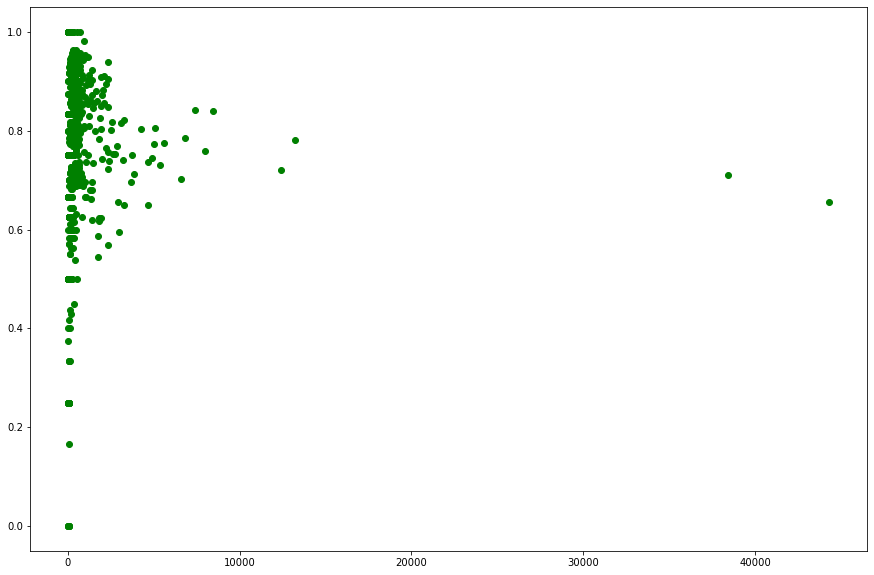

In [109]:
plt.figure(figsize=(15,10))
x = word_prob_count['prob']
y = [int(c) for c in word_prob_count['count']]
plt.scatter(y,x, c ="g")

with L1 features (full mode)

In [74]:
test_prob2_sorted = sorted(test_prob2, key=lambda x: x[1])

In [76]:
word_count = np.array((counts_cn2,np.array(list(word2den_cn2.keys()))))

In [77]:
sort_arr = sorted(word_count.transpose(), key=lambda x: int(x[0]))

In [78]:
words = [a for a in sort_arr if int(a[0])>40]

In [79]:
word_prob = pd.DataFrame(test_prob2_sorted,columns = ['word','prob'])
count_word = pd.DataFrame(words, columns = ['count','word'])
word_prob_count = word_prob.merge(count_word, how='inner', on='word')

In [86]:
word_prob_count[:30]

,word,prob,count
0,五,0.000000,971
1,東,0.000000,457
2,野餐,0.000000,75
3,太,0.000000,872
4,繩,0.000000,396
5,亂,0.000000,76
6,貝,0.000000,180
7,應,0.000000,147
8,數,0.000000,344
9,瓶,0.000000,78


In [98]:
word_prob_count[-30:]

,word,prob,count
990,木地板,1.0,79
991,拇指,1.0,62
992,厚,1.0,42
993,珠,1.0,68
994,polo,1.0,61
995,球衫,1.0,44
996,金毛,1.0,41
997,花白,1.0,71
998,草帽,1.0,91
999,大提琴,1.0,45


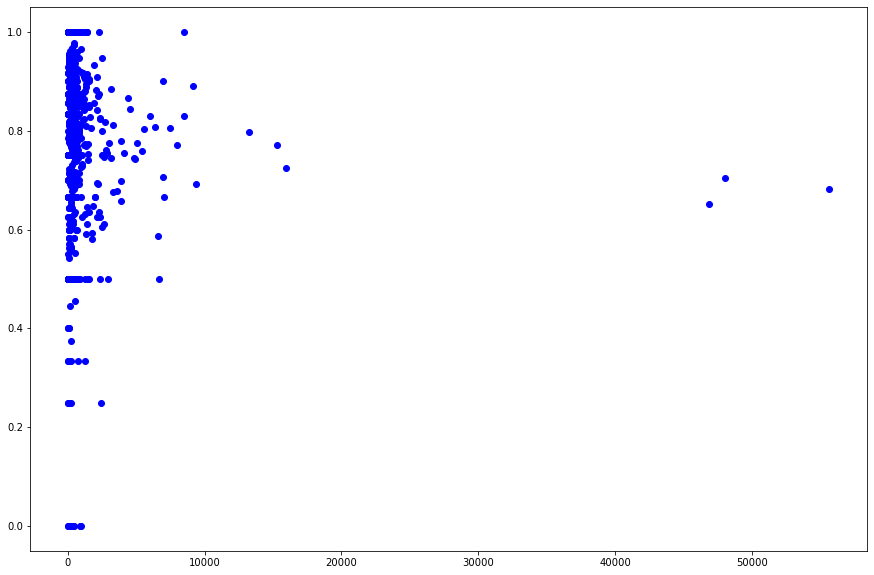

In [85]:
plt.figure(figsize=(15,10))
x = word_prob_count['prob']
y = [int(c) for c in word_prob_count['count']]
plt.scatter(y,x, c ="b")

# Reference

Text segmentation:

https://pypi.org/project/jieba/